# Classify images using data of only 1 user

Take all data from 1 user, split in groups by image id.

Learn to classify True/Fake patches, then combine them into True/Fake images by majority vote.

`Classifying samples with a generally trained ELM and aggregating by image is a different problem!`

In [1]:
import os
import numpy as np
import pandas as pd

import skelm

from matplotlib import pyplot as plt
import seaborn as sn
%matplotlib inline

/home/akusok/miniconda3/envs/torch/lib/python3.8/site-packages/scikit_cuda-0.5.4-py3.8.egg/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
import scipy
from sklearn.utils.fixes import loguniform
from time import time

In [4]:
data_folder = "/Users/akusok/wrkdir/research-signatures-data/MCYTDB"
overlap = '10p'
samples = 100000 // 30   # per file

# 

## Load data and run default ELM

In [5]:
for _,users,_ in os.walk(data_folder):
    break

In [6]:
def process_user(u0, model, overlap):
    
    for root,_,files in os.walk("{}/{}/overlap{}".format(data_folder, u0, overlap)):
        data_files = [os.path.join(root, f) for f in files if f.endswith(".parquet.gz")]
    
    data = []
    for i, df0 in enumerate(data_files):
        X = pd.read_parquet(df0).loc[:, '0':]
        X = X.sample(min(len(X), samples))
        X['fake'] = int("/cf-" in df0)
        X['group'] = i
        data.append(X)
    data = pd.concat(data).reset_index(drop=True)    
    
    group = np.array(data['group'])
    y = np.array(data['fake'])
    X = np.array(data.loc[:, :'1023'])
    X = X - X.mean()
    X = X / X.std().clip(min=0.5)
    X = X.clip(min=-5, max=5)
    
    gkf = GroupKFold(n_splits=10)
    res = []
    for ti, vi in gkf.split(X, y, group):
        model.fit(X[ti], y[ti])
        yh = model.predict(X[vi])
        yv = y[vi]
        gv = group[vi]
        for j in set(gv):
            res.append([j, yv[gv == j].mean(), yh[gv == j].mean()])

    res = np.array(res)
    res = res[np.argsort(res[:,2])]
    return res

In [9]:
V90 = V.copy()

# 10p

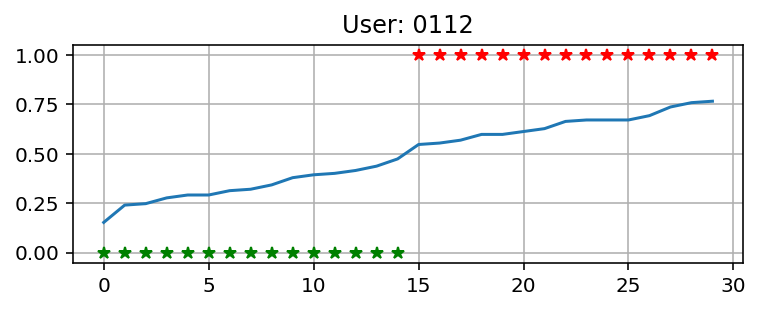

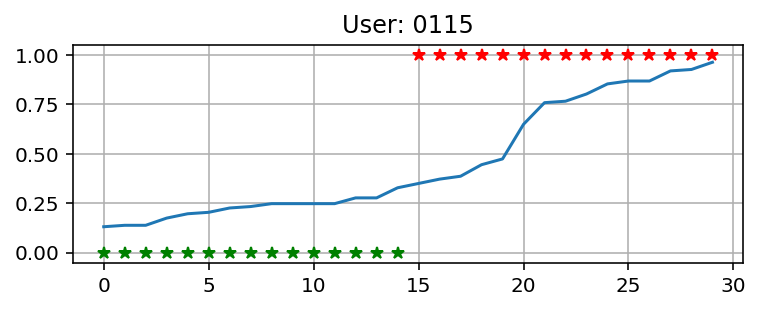

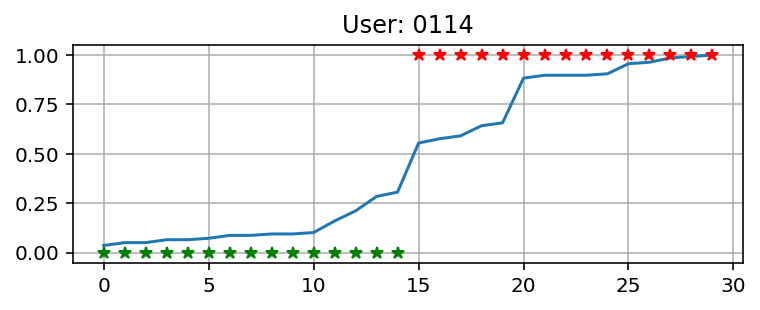

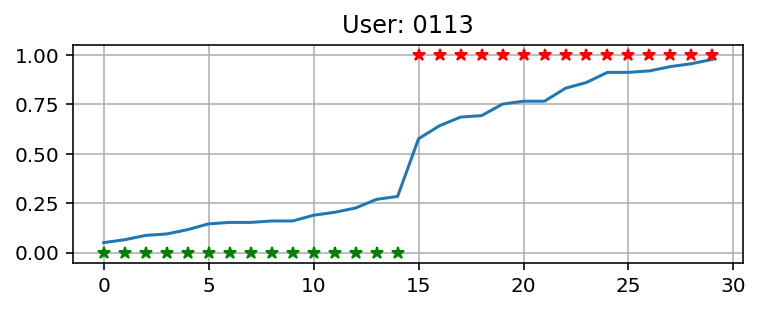

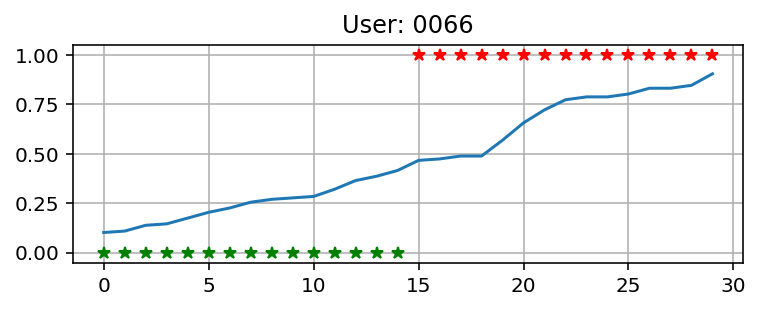

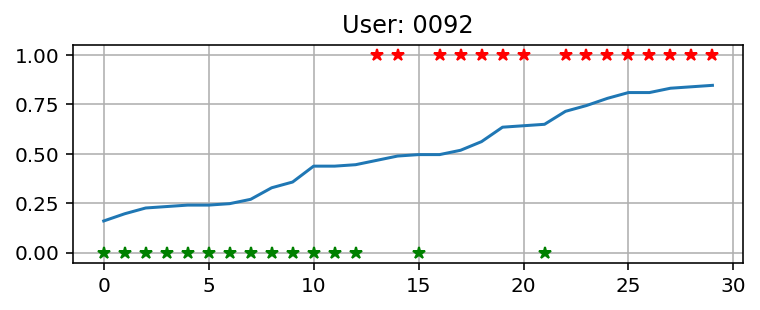

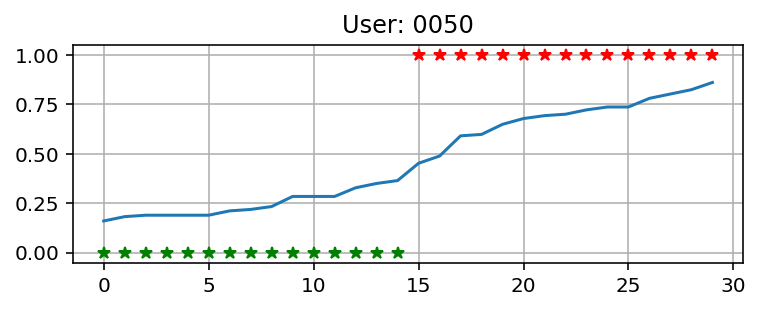

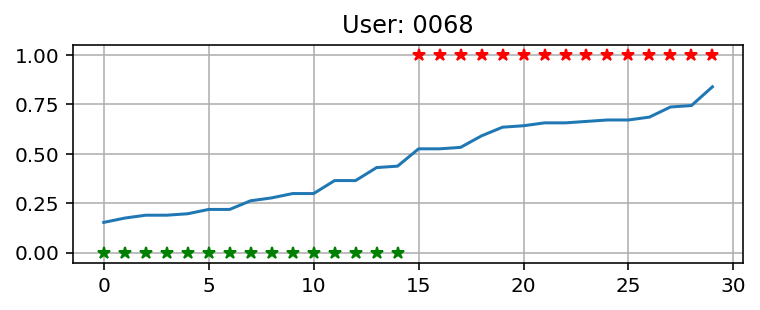

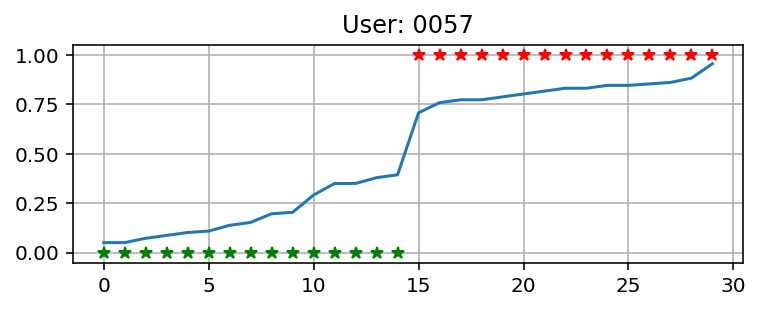

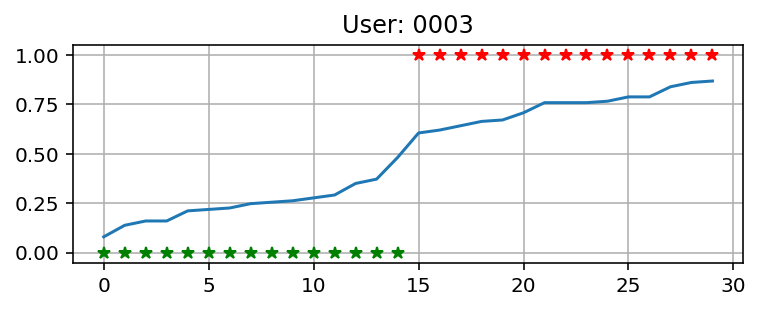

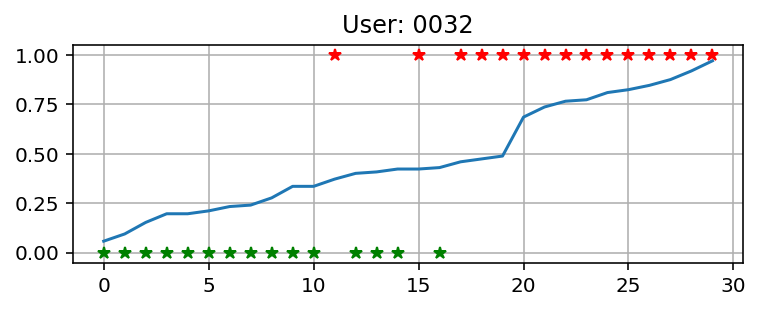

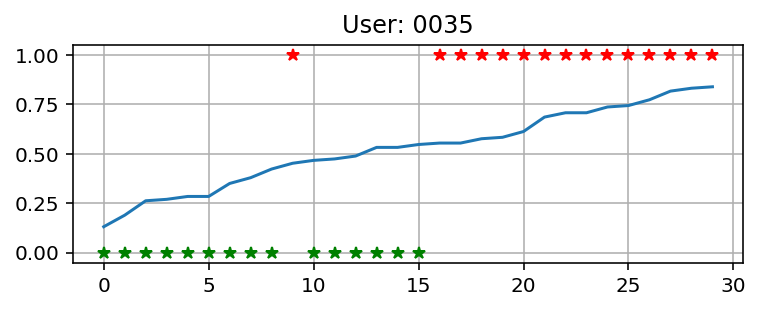

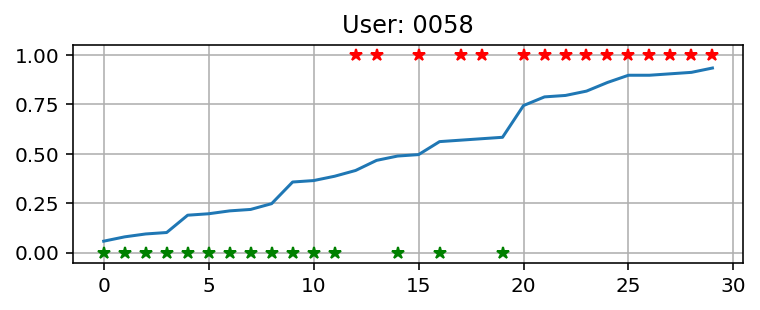

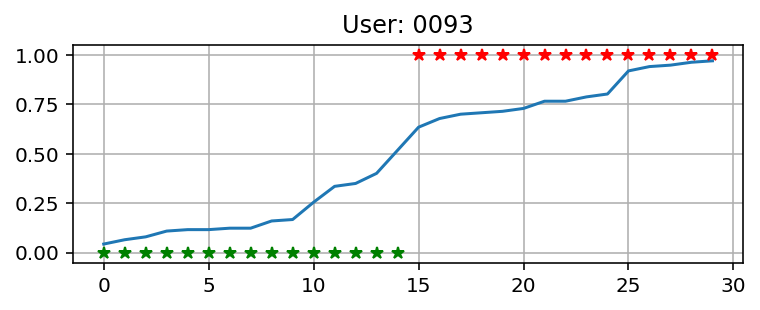

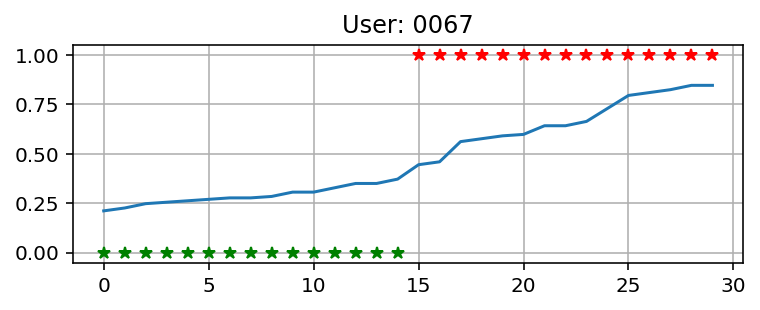

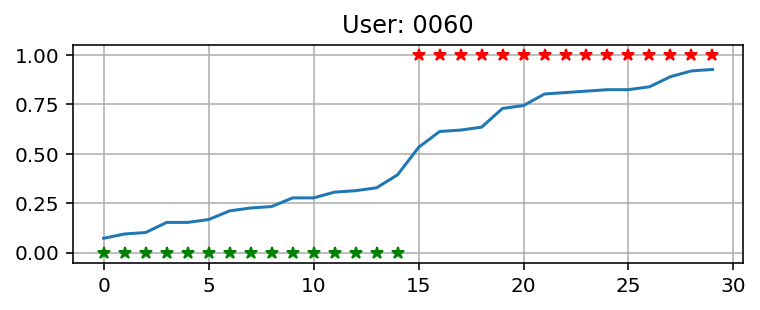

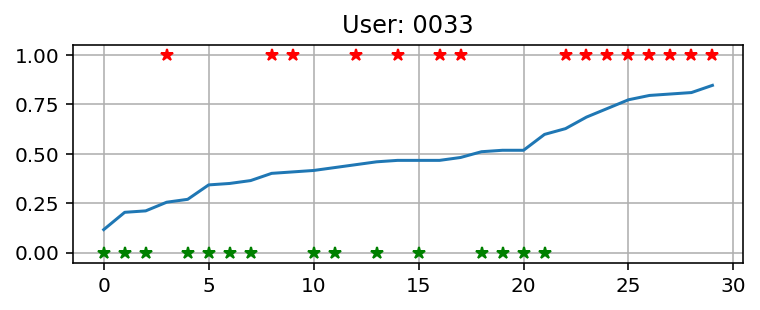

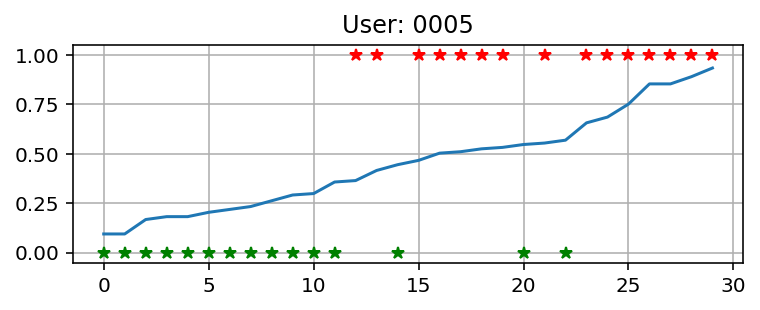

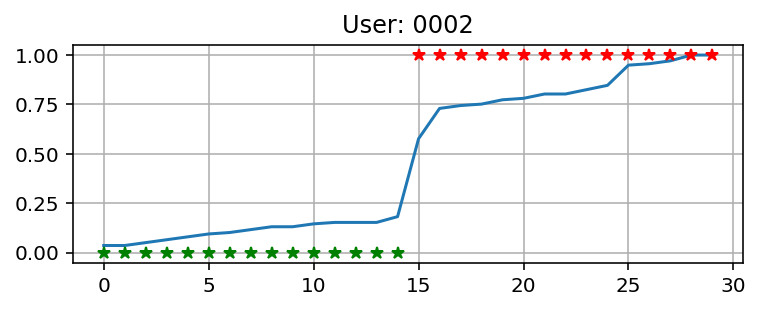

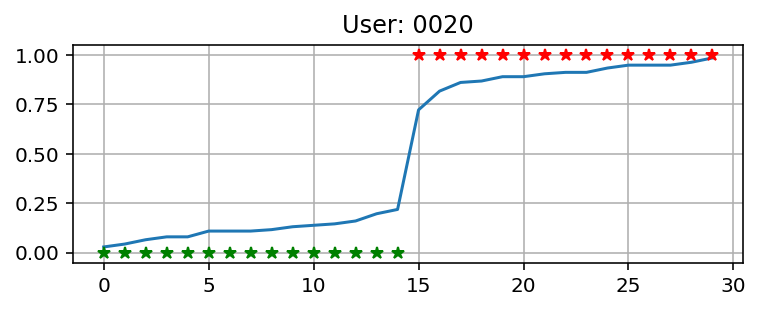

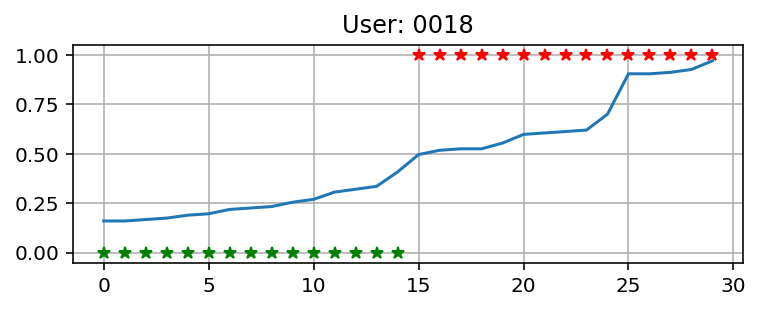

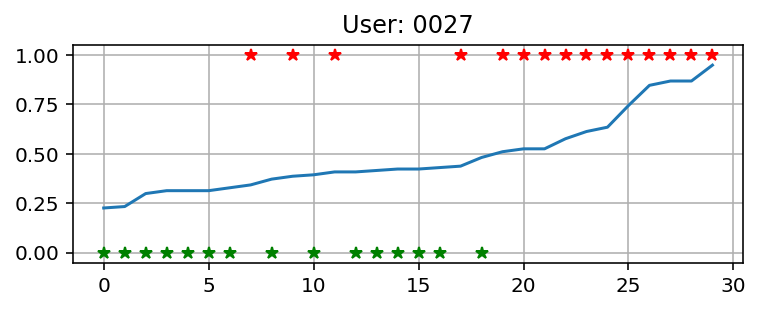

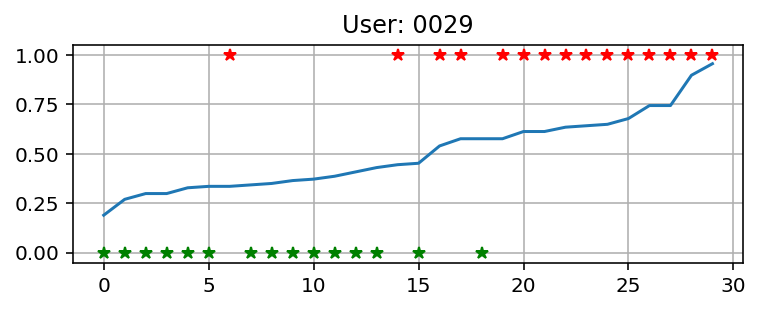

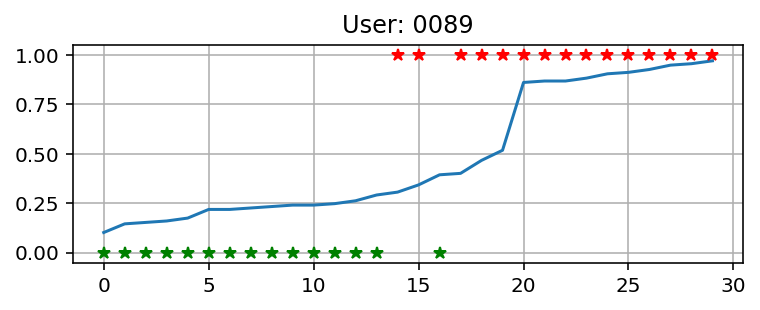

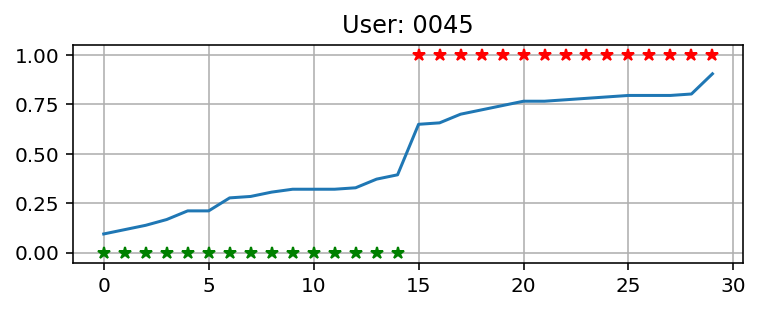

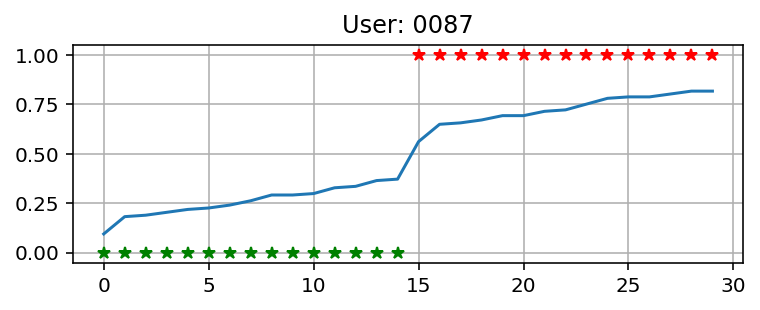

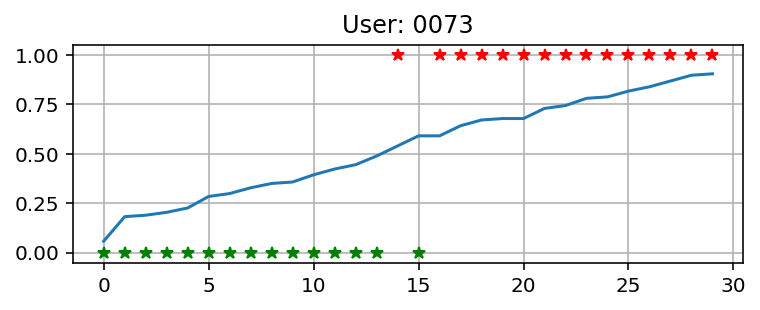

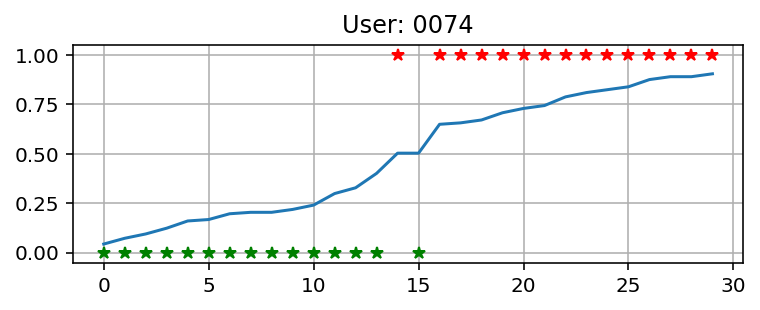

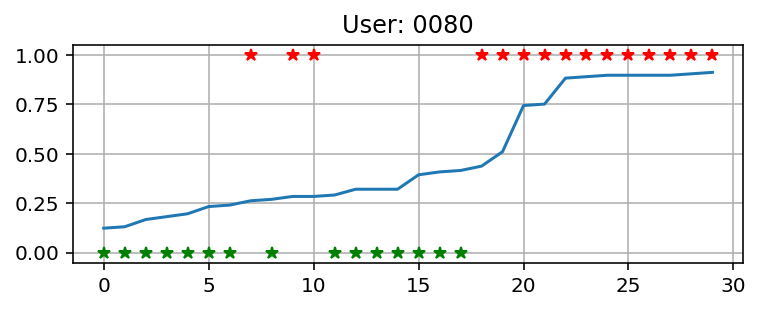

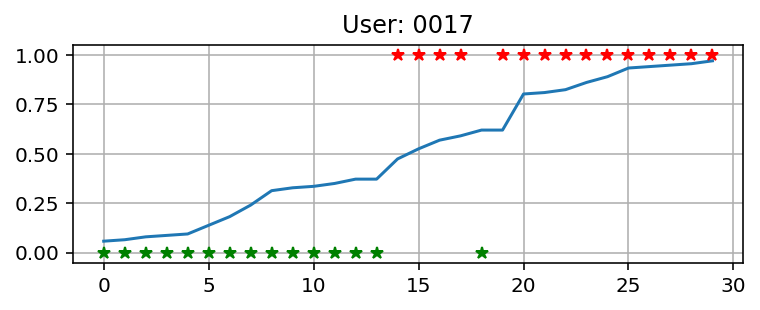

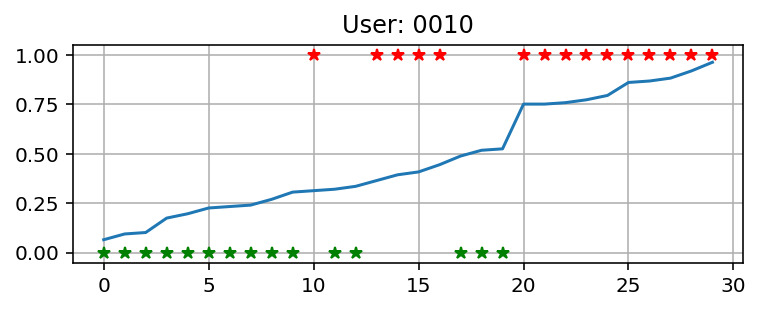

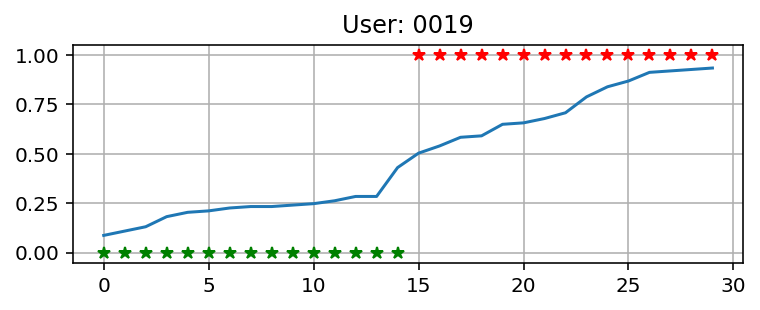

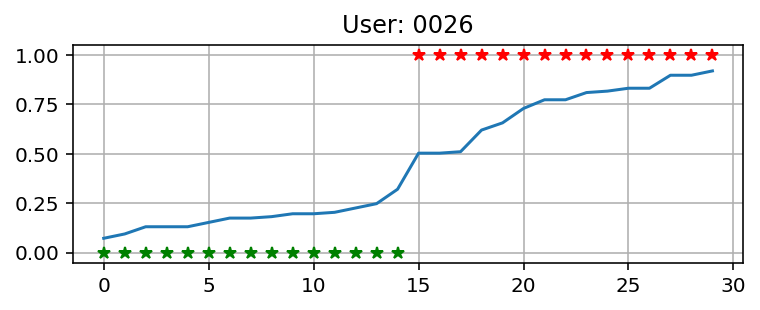

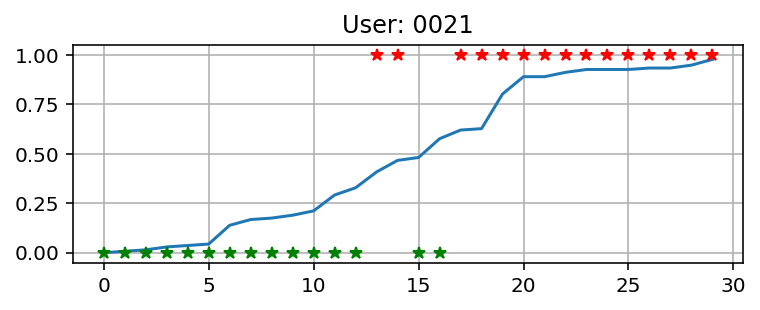

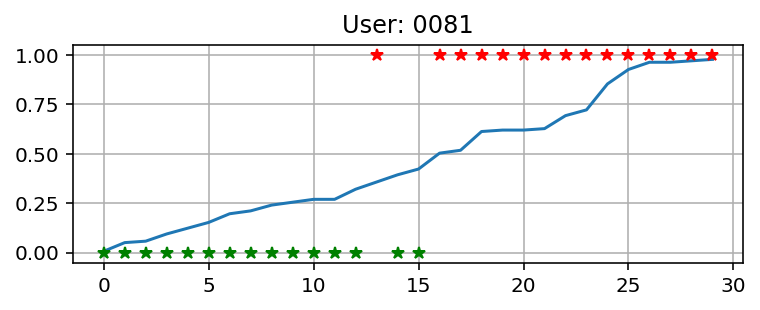

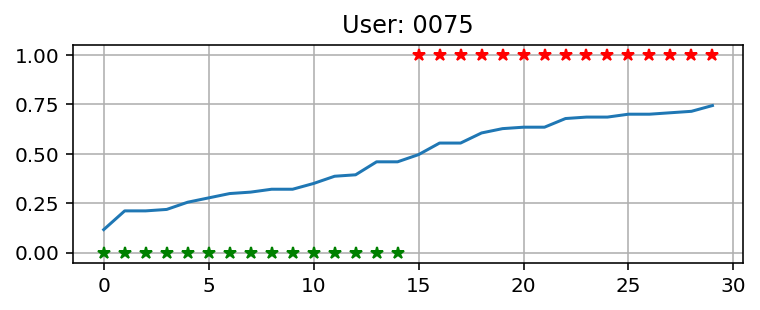

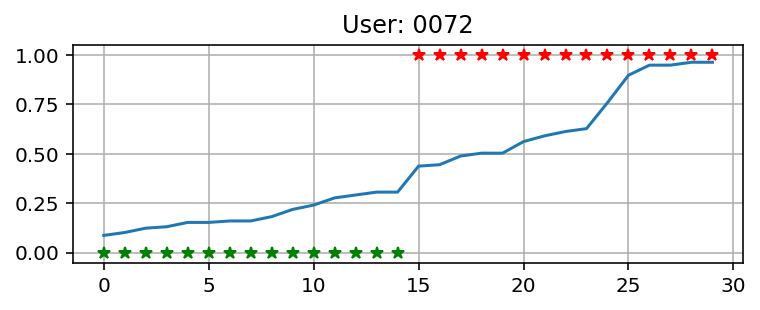

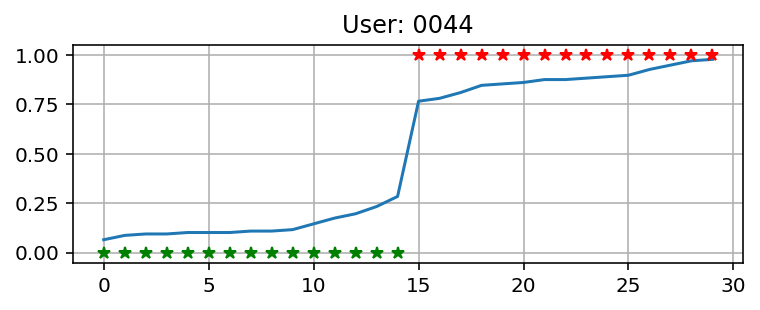

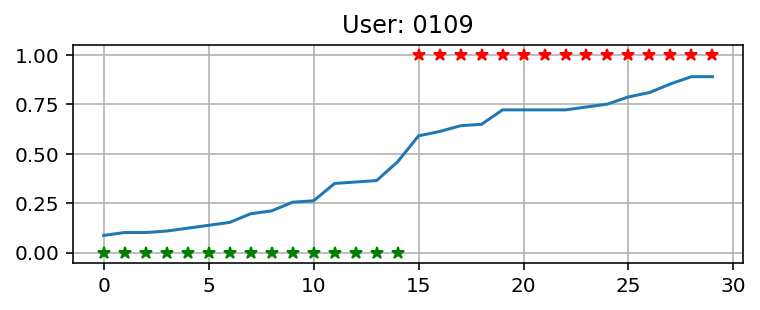

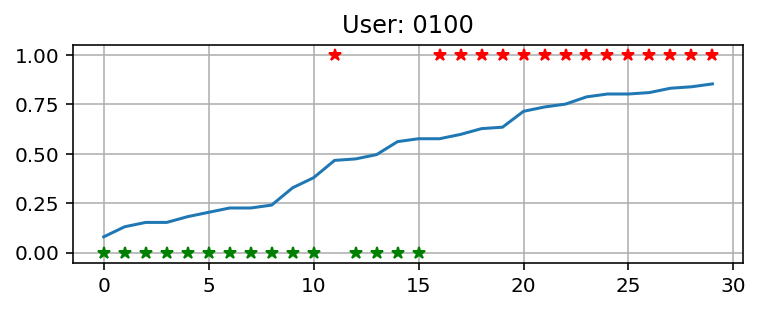

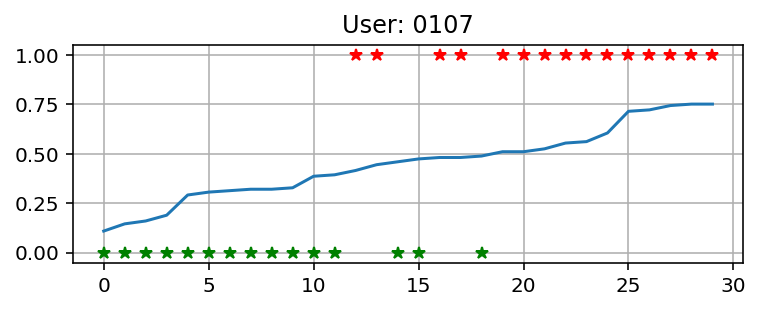

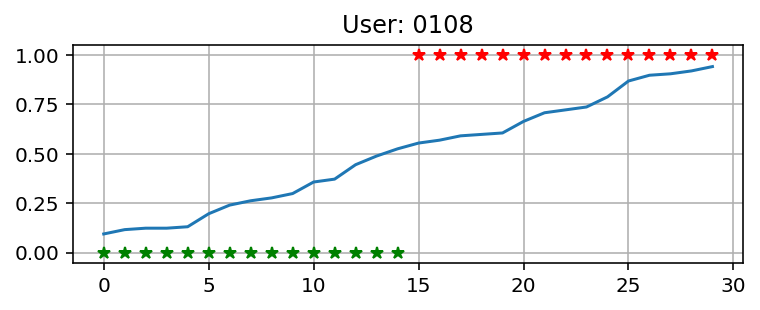

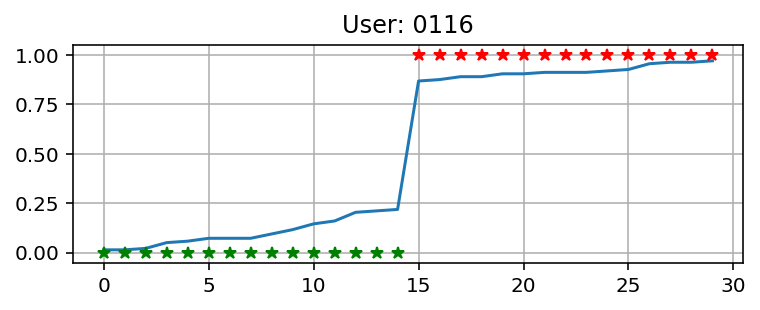

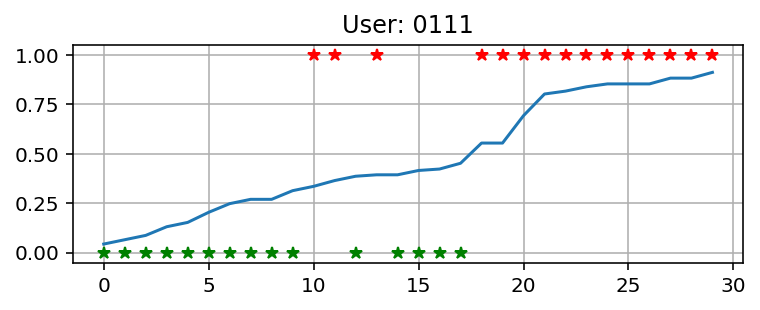

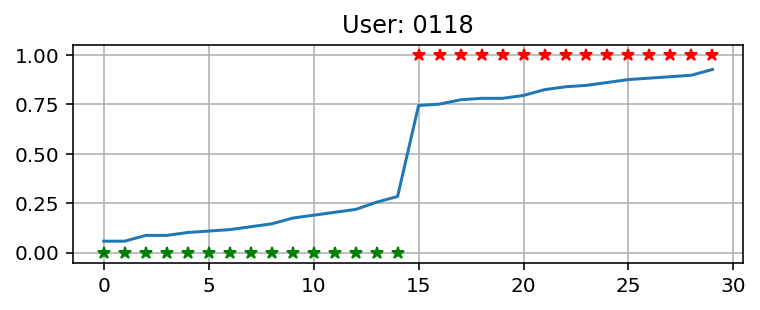

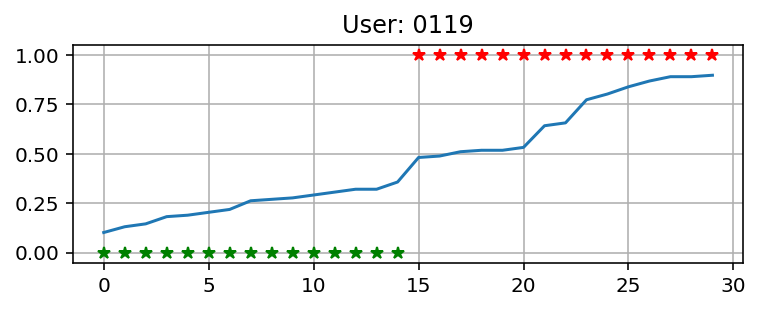

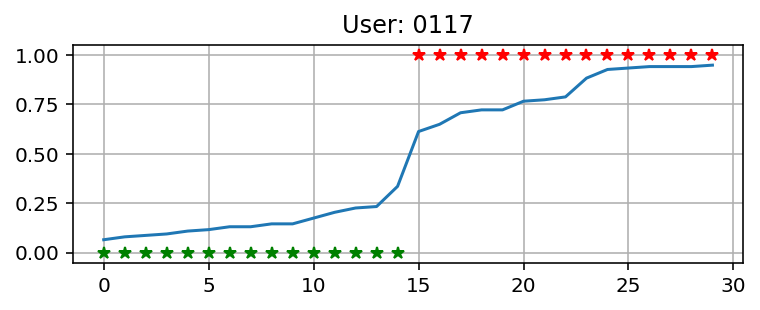

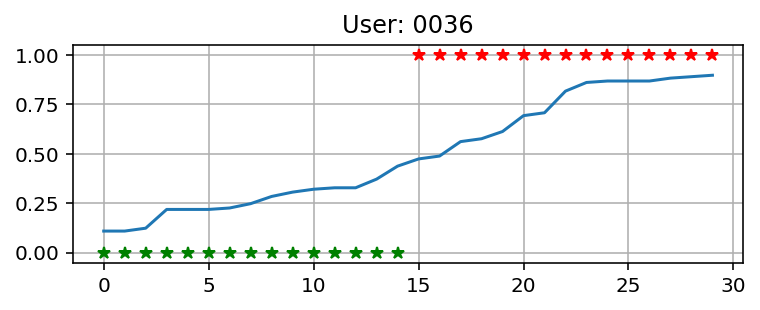

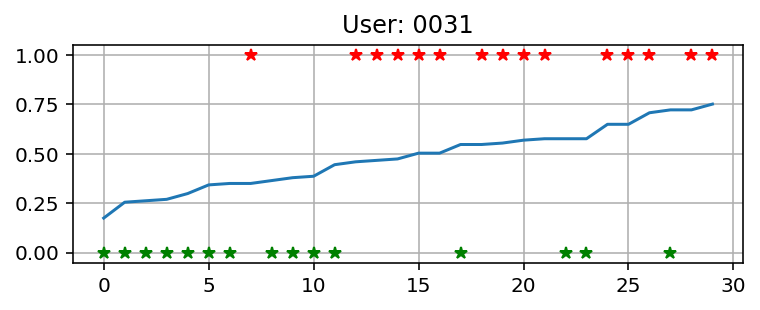

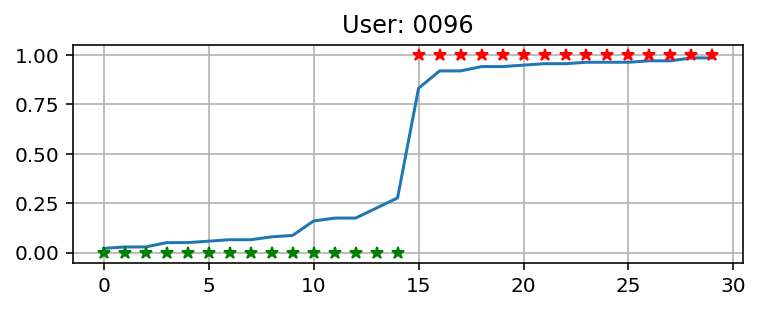

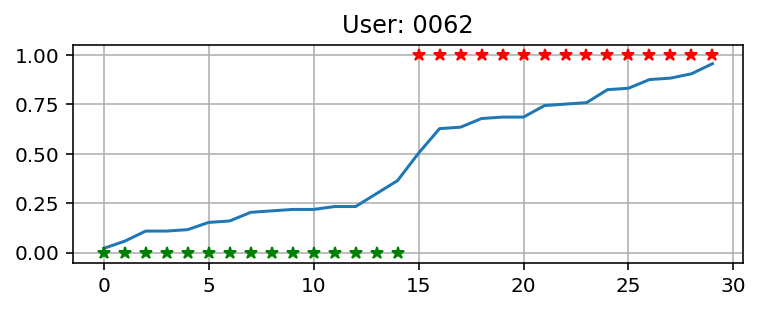

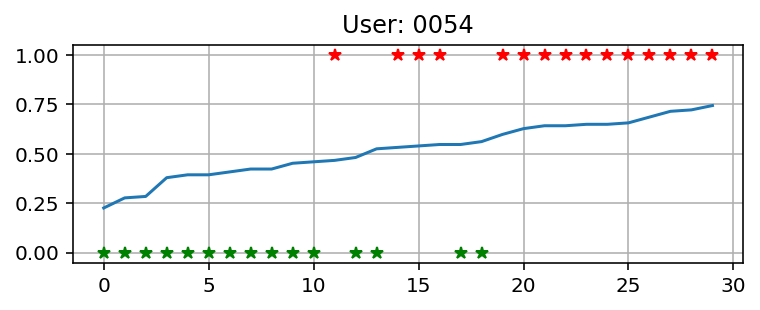

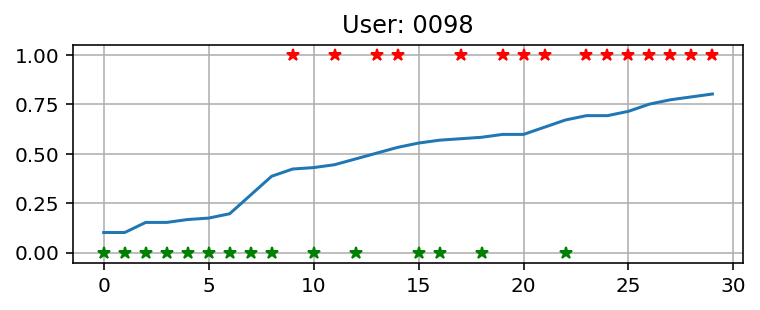

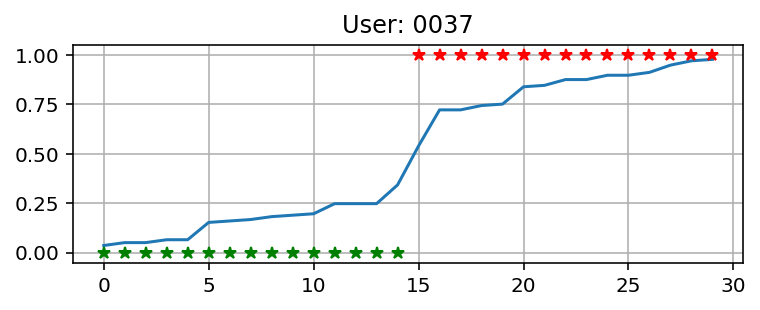

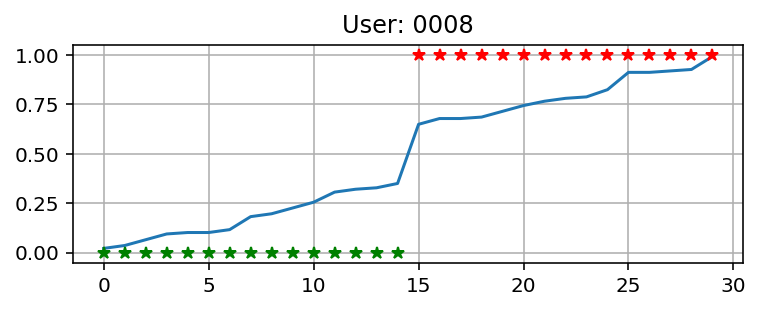

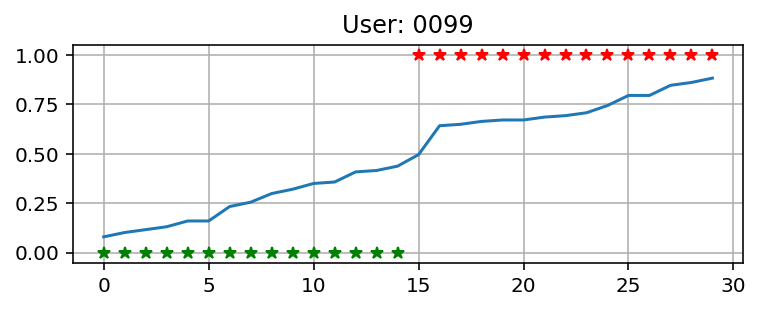

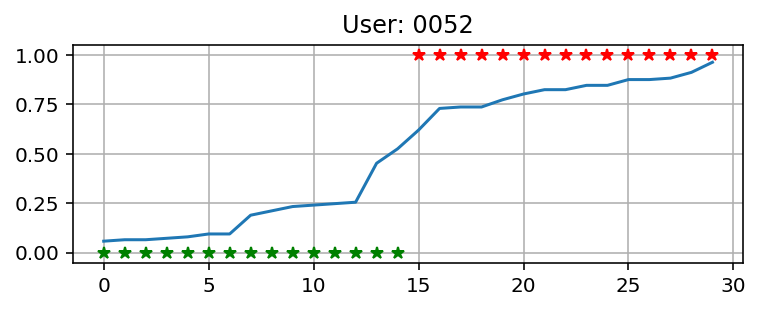

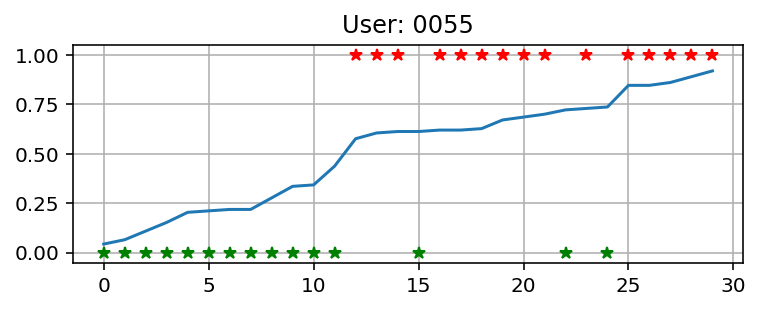

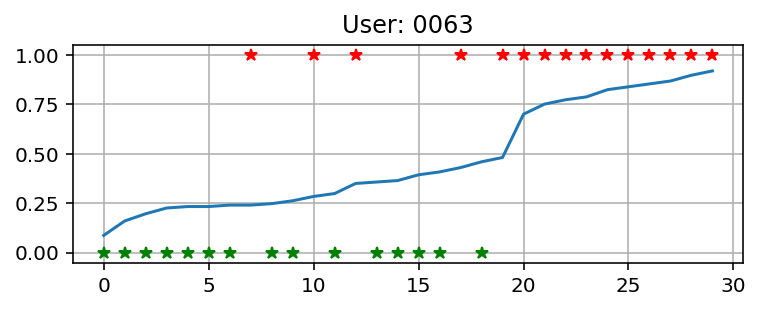

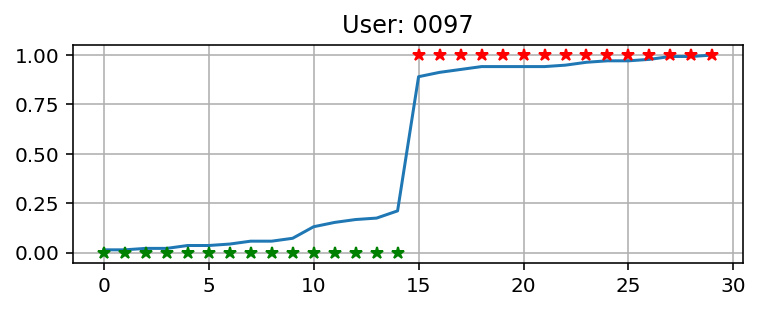

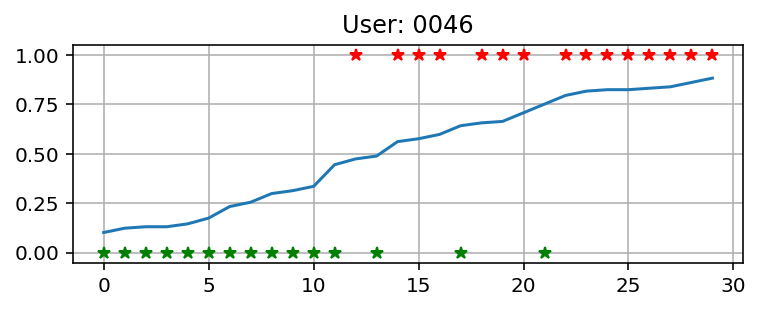

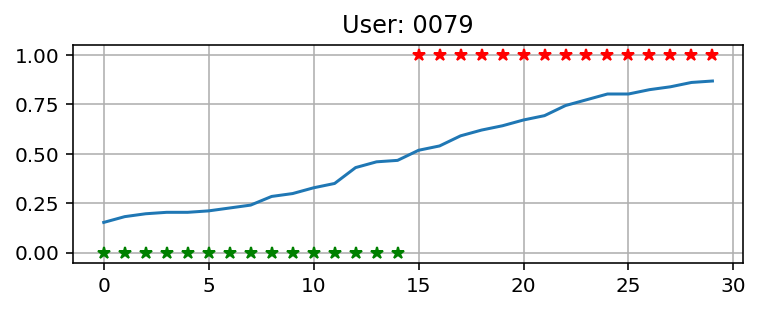

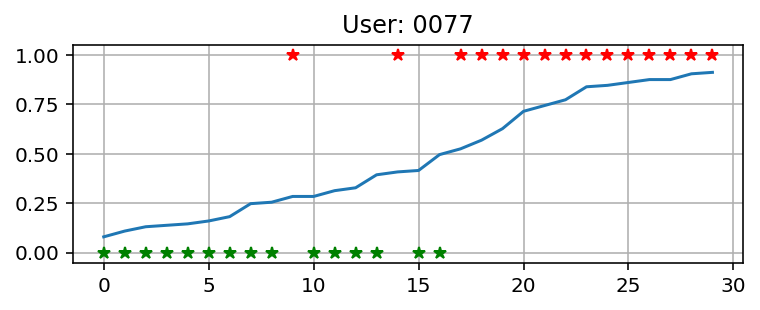

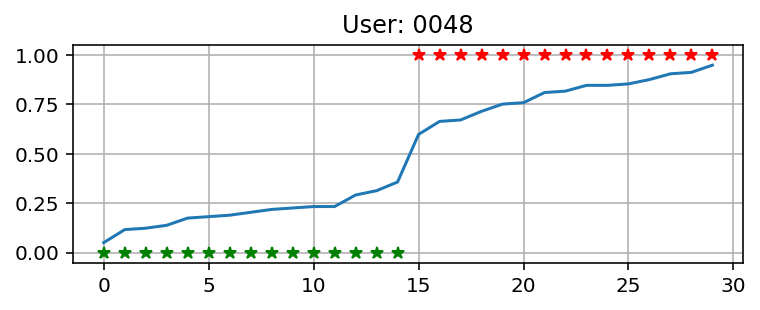

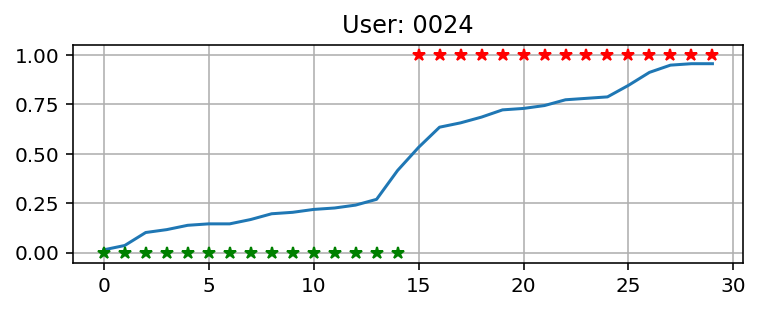

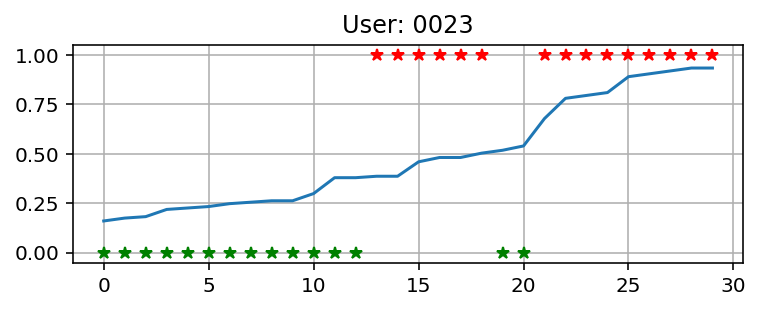

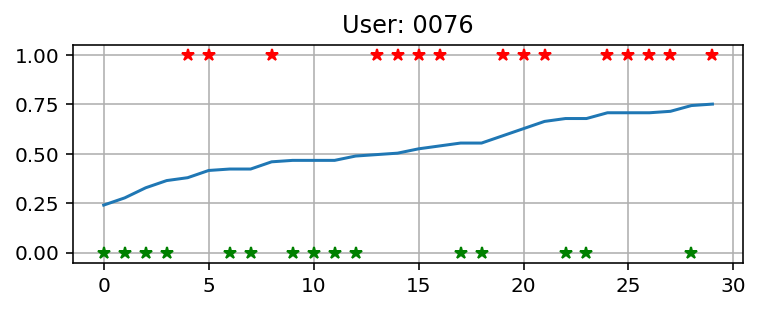

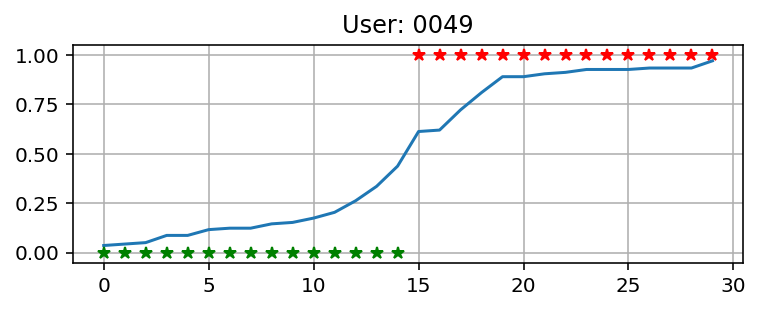

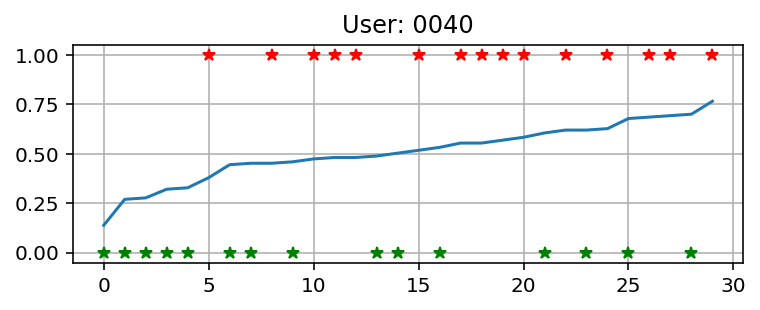

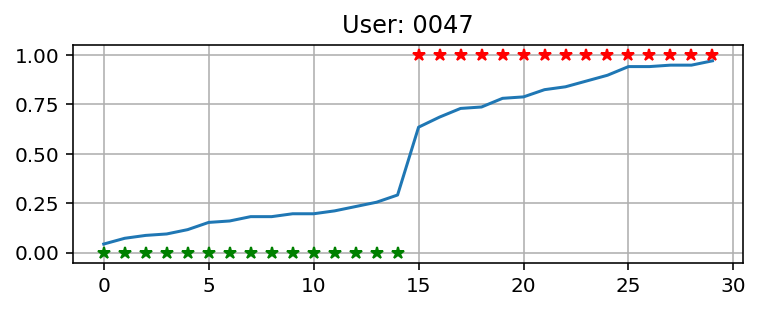

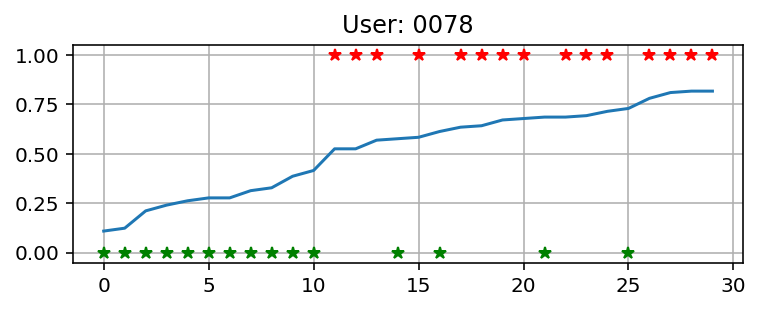

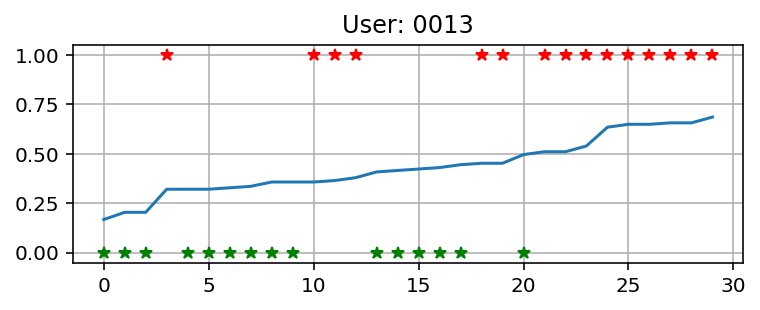

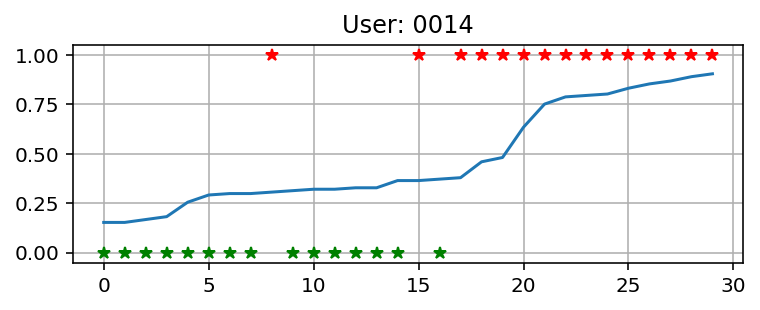

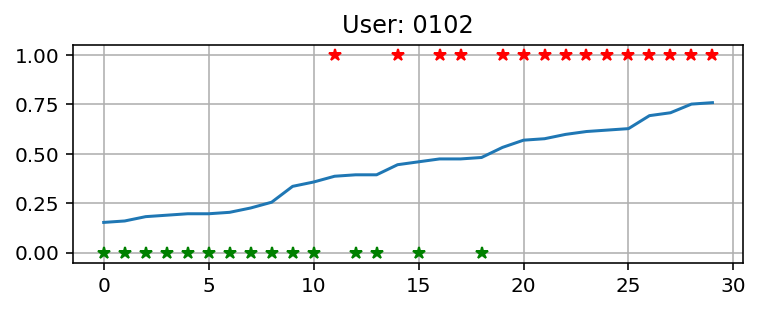

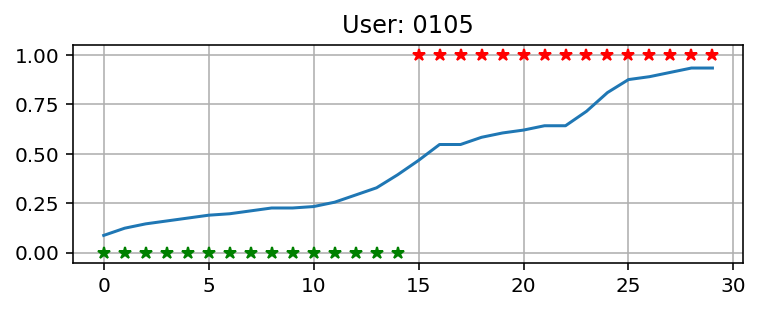

In [18]:
V10 = {}
model = skelm.ELMClassifier(alpha=10**3.0, n_neurons=10000, batch_size=10000)

for usr in users:
    res = process_user(usr, model, overlap='10p')
    V10[usr] = res
    
    plt.figure(figsize=(6, 2))
    plt.plot(res[:, 2])
    i0 = np.where(res[:, 1] == 0)[0]
    plt.plot(i0, [0]*len(i0), "*g")

    i1 = np.where(res[:, 1] == 1)[0]
    plt.plot(i1, [1]*len(i1), "*r")
    plt.title("User: "+usr)
    plt.grid()
    plt.show()

# 25p

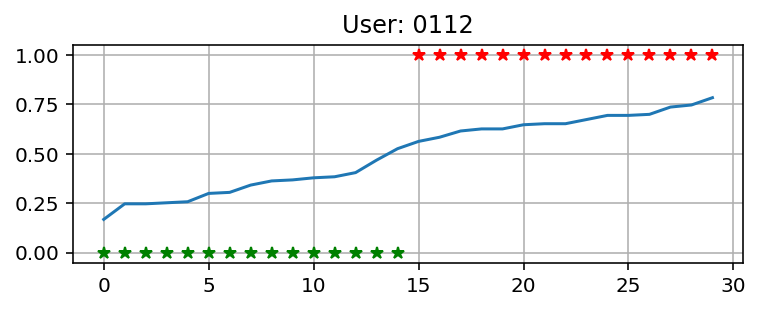

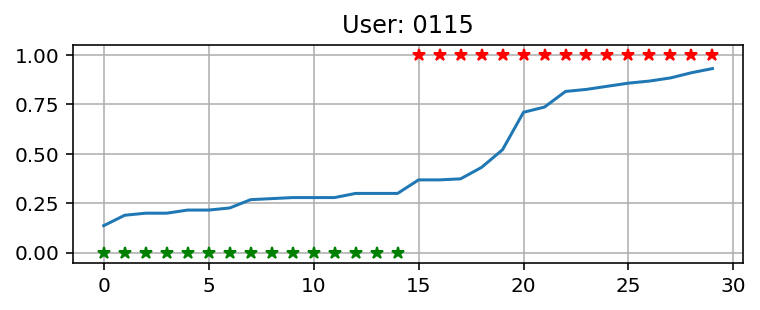

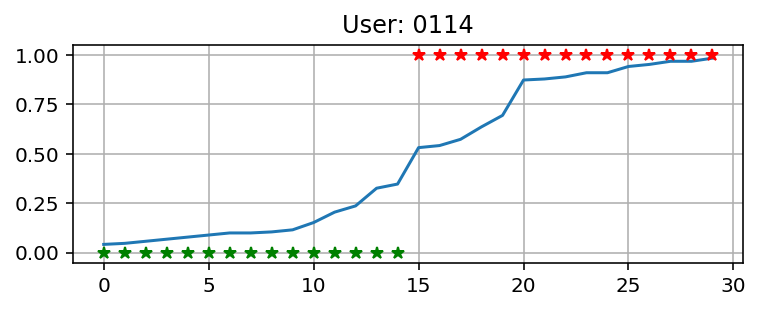

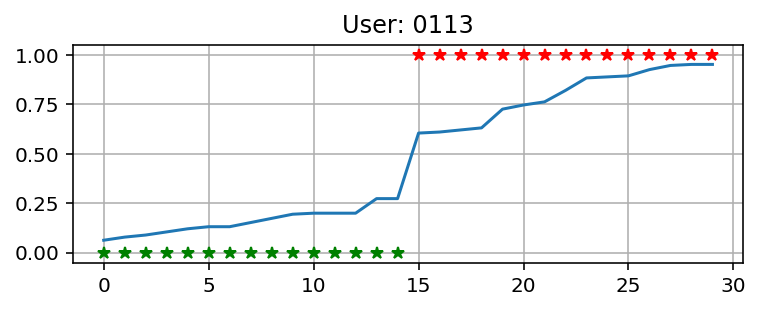

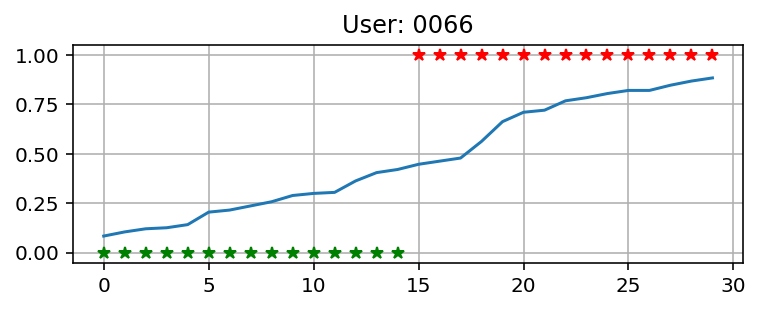

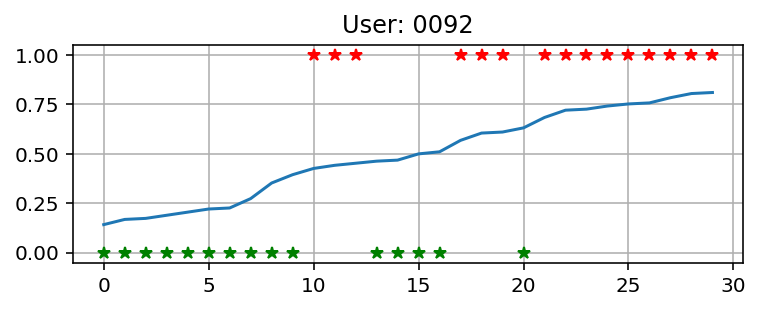

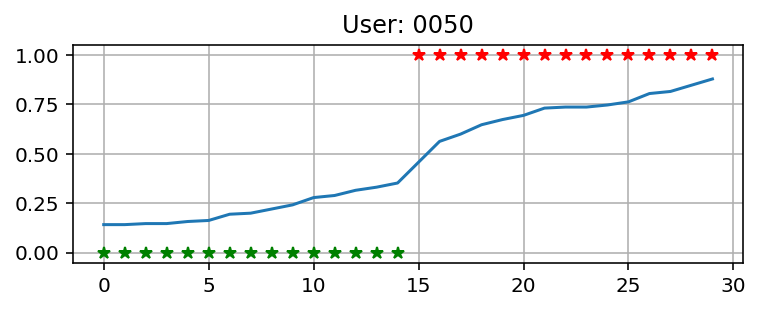

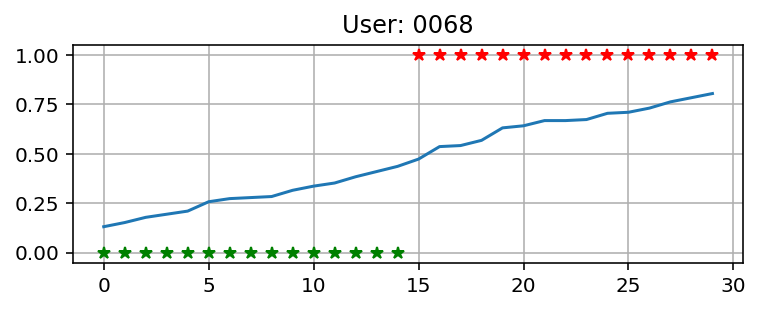

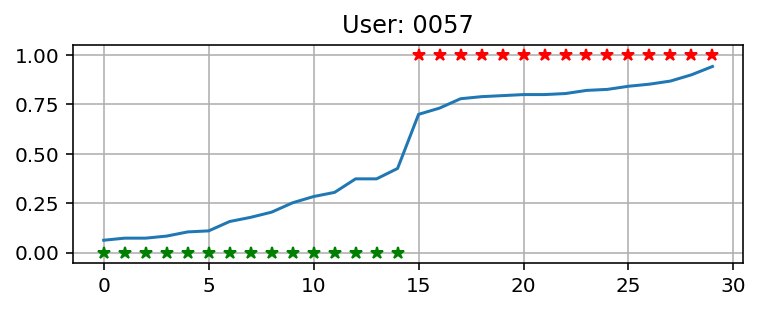

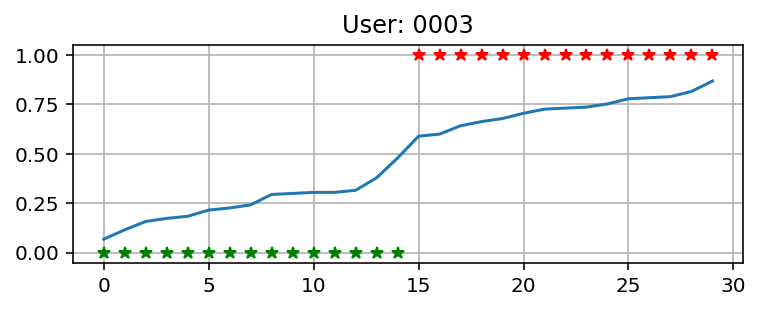

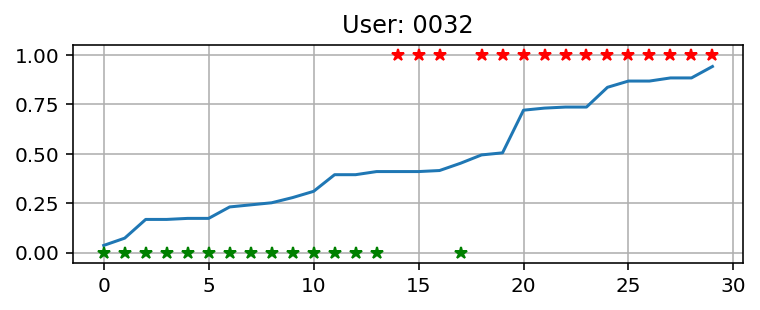

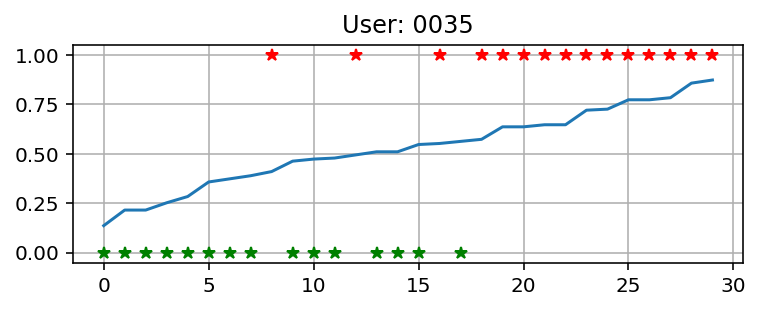

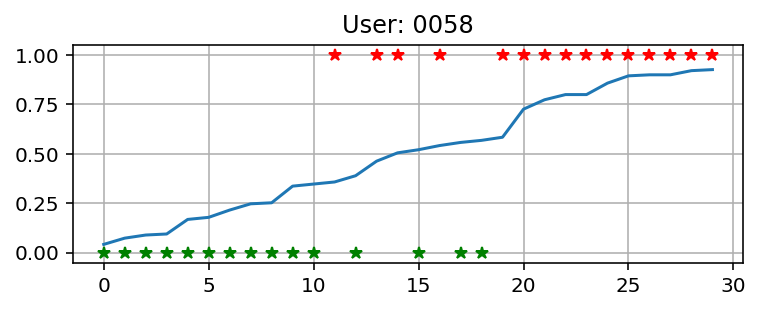

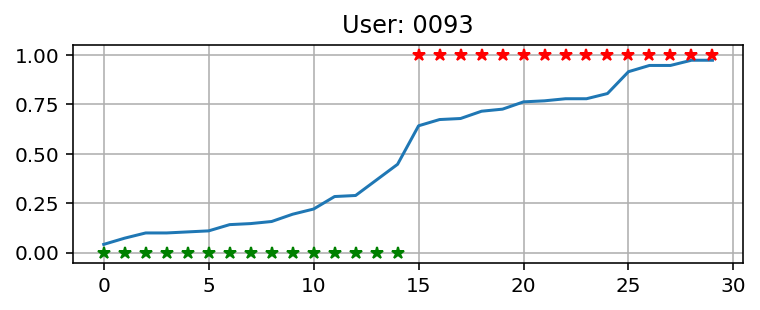

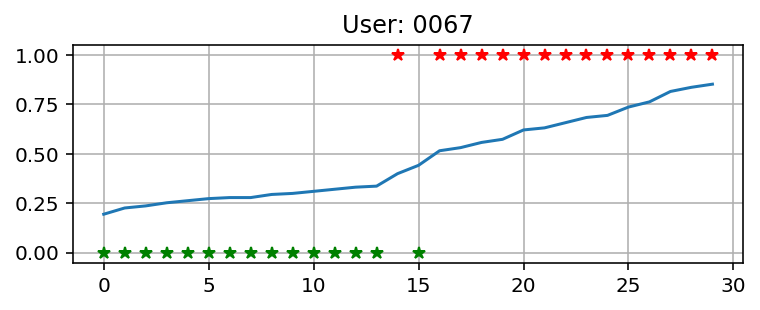

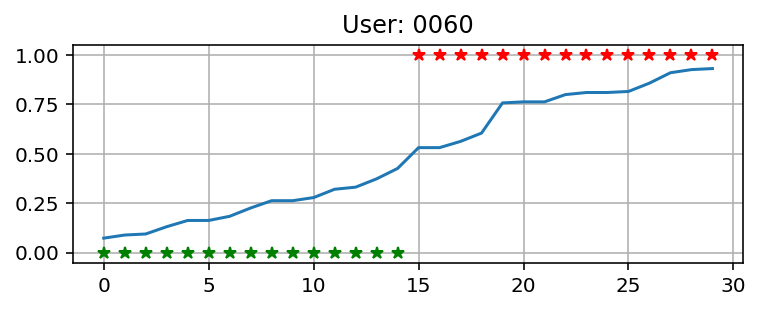

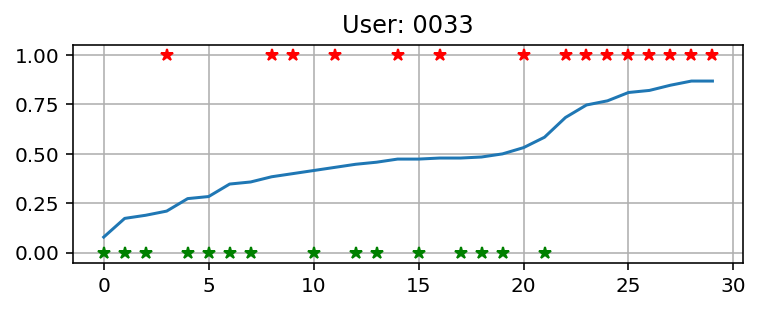

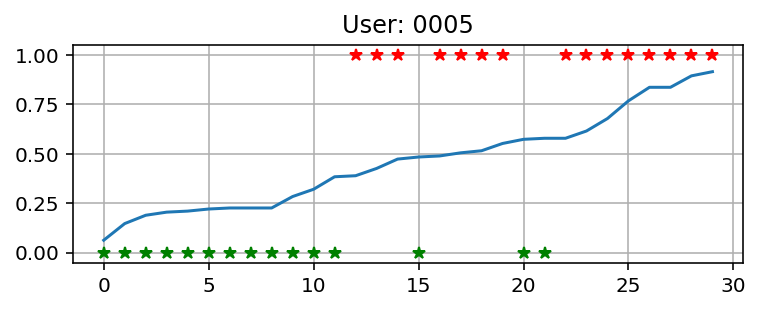

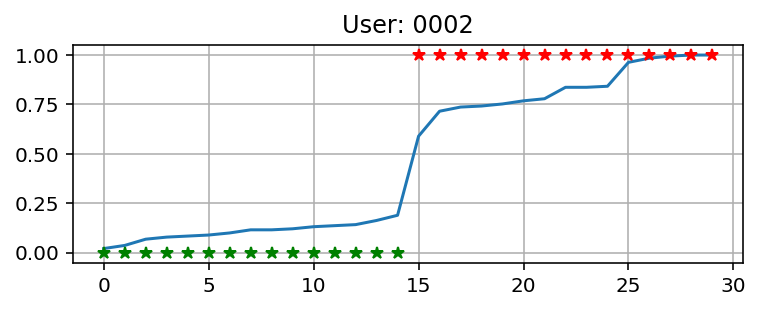

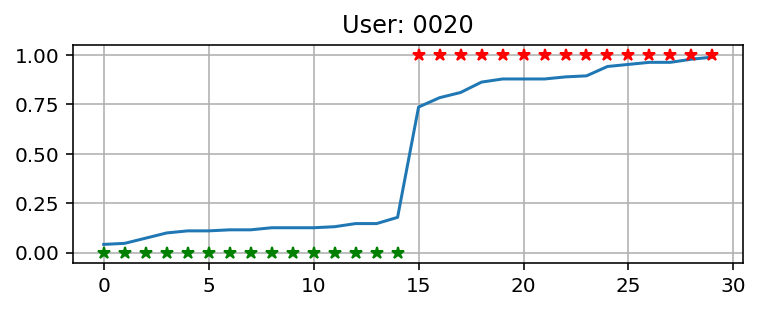

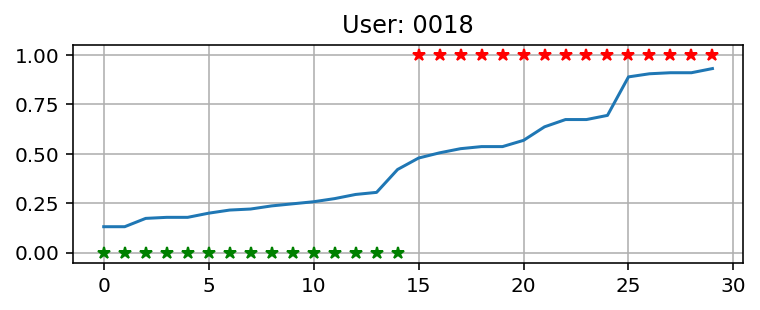

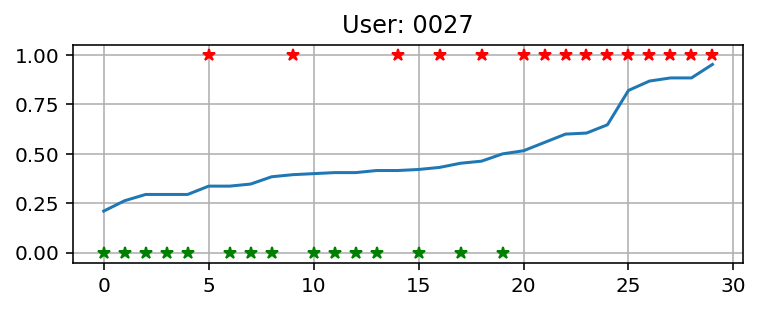

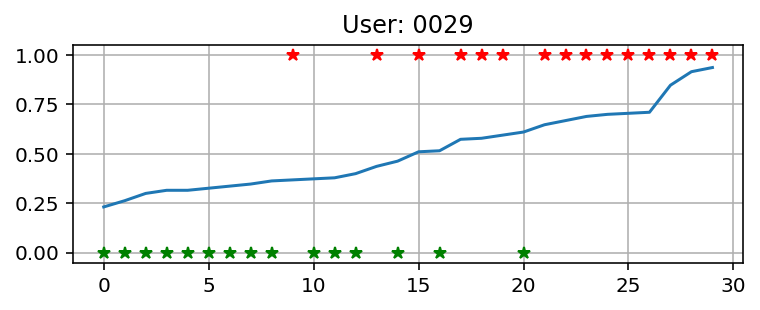

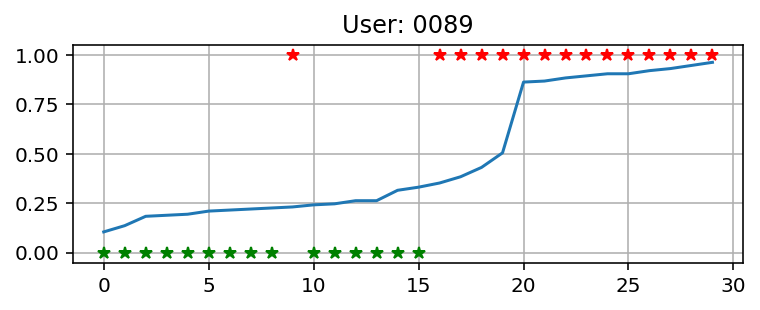

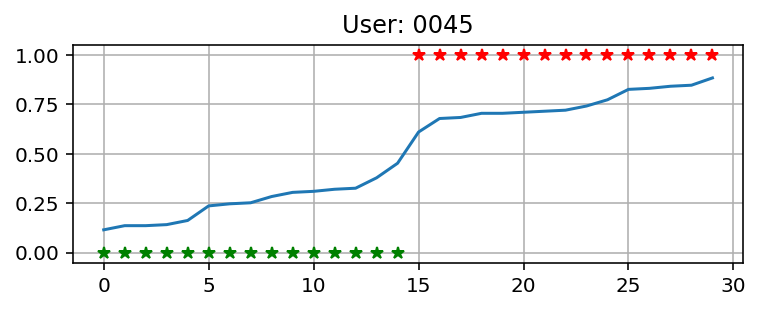

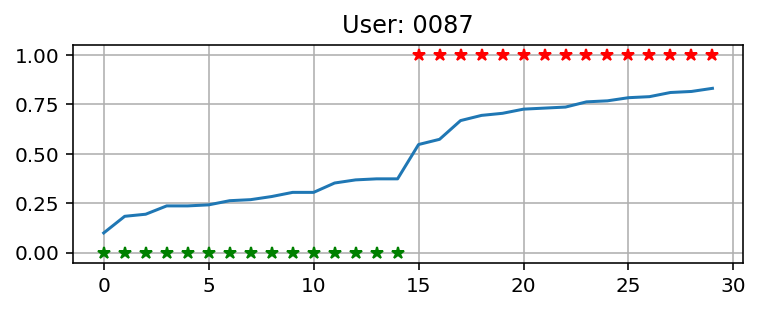

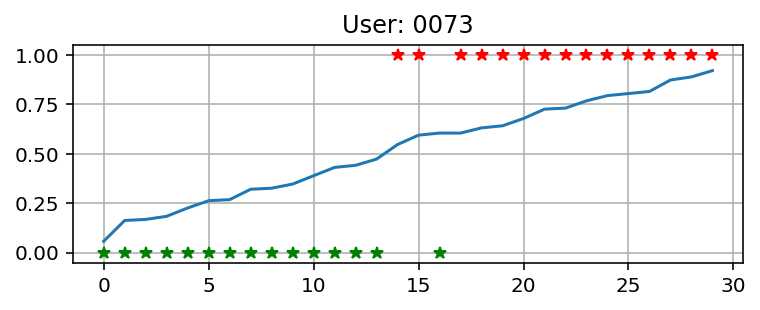

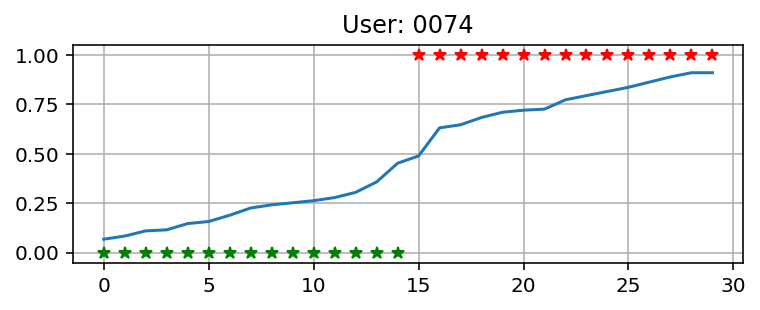

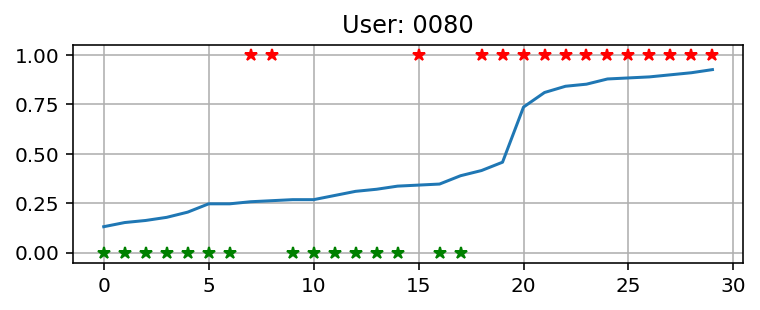

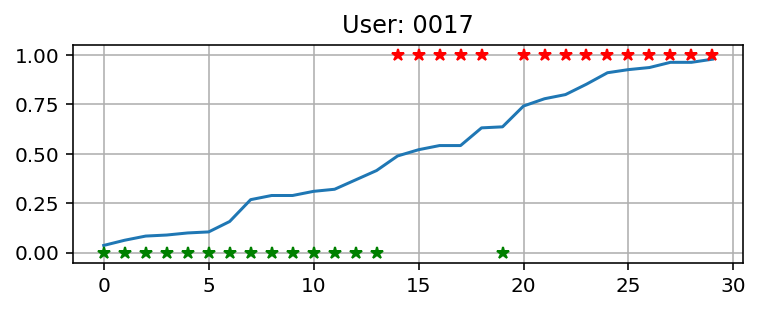

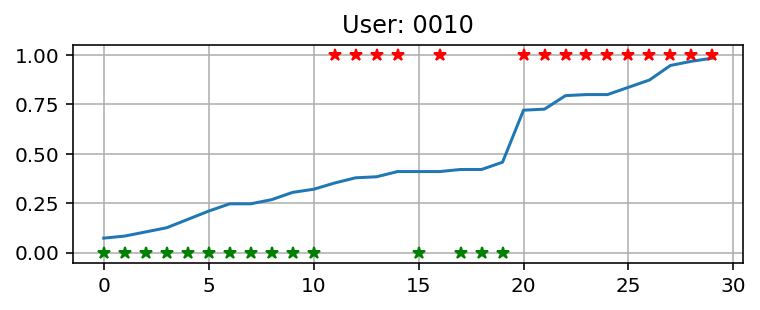

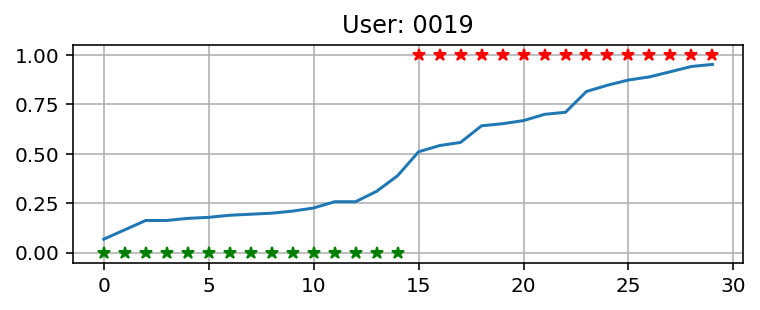

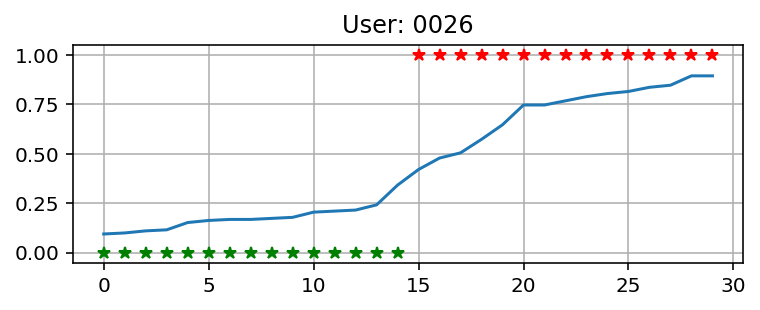

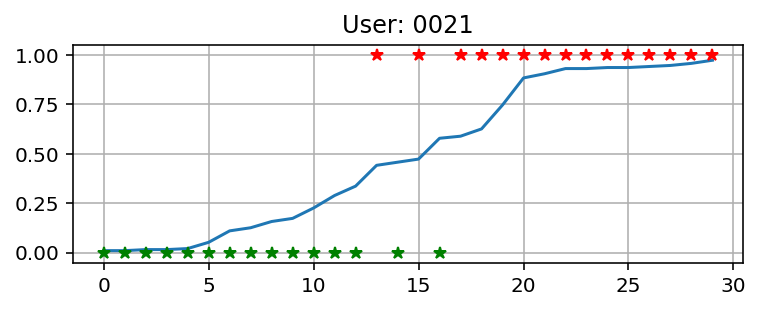

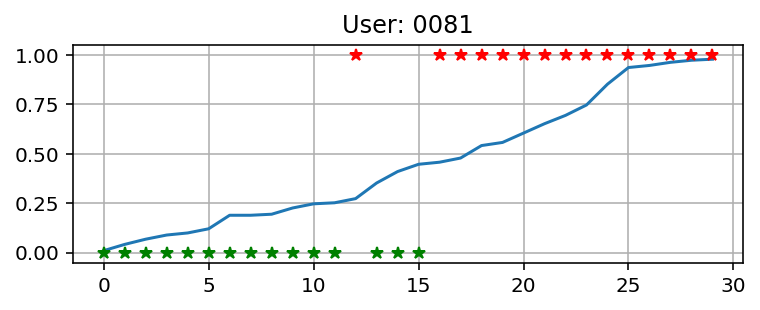

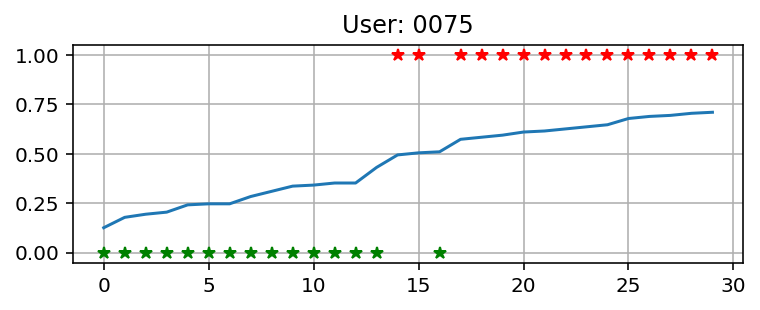

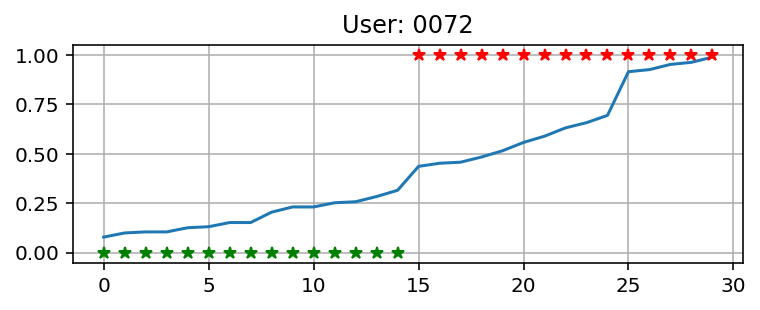

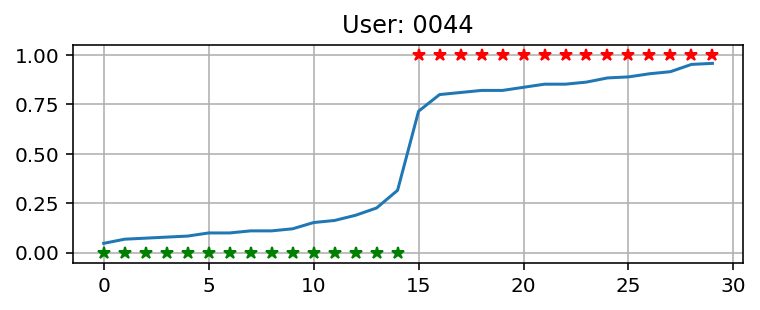

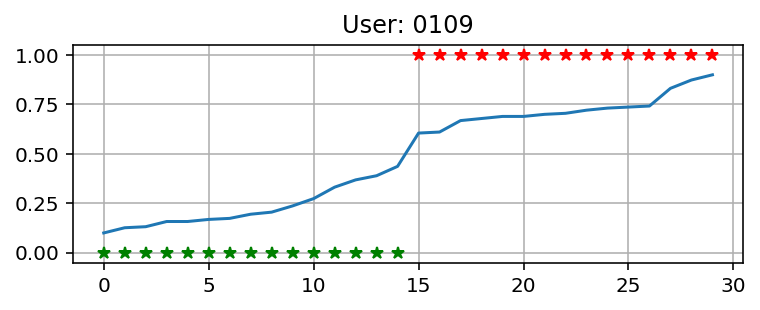

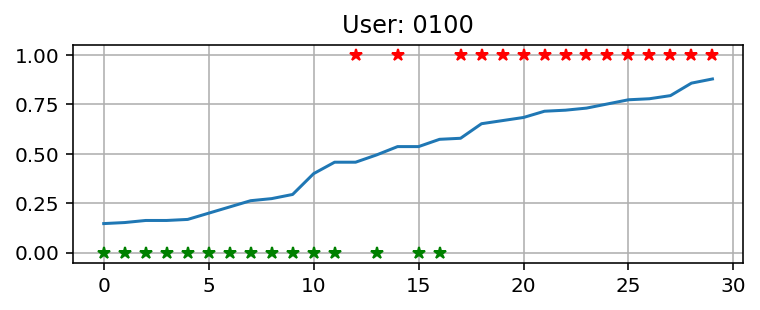

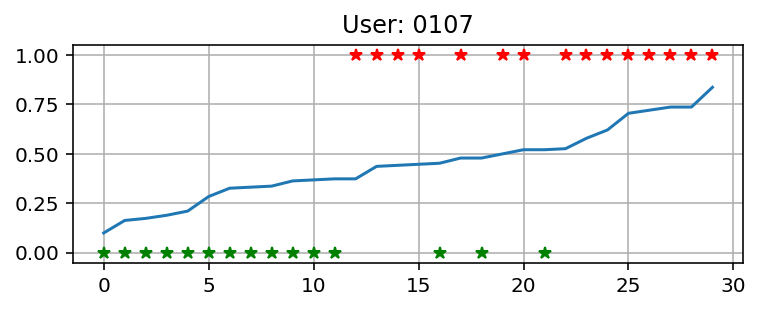

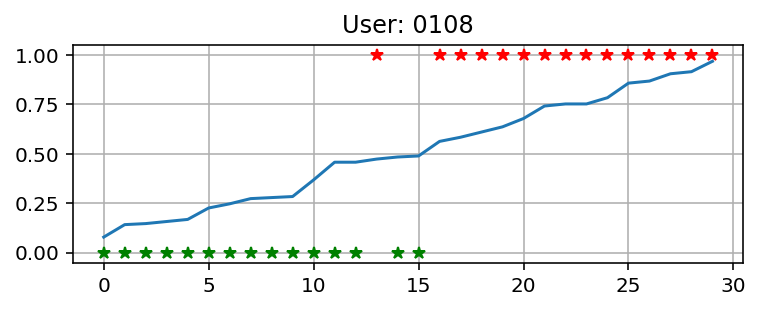

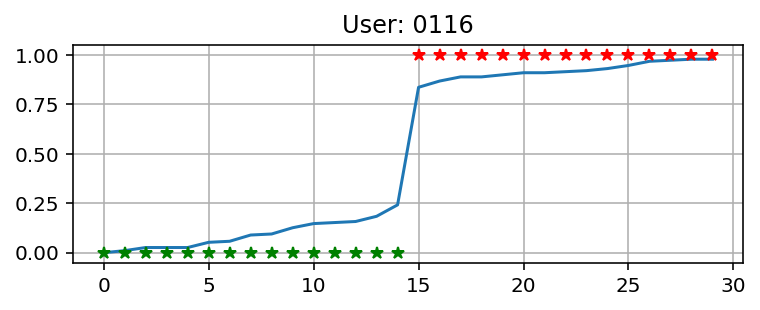

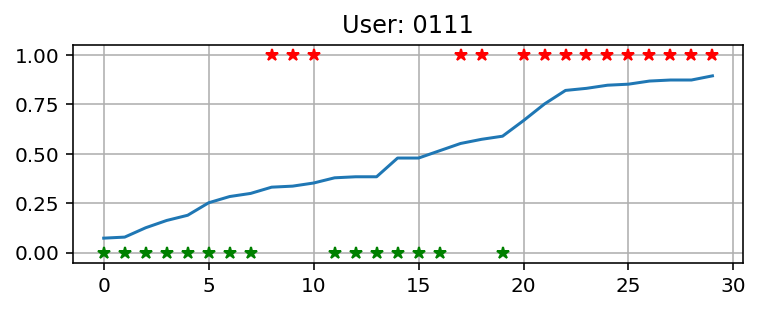

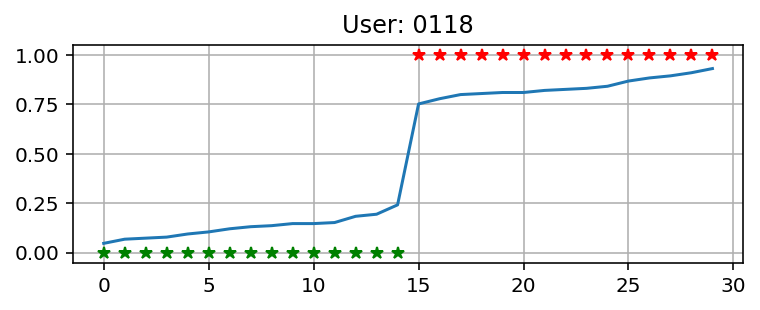

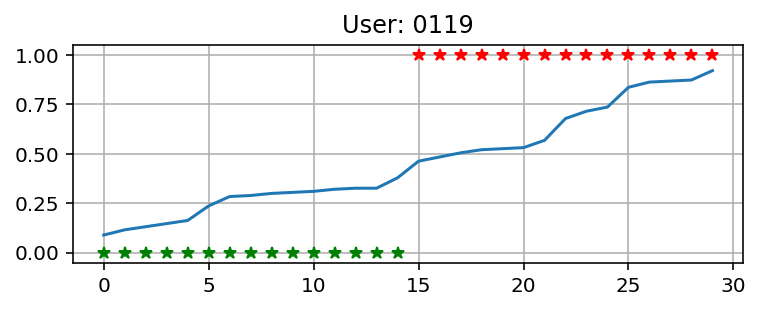

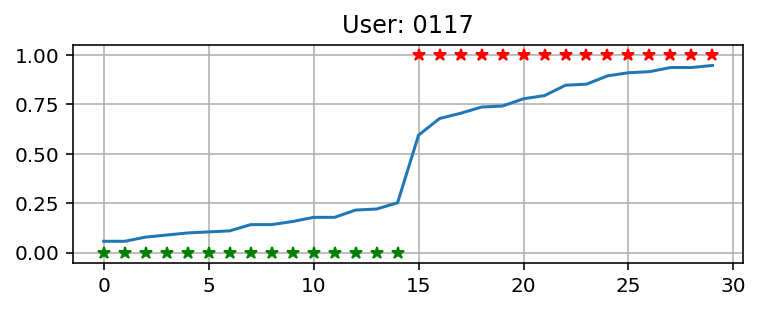

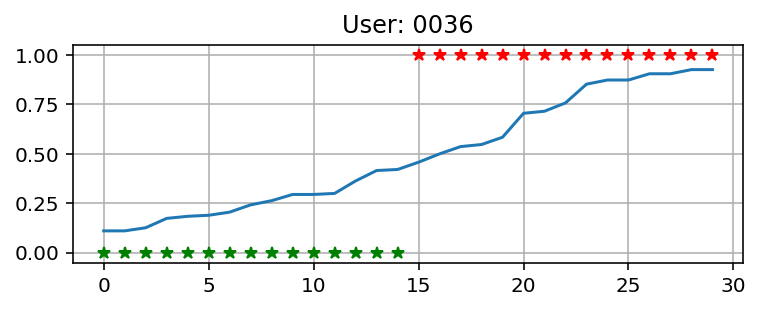

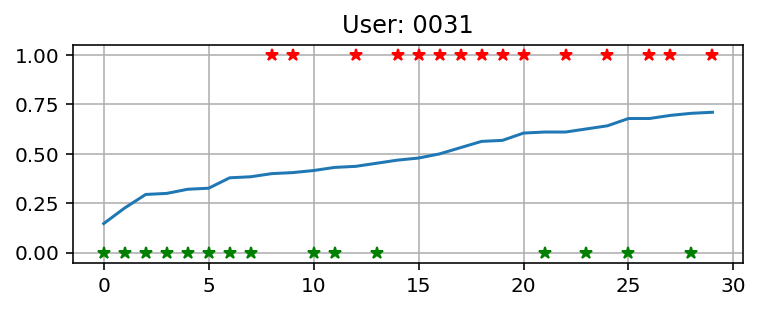

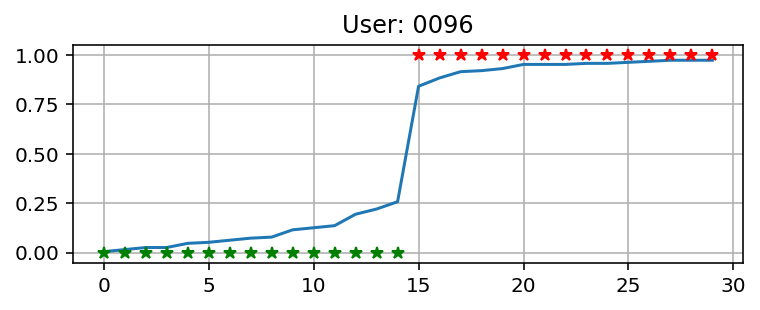

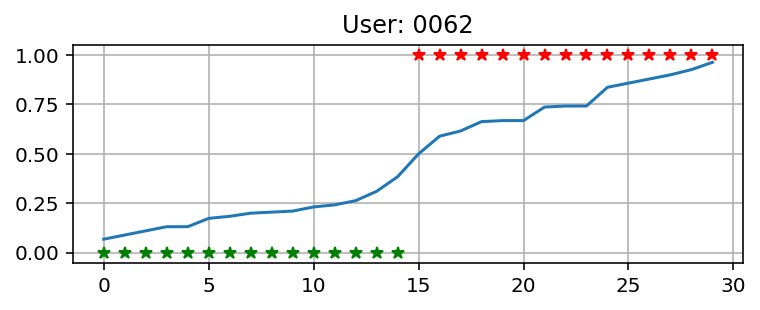

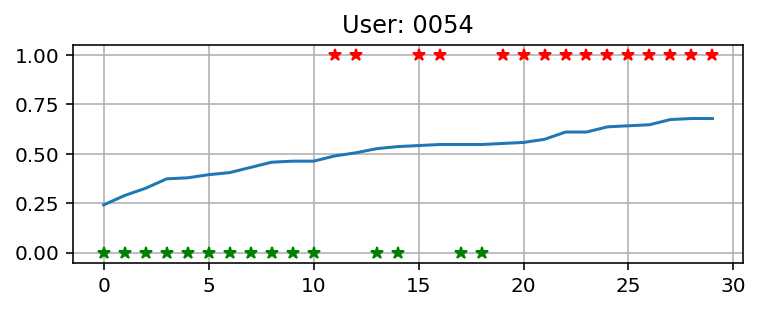

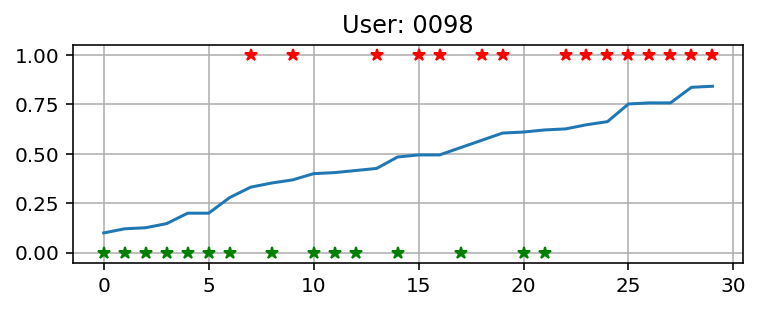

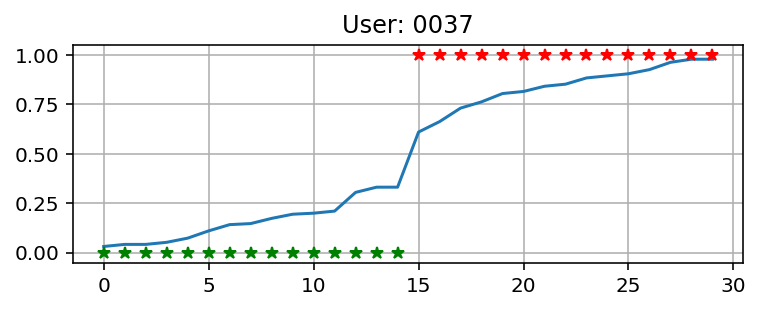

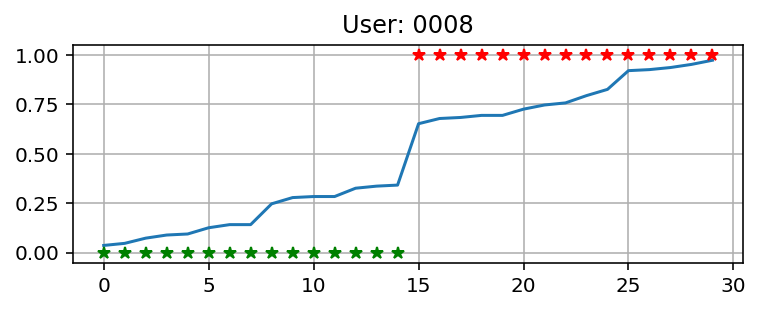

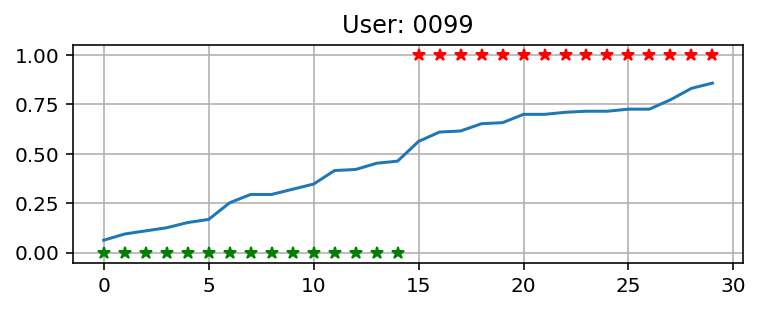

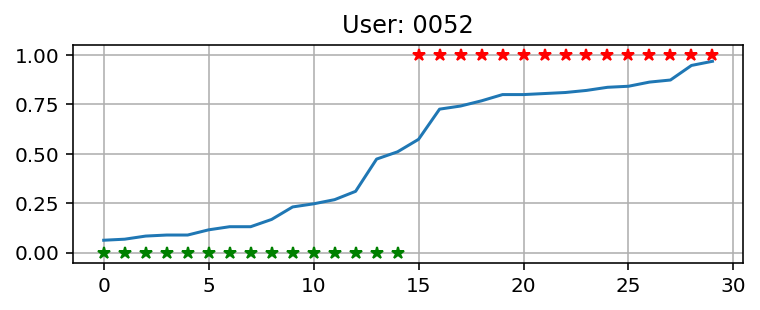

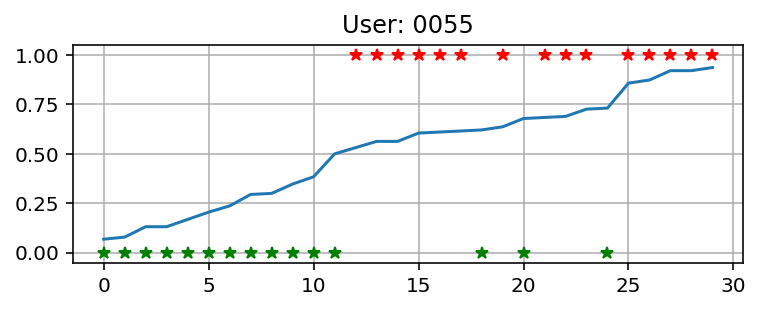

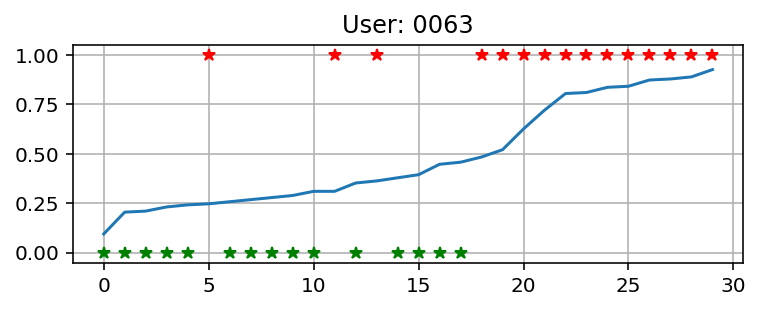

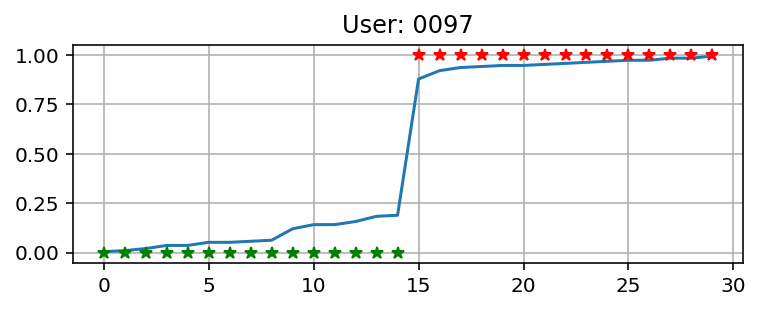

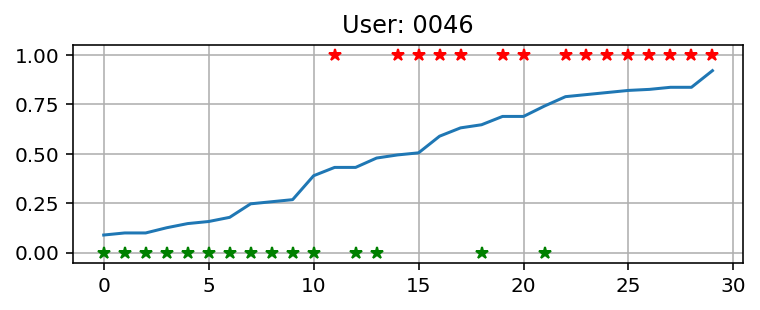

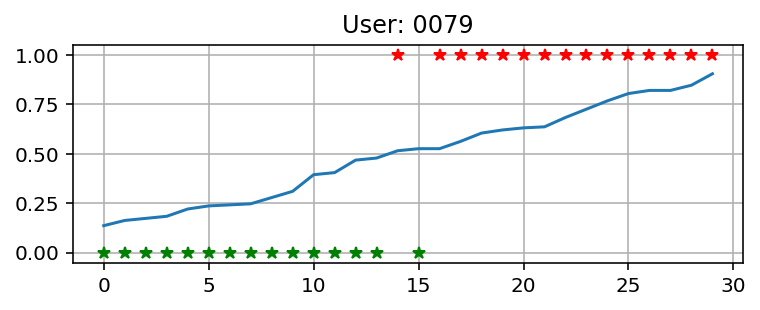

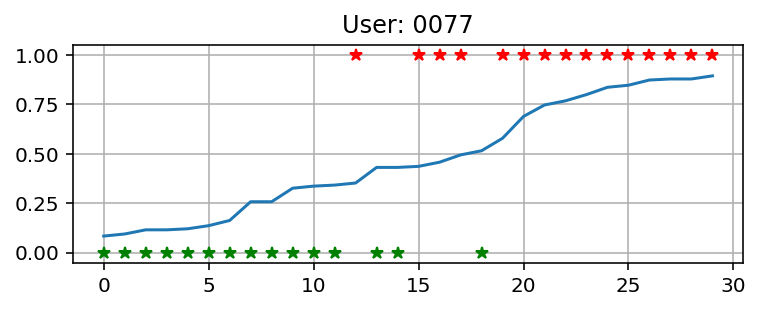

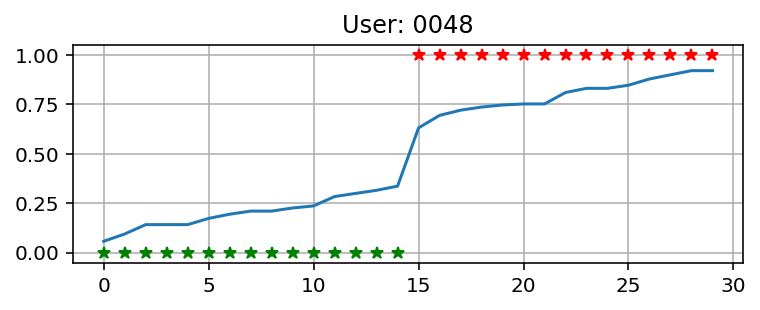

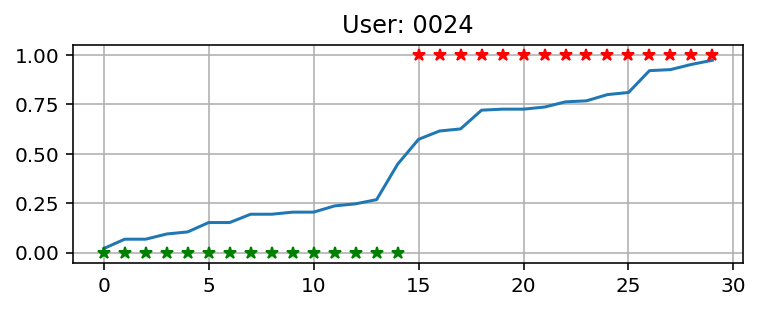

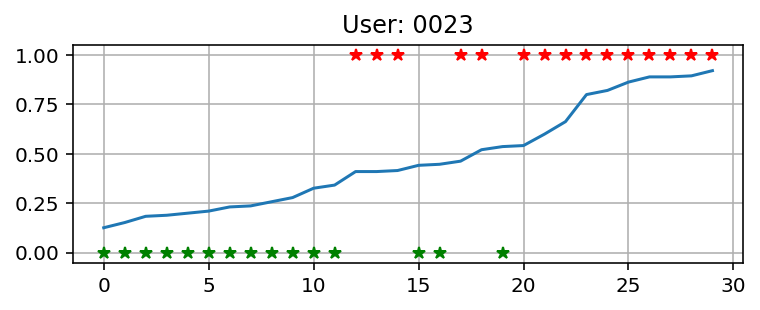

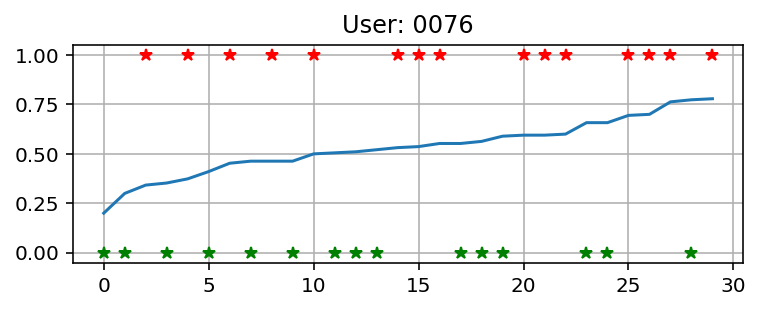

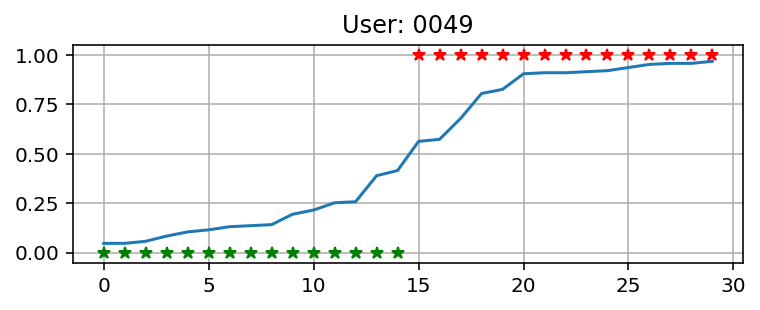

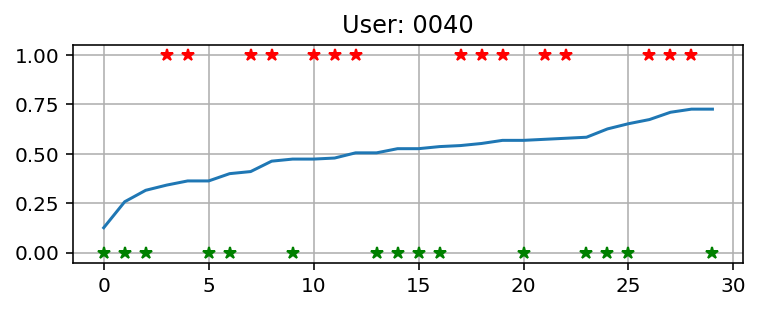

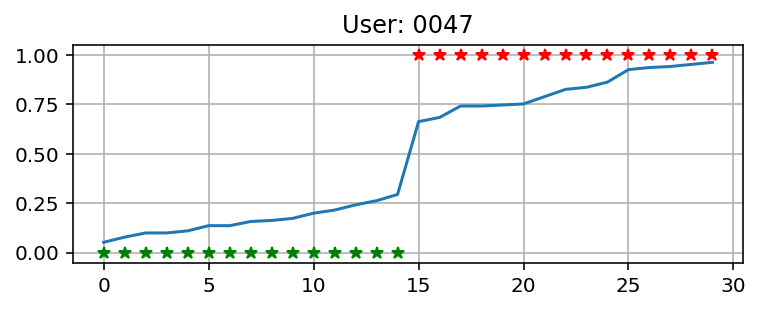

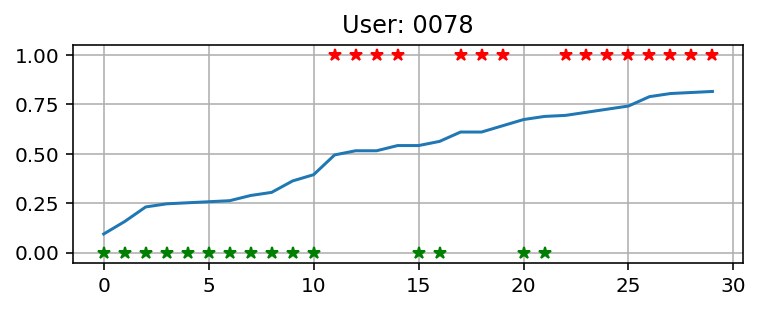

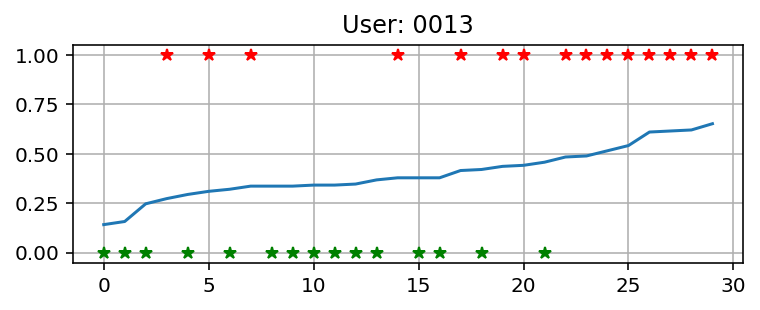

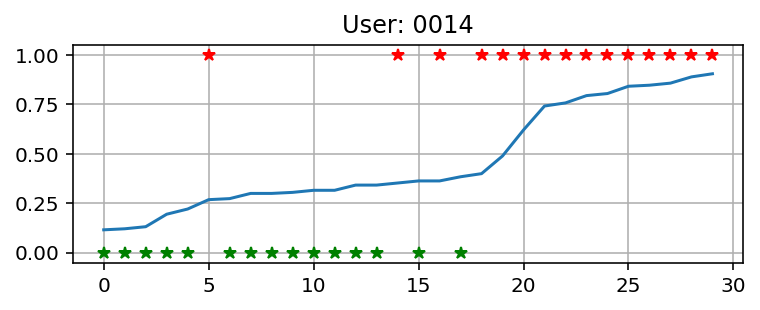

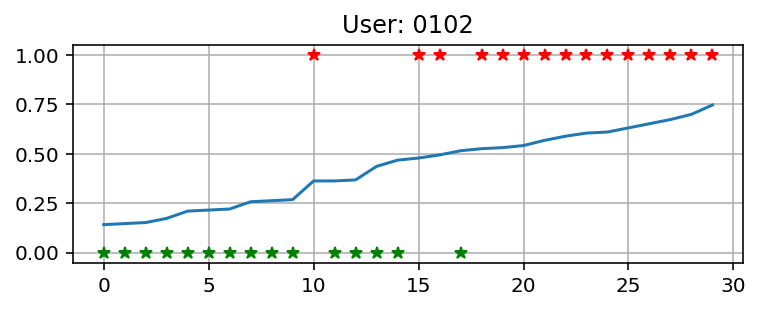

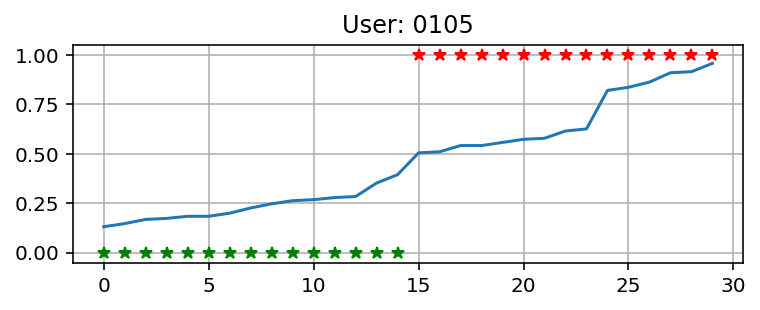

In [19]:
V25 = {}
model = skelm.ELMClassifier(alpha=10**1.0, n_neurons=10000, batch_size=10000)

for usr in users:
    res = process_user(usr, model, overlap='25p')
    V25[usr] = res
    
    plt.figure(figsize=(6, 2))
    plt.plot(res[:, 2])
    i0 = np.where(res[:, 1] == 0)[0]
    plt.plot(i0, [0]*len(i0), "*g")

    i1 = np.where(res[:, 1] == 1)[0]
    plt.plot(i1, [1]*len(i1), "*r")
    plt.title("User: "+usr)
    plt.grid()
    plt.show()

# 50p

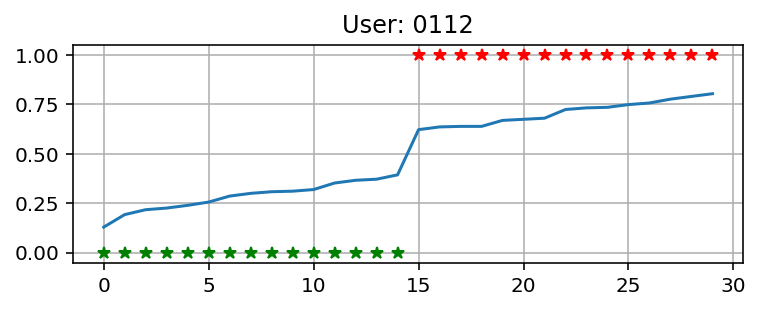

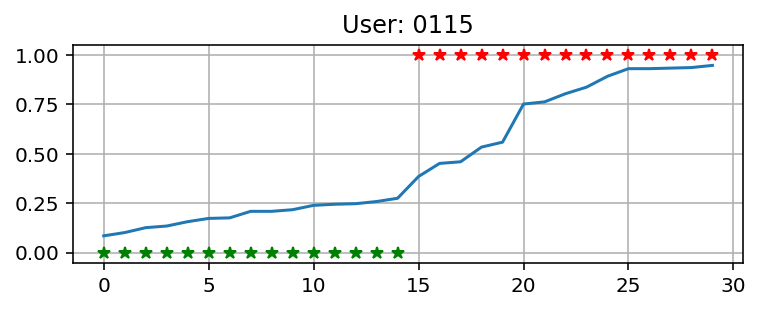

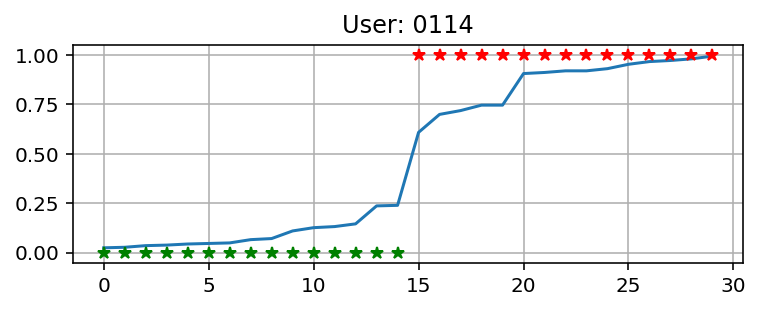

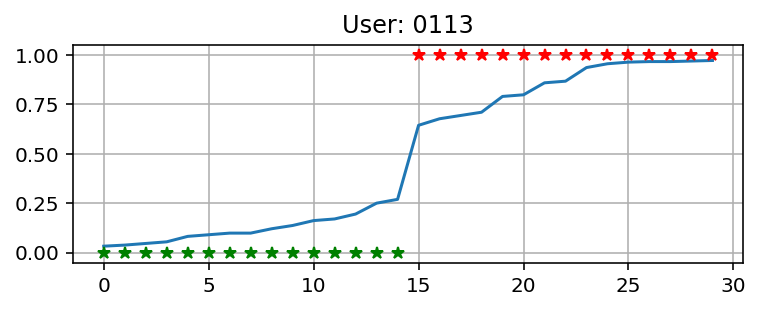

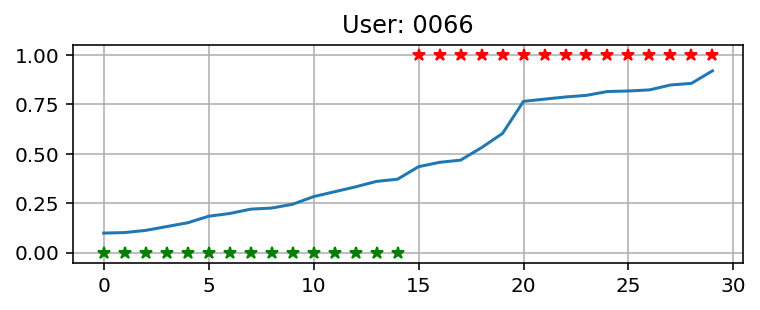

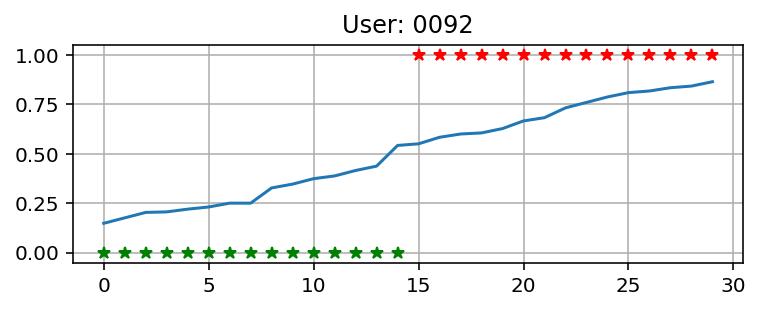

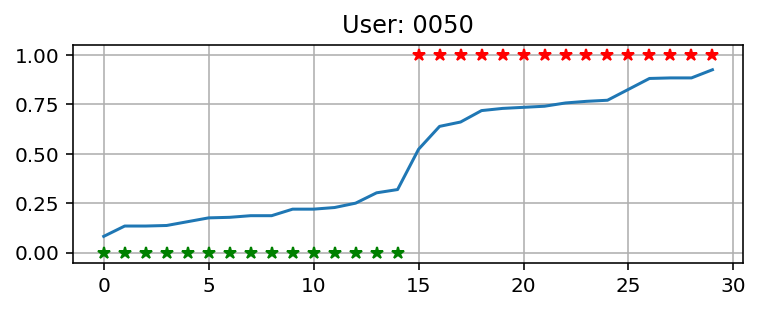

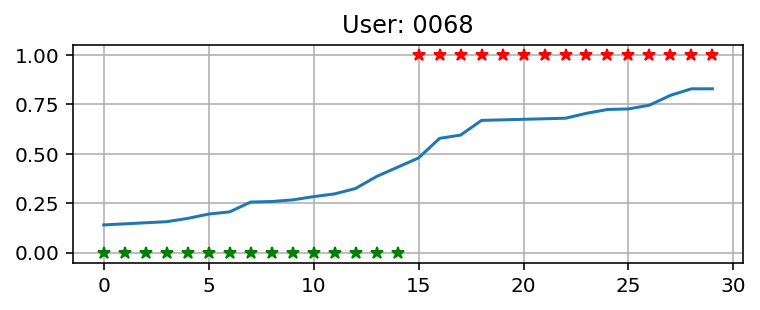

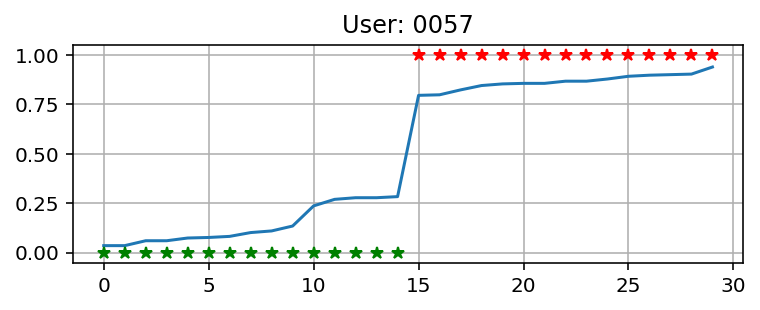

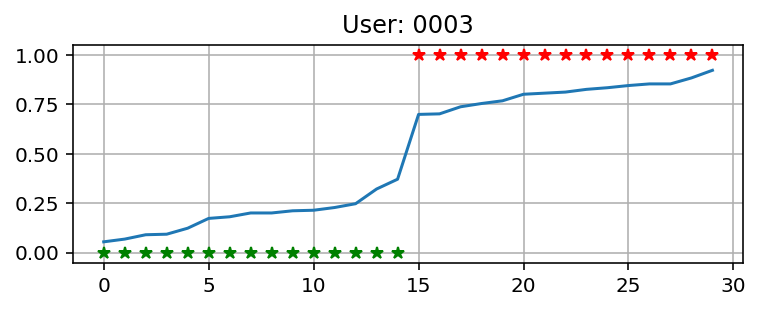

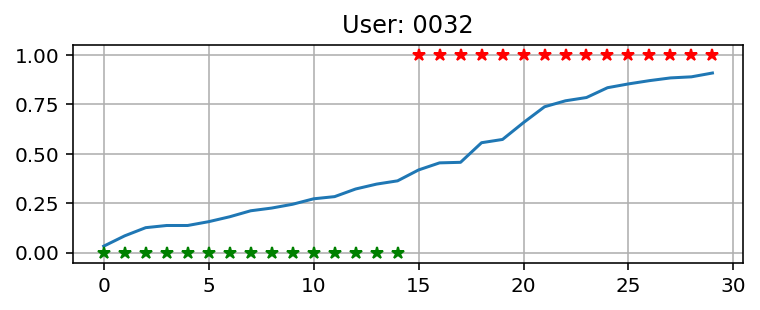

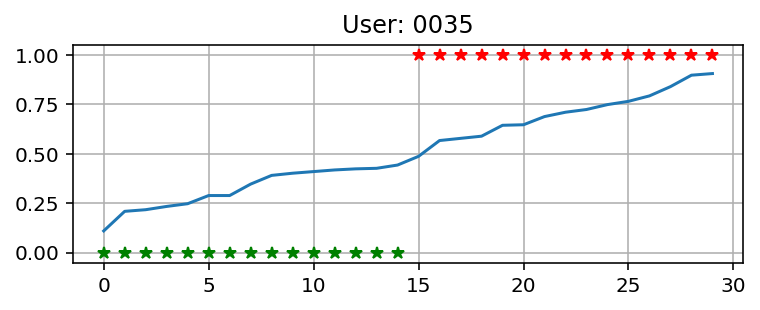

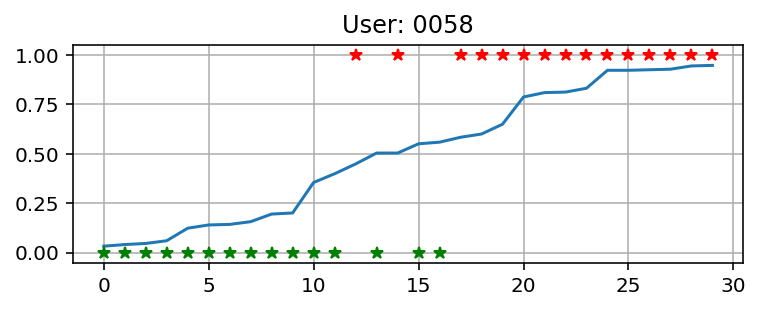

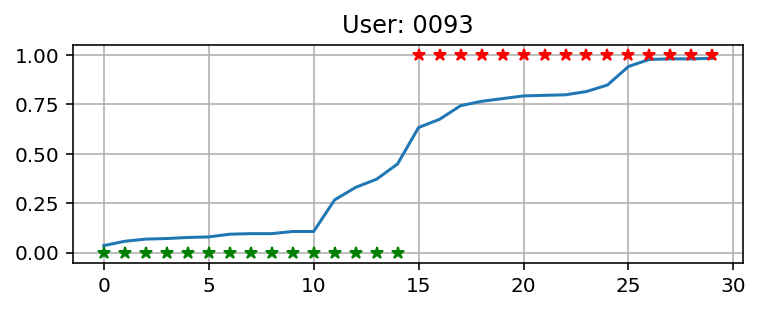

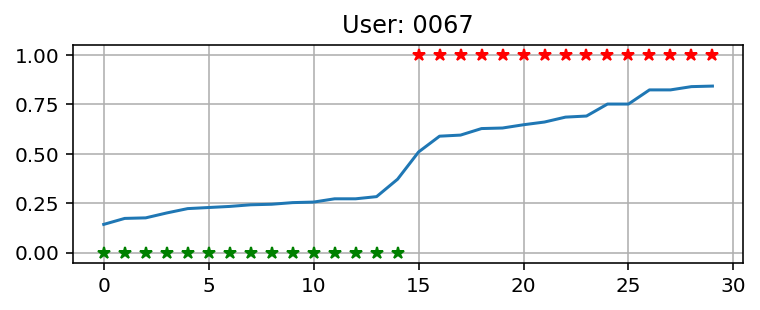

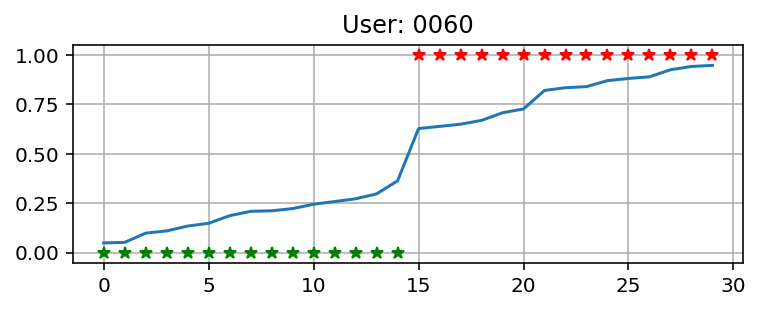

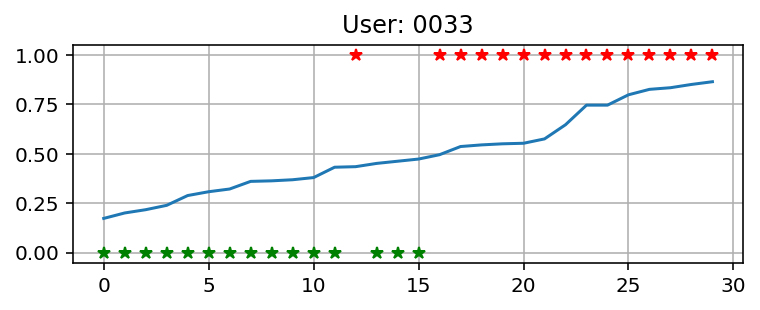

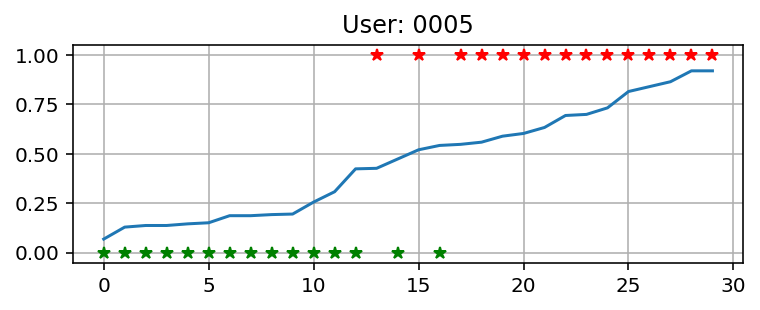

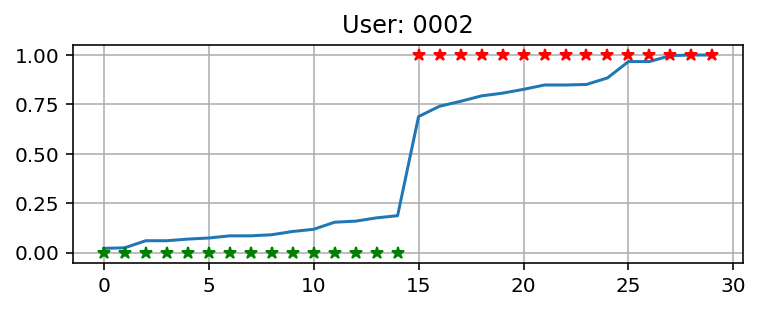

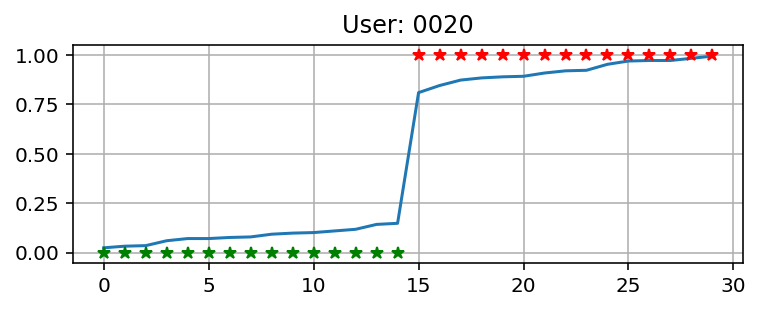

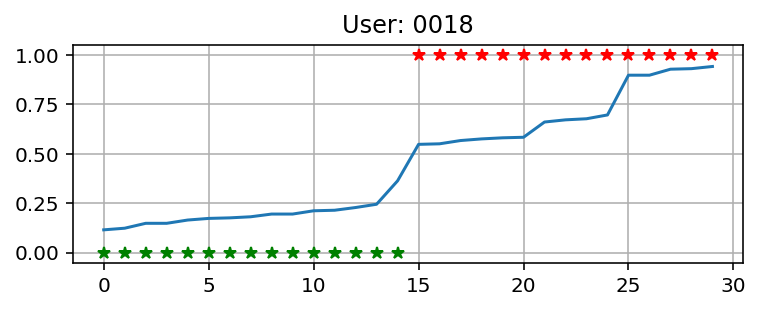

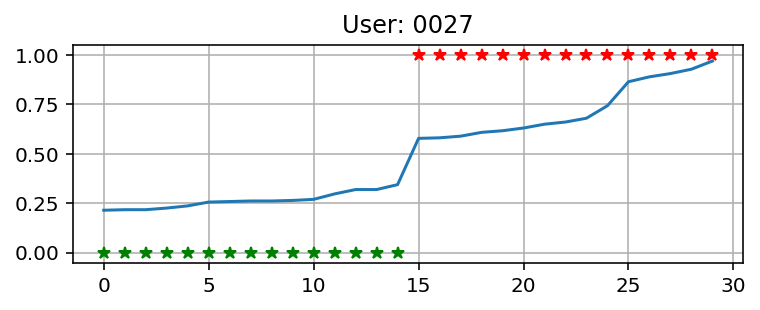

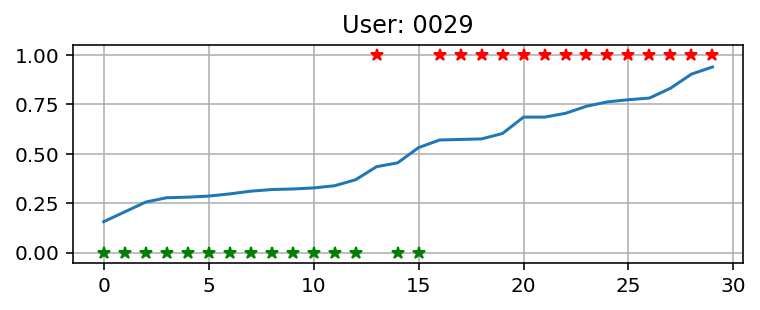

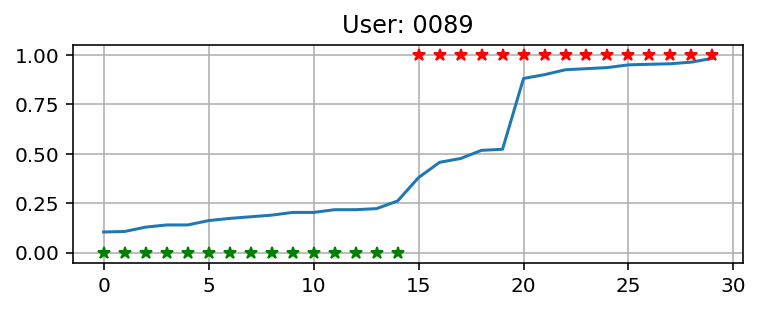

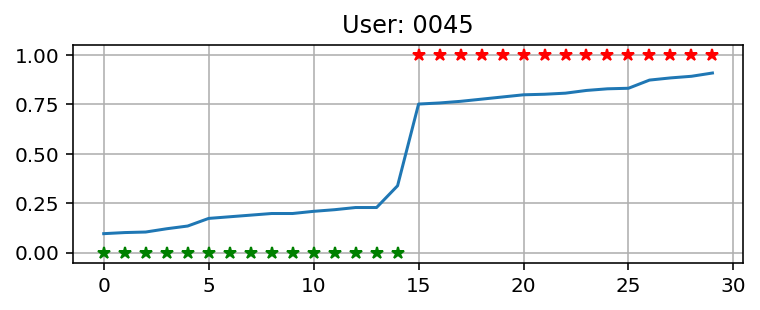

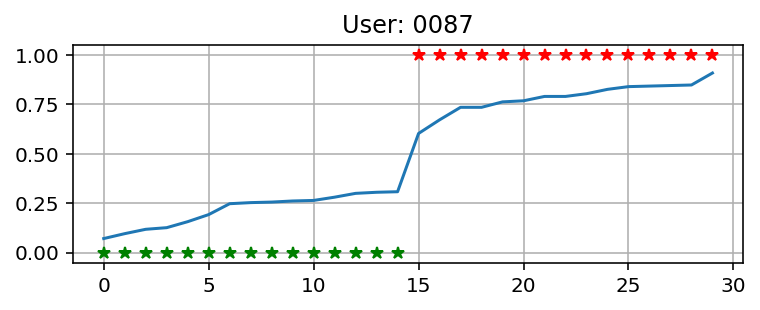

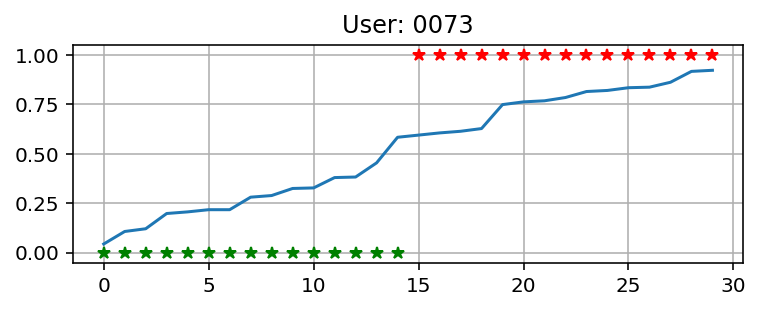

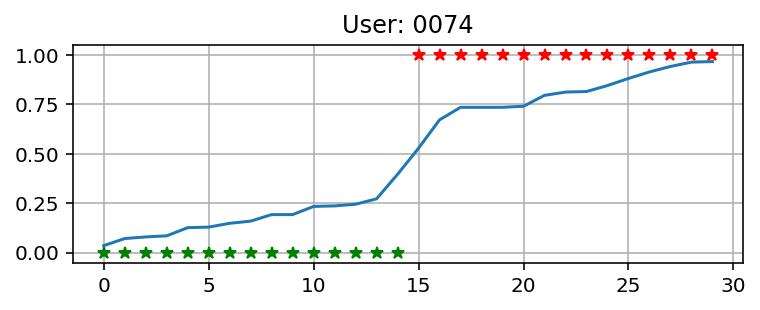

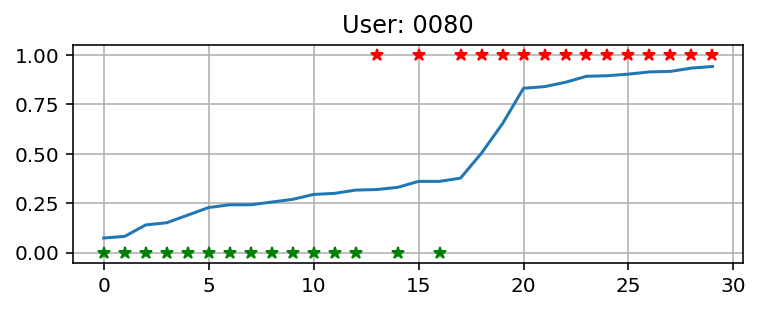

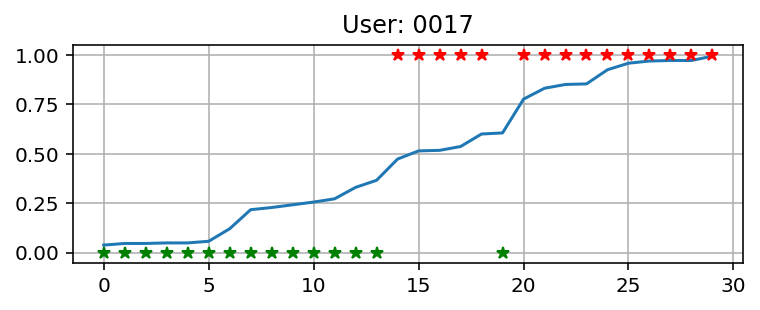

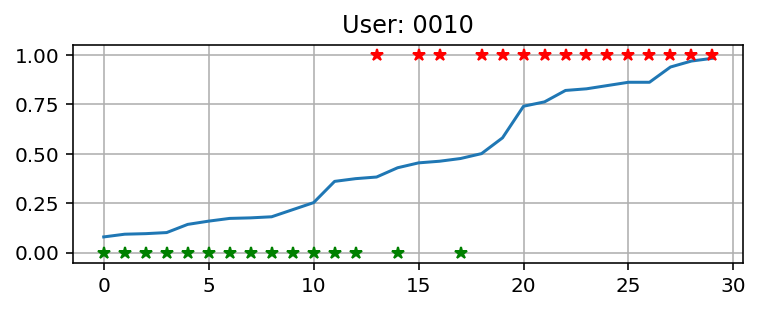

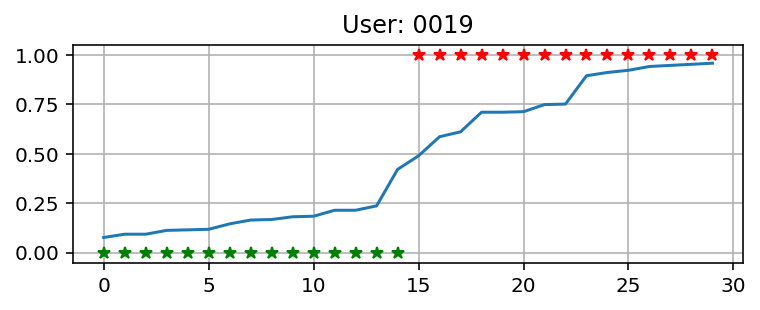

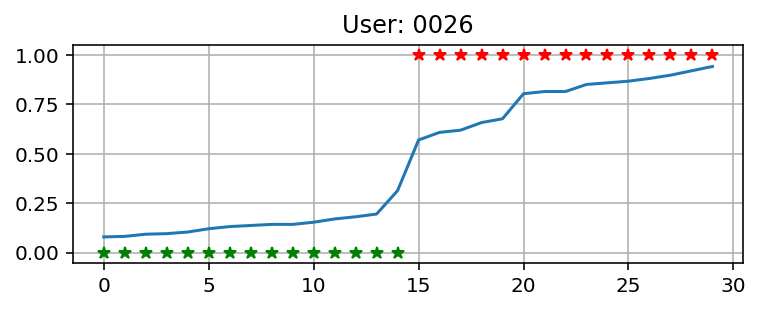

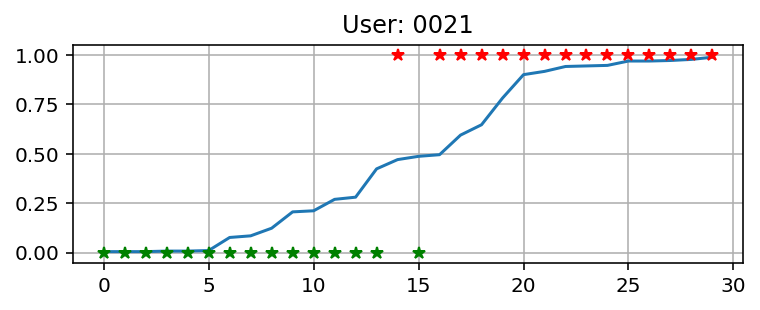

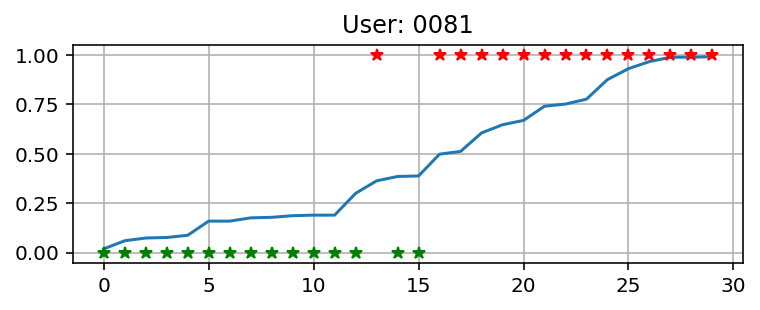

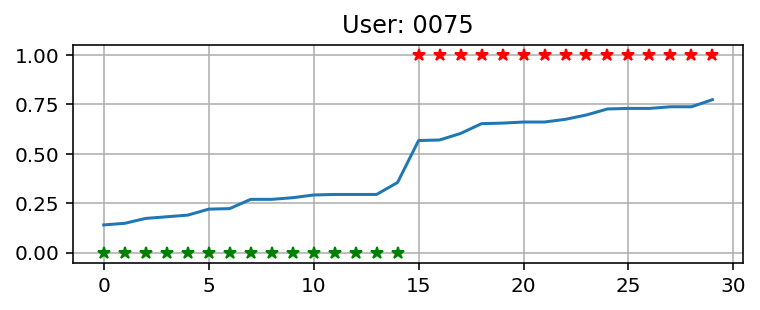

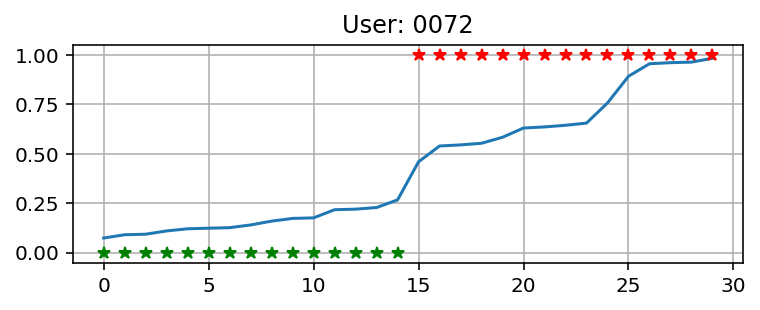

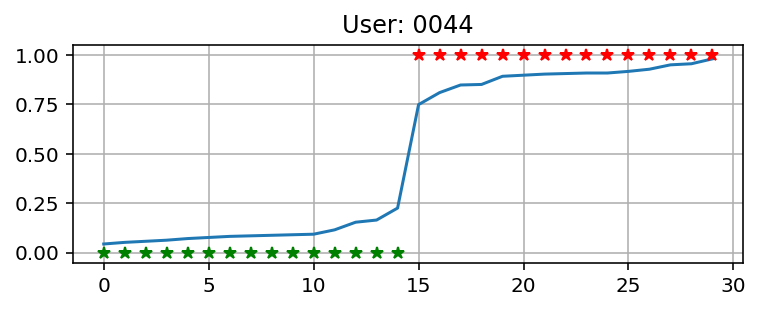

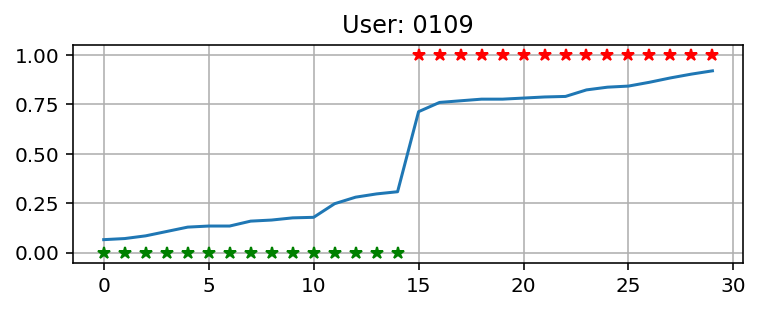

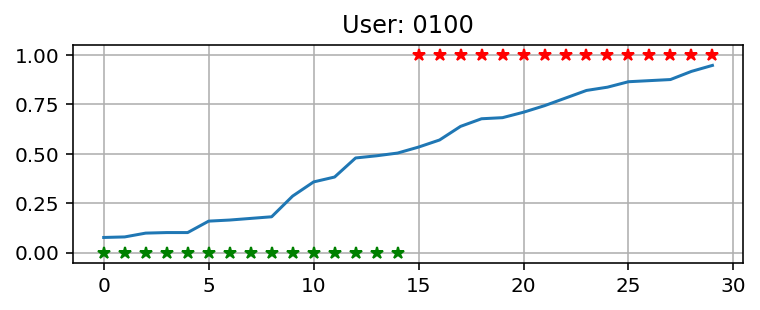

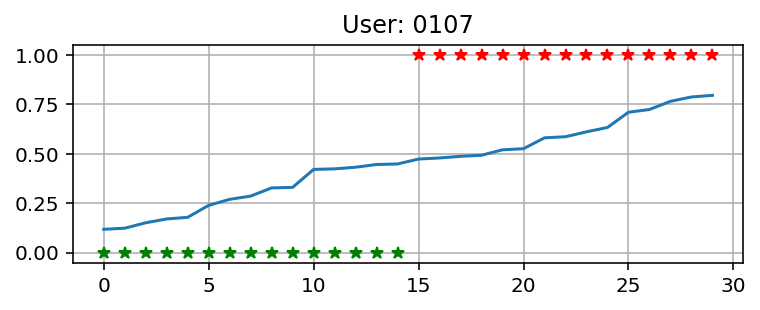

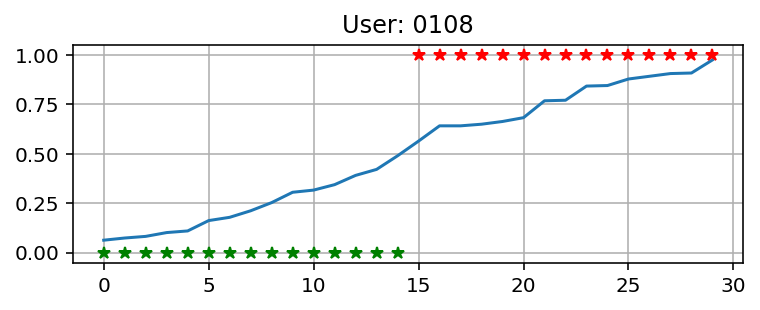

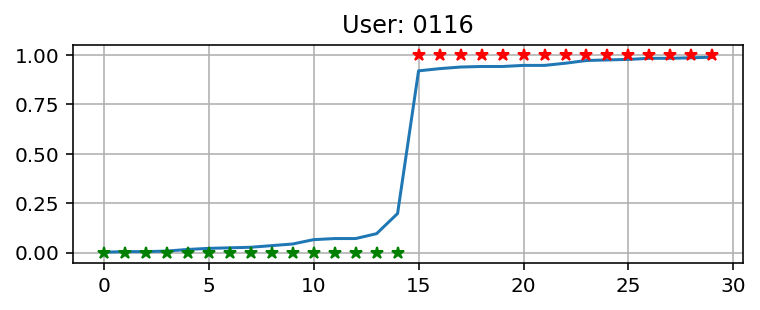

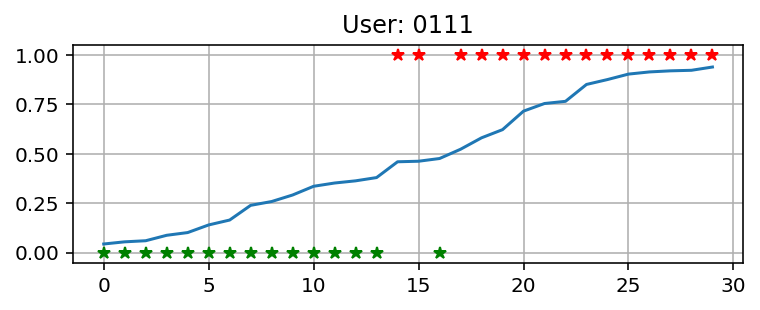

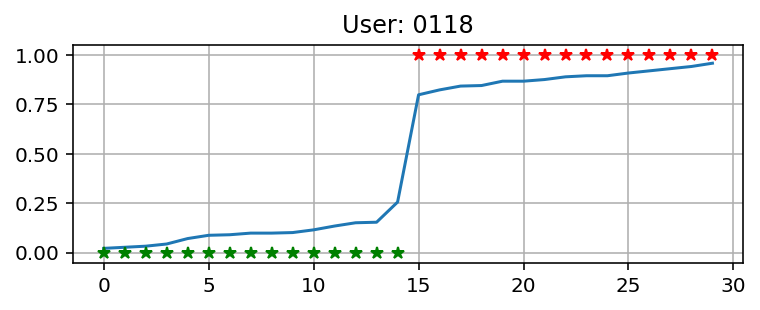

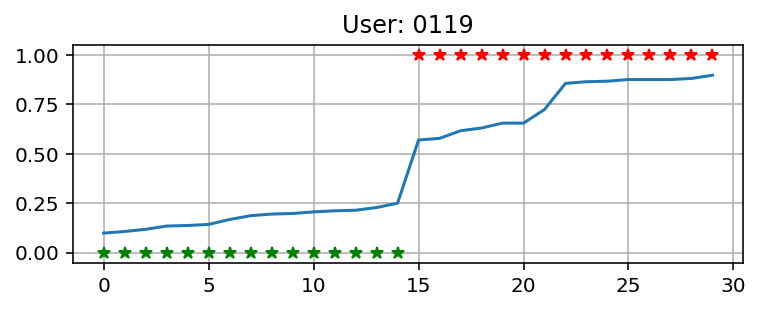

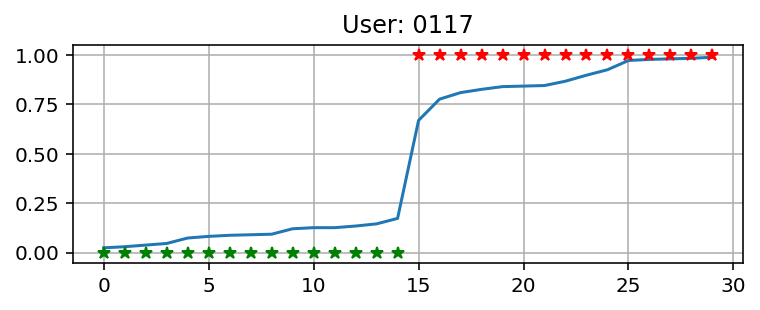

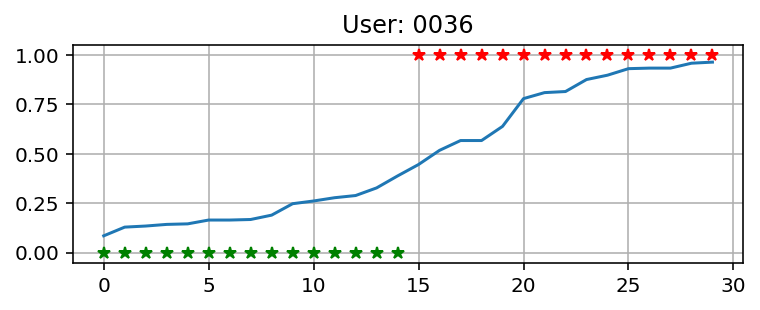

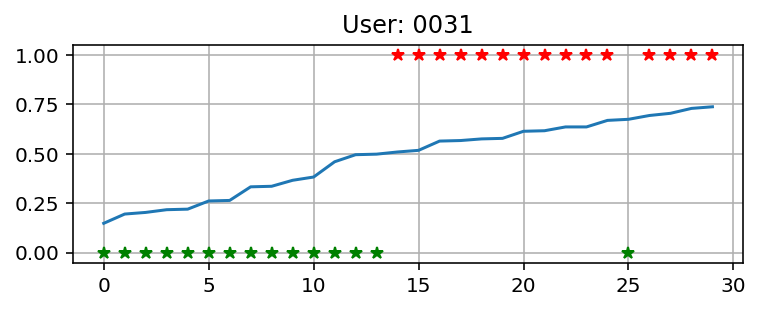

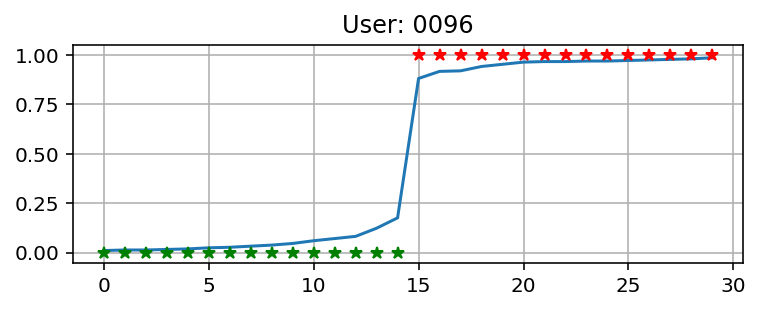

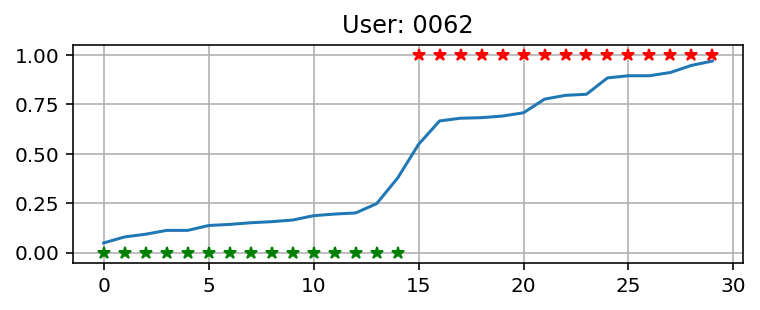

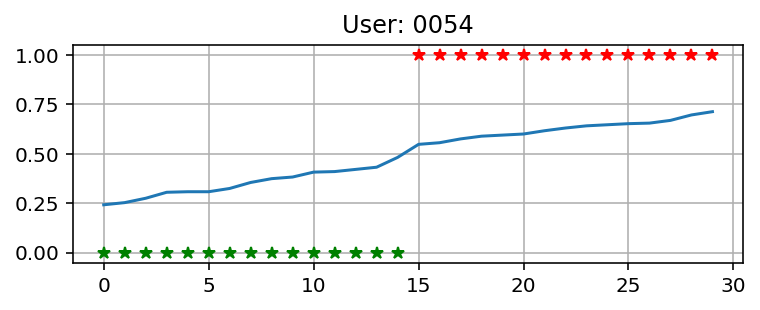

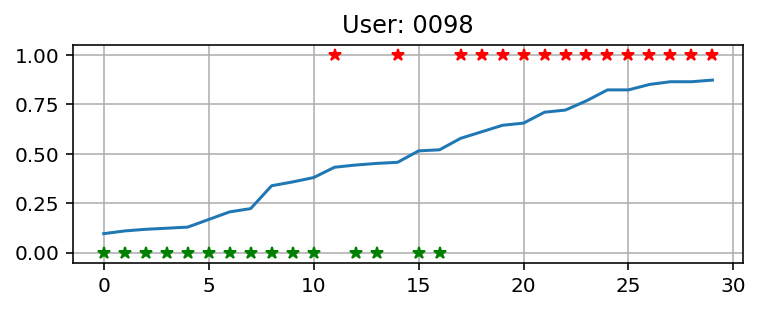

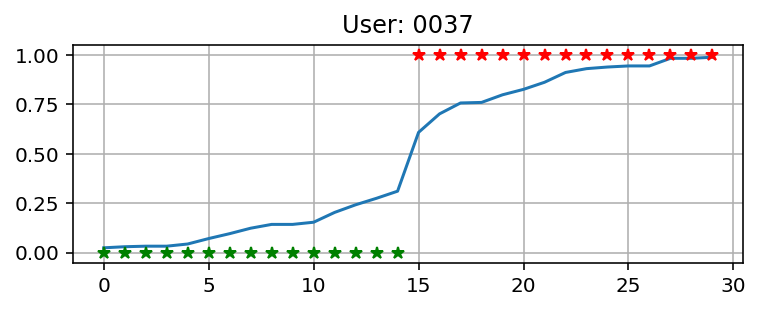

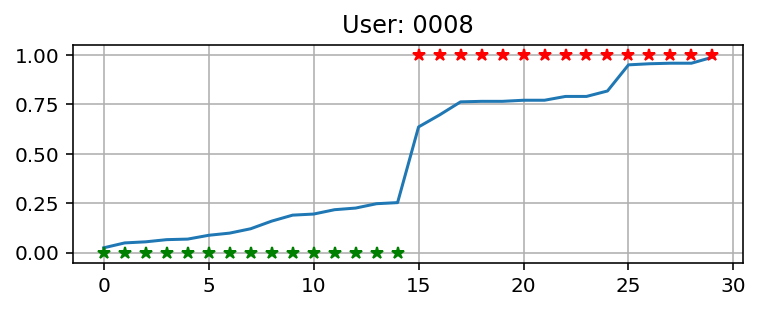

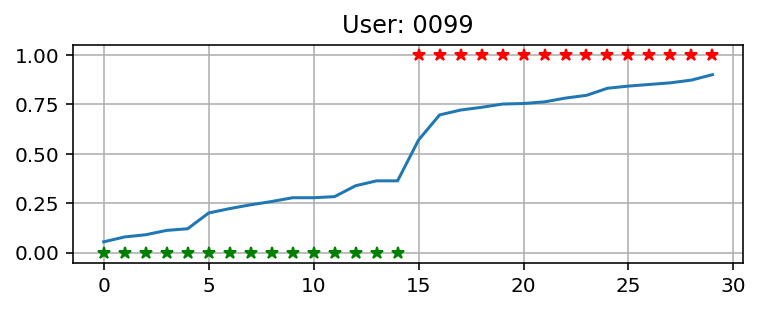

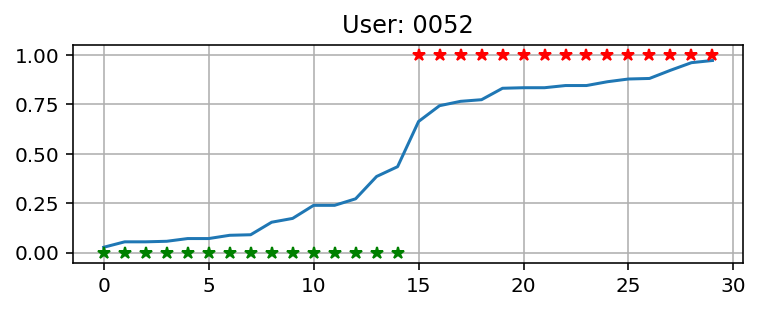

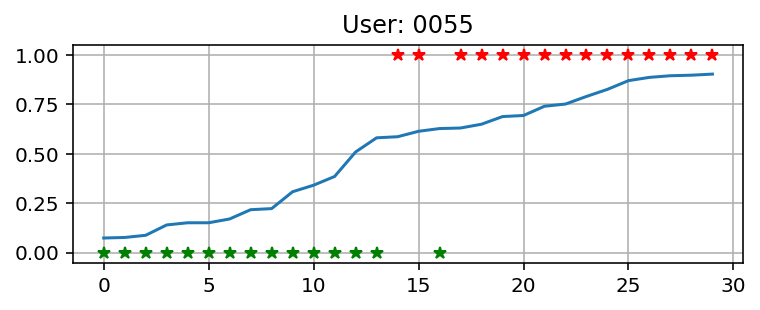

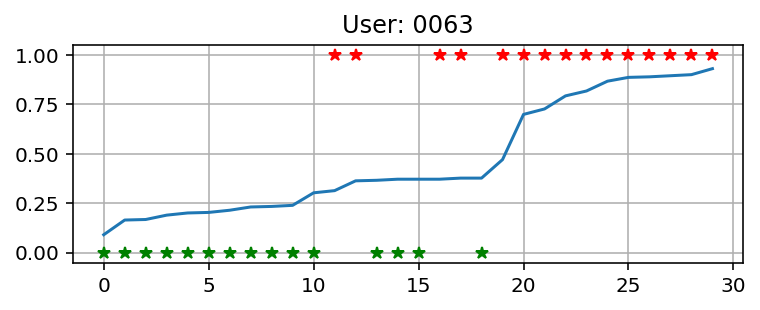

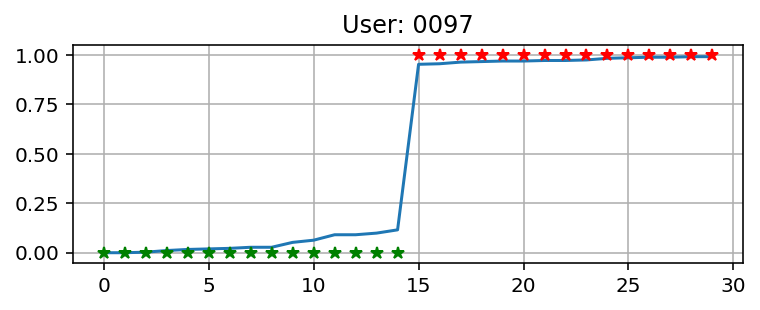

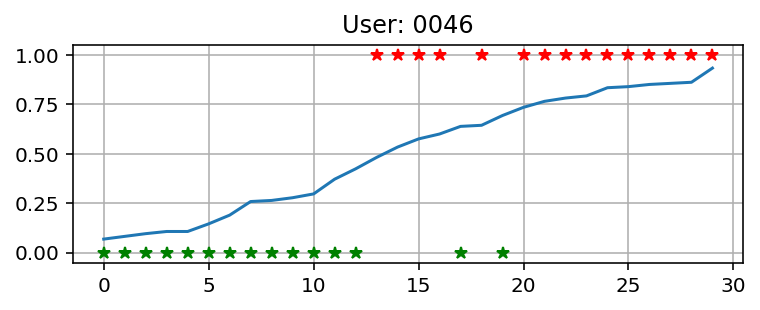

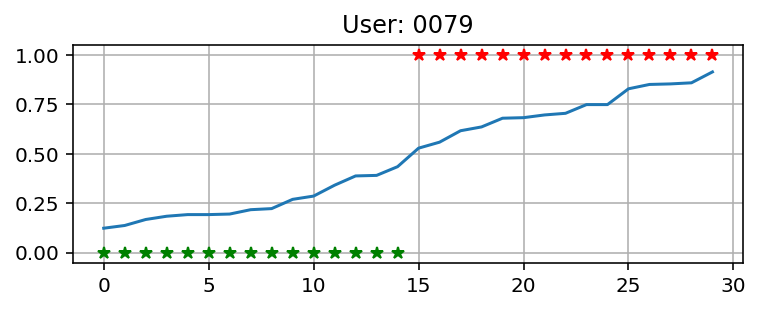

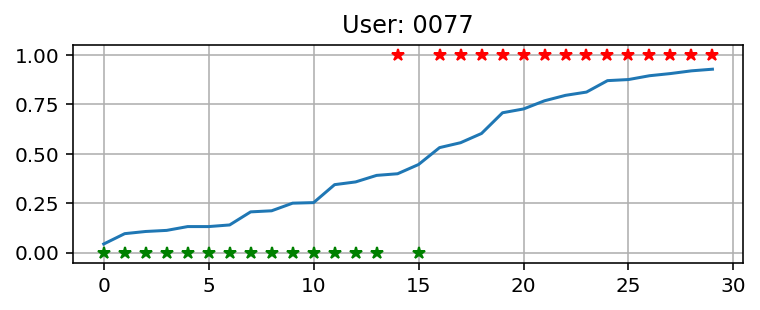

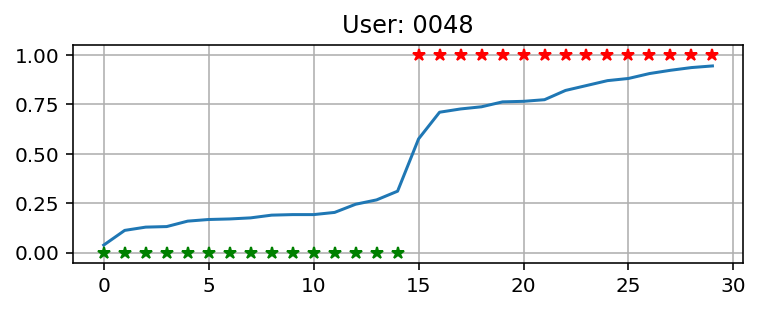

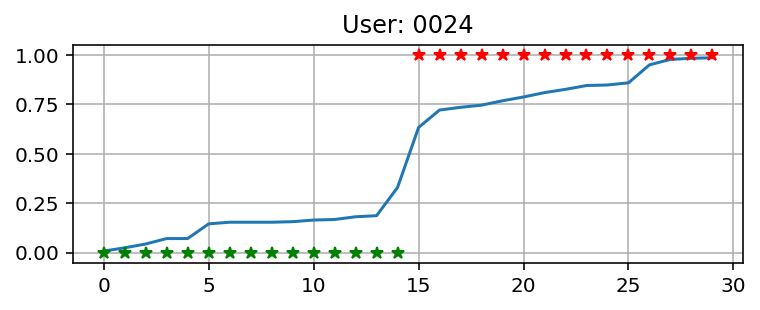

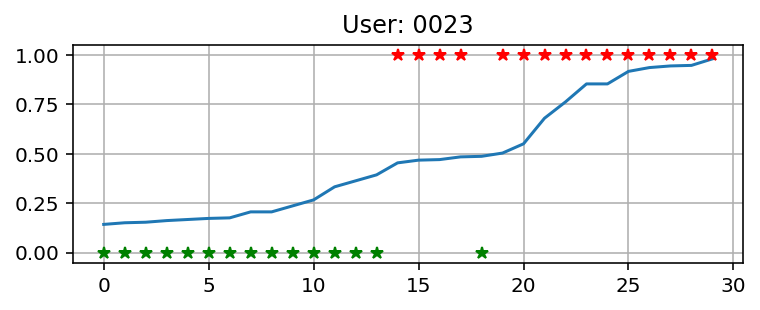

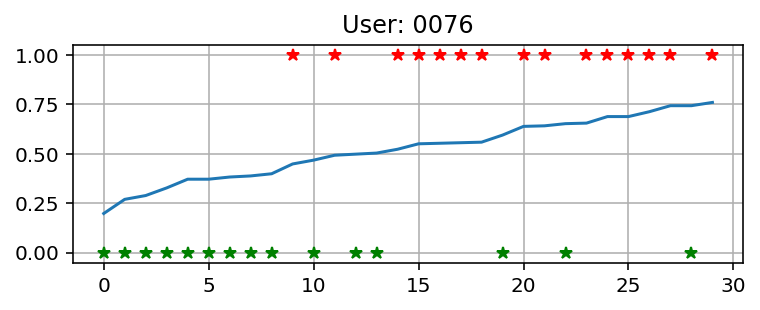

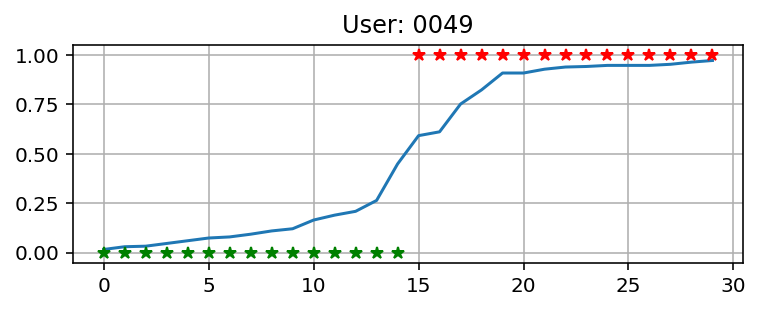

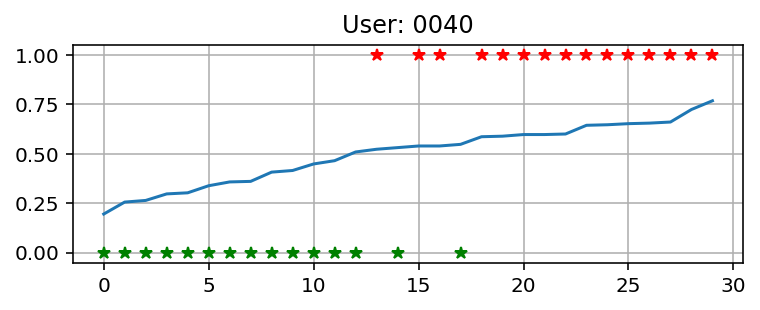

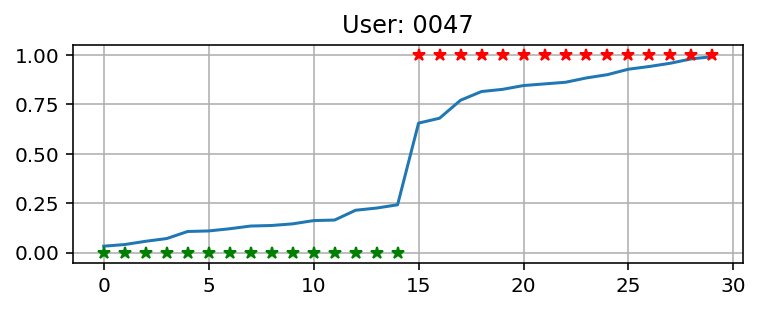

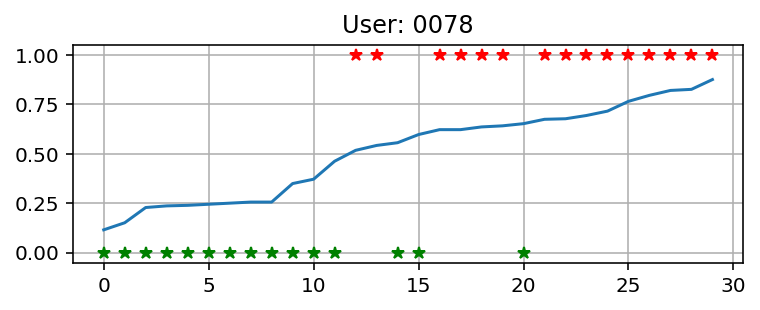

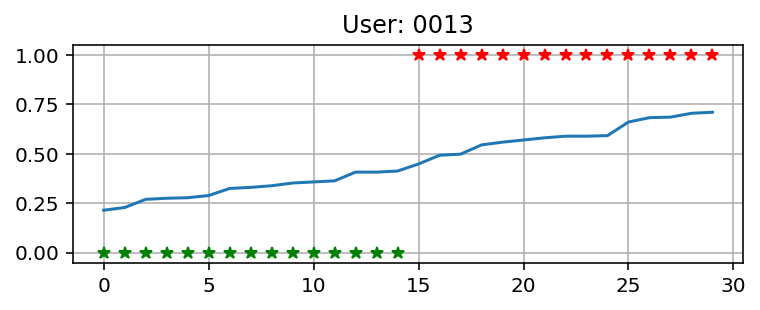

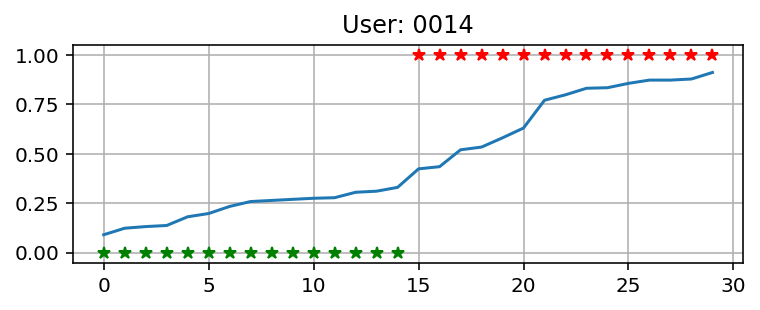

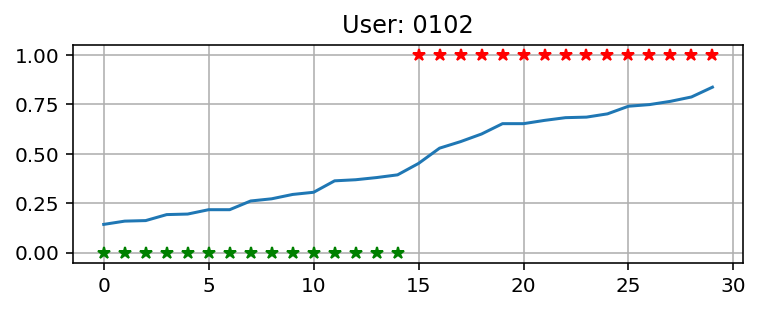

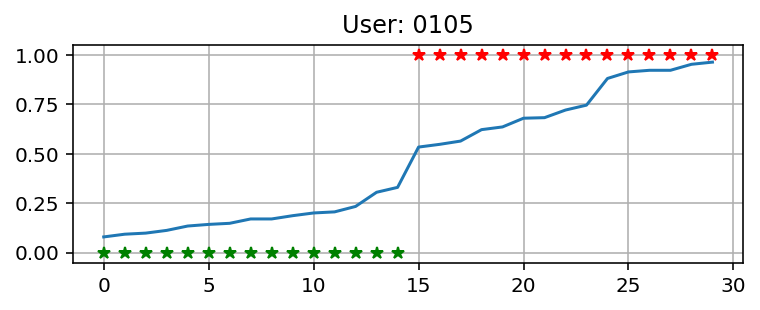

In [20]:
V50 = {}
model = skelm.ELMClassifier(alpha=10**0.8, n_neurons=10000, batch_size=10000)

for usr in users:
    res = process_user(usr, model, overlap='50p')
    V50[usr] = res
    
    plt.figure(figsize=(6, 2))
    plt.plot(res[:, 2])
    i0 = np.where(res[:, 1] == 0)[0]
    plt.plot(i0, [0]*len(i0), "*g")

    i1 = np.where(res[:, 1] == 1)[0]
    plt.plot(i1, [1]*len(i1), "*r")
    plt.title("User: "+usr)
    plt.grid()
    plt.show()

# 90p

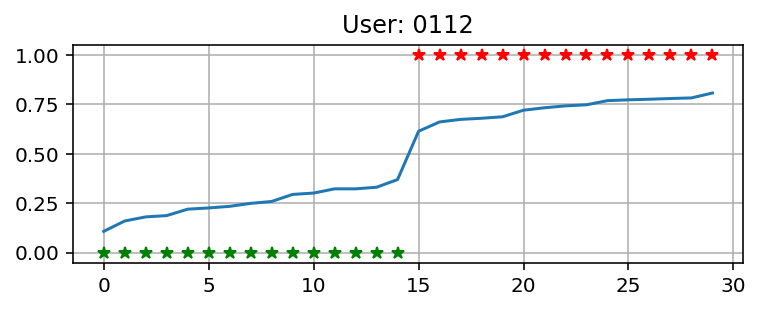

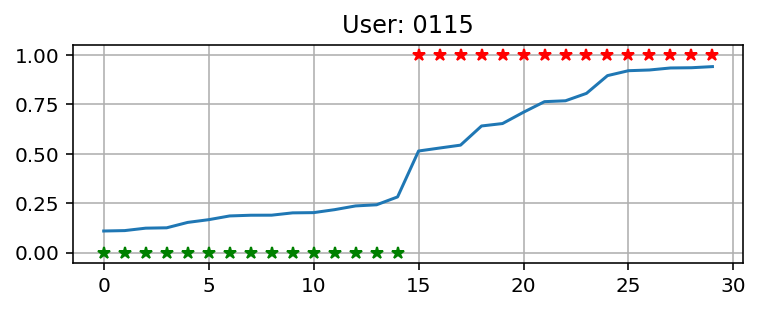

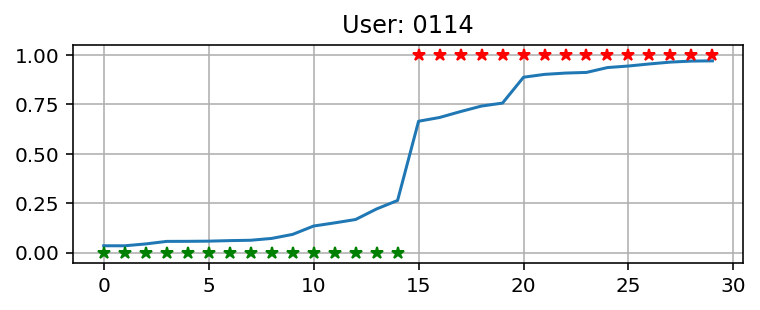

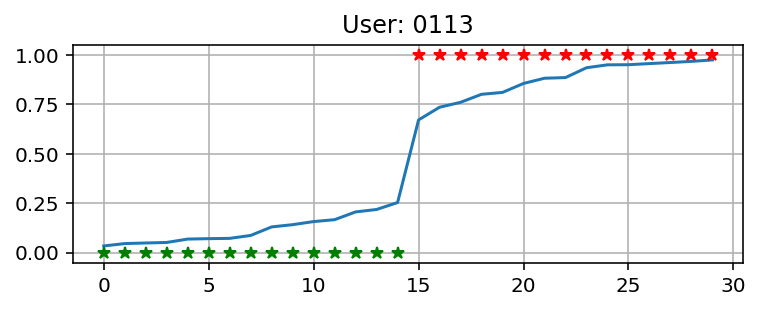

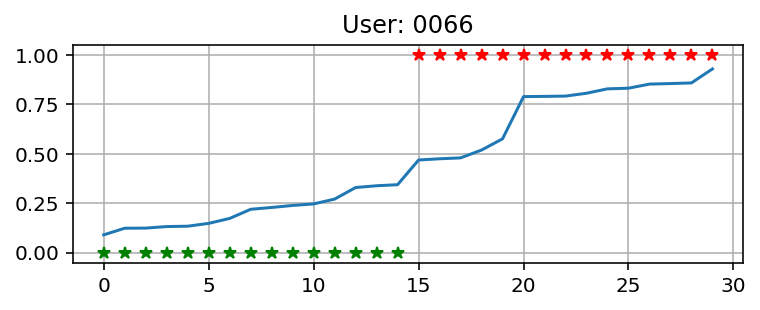

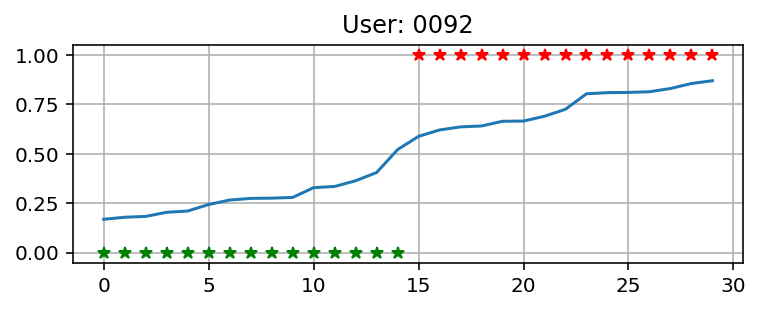

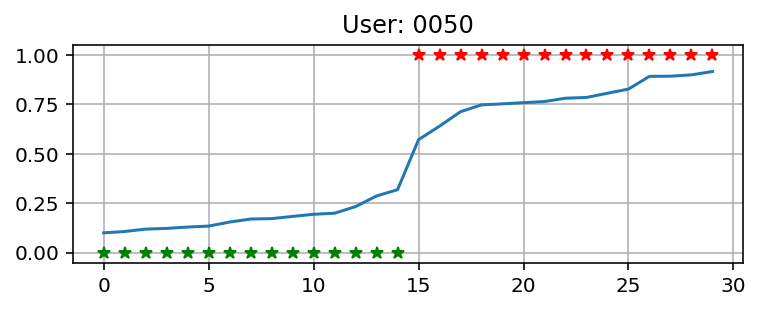

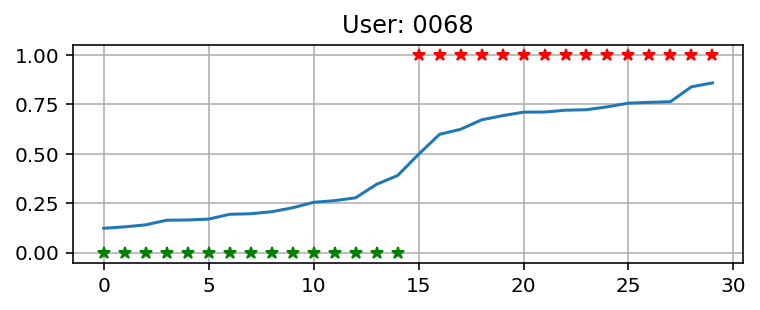

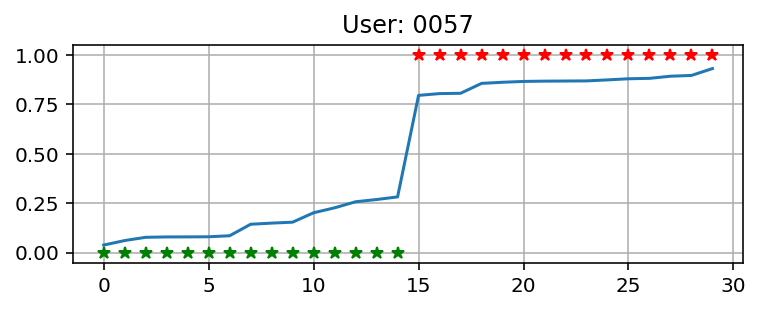

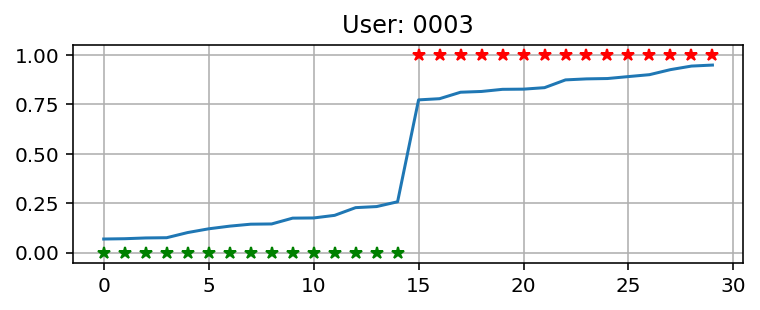

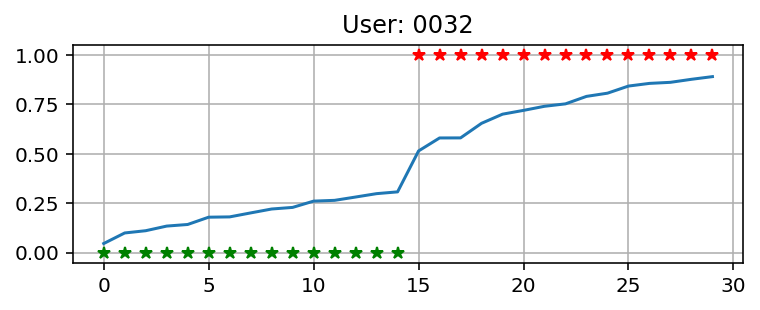

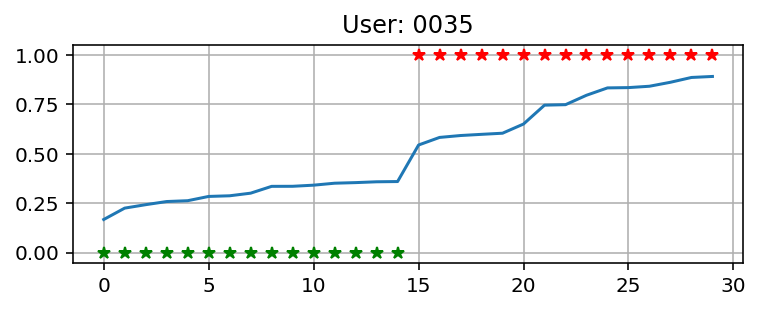

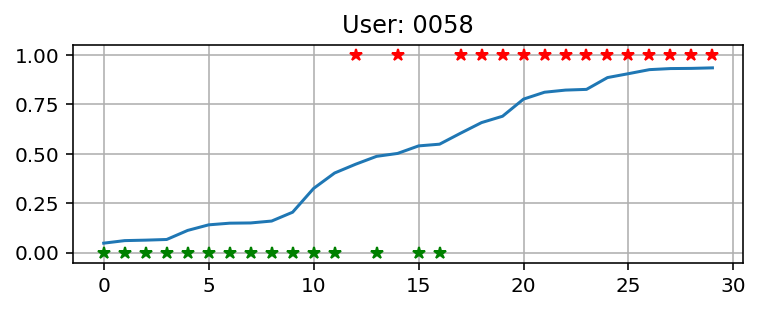

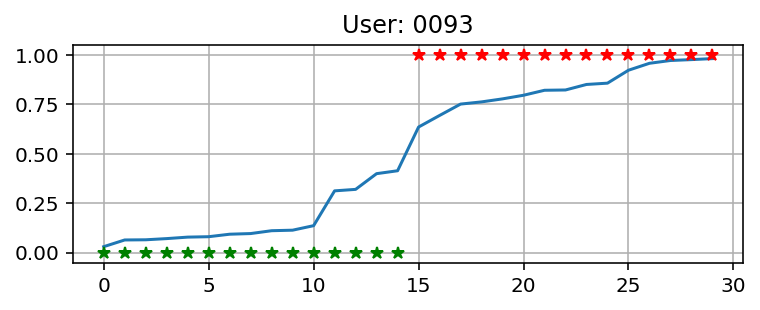

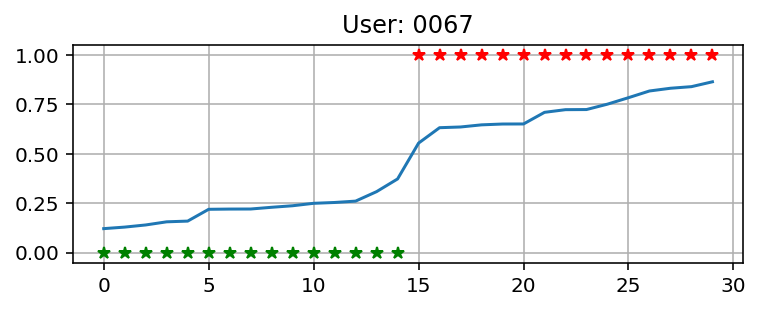

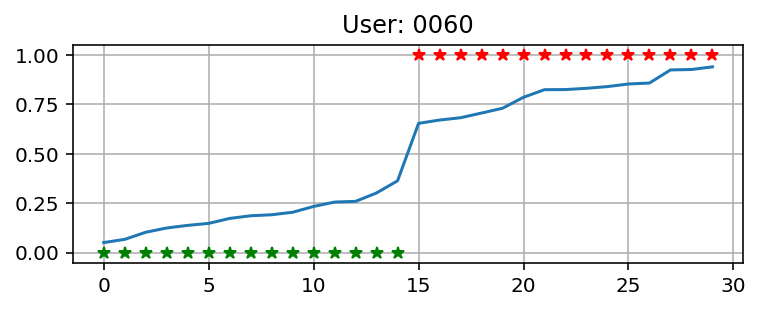

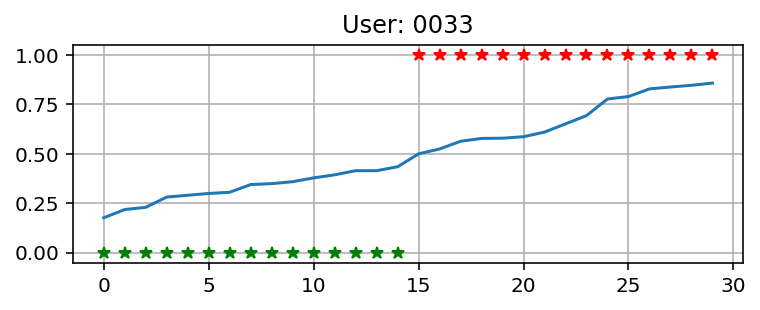

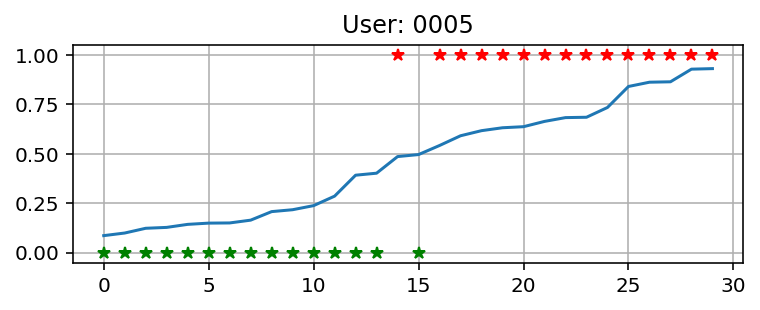

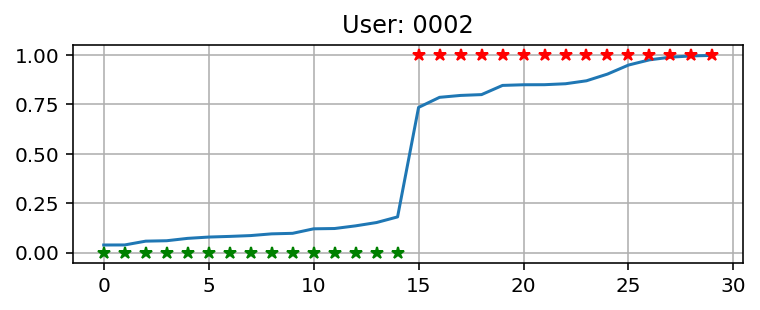

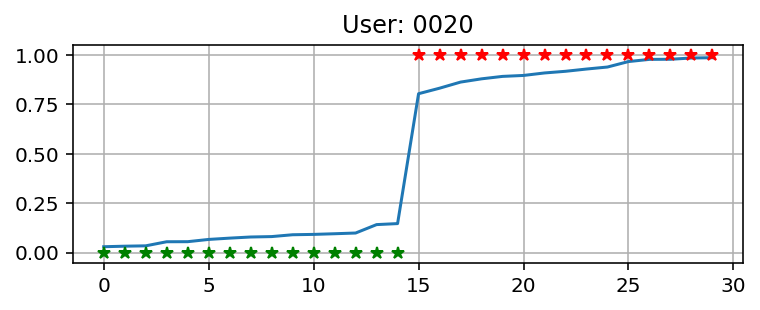

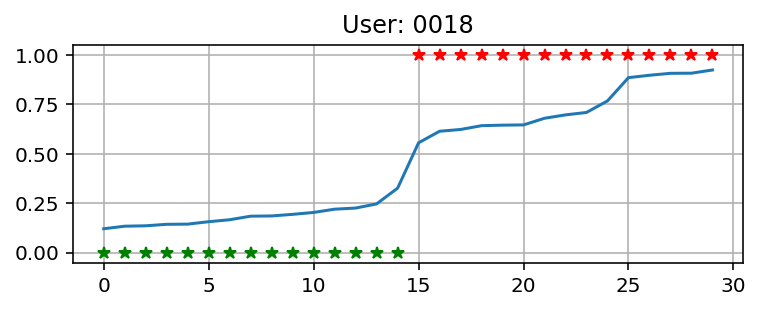

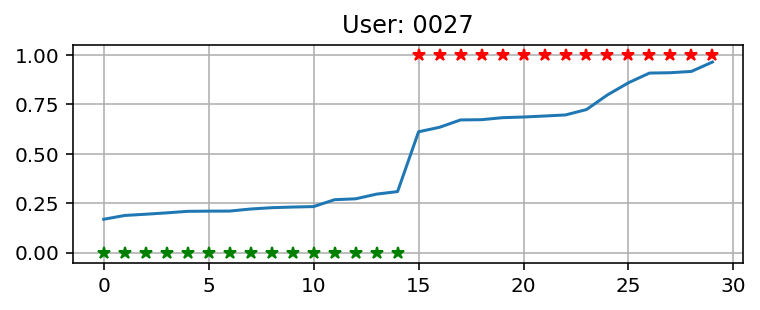

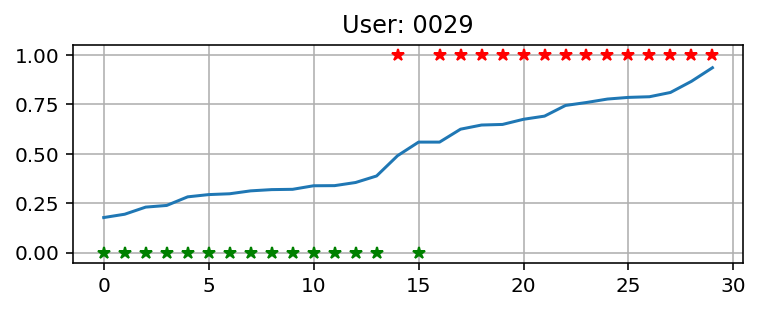

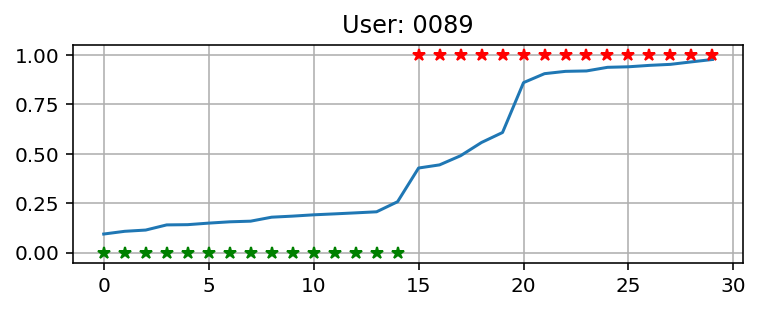

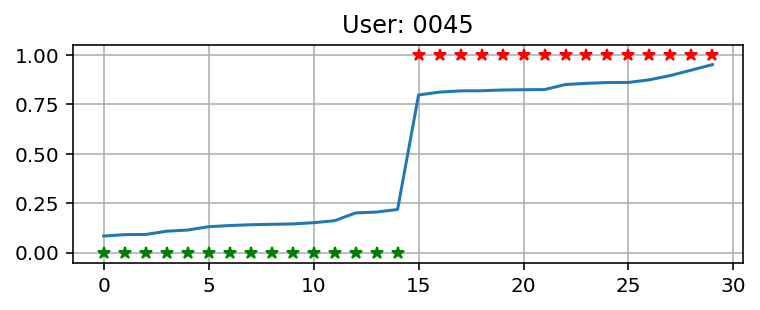

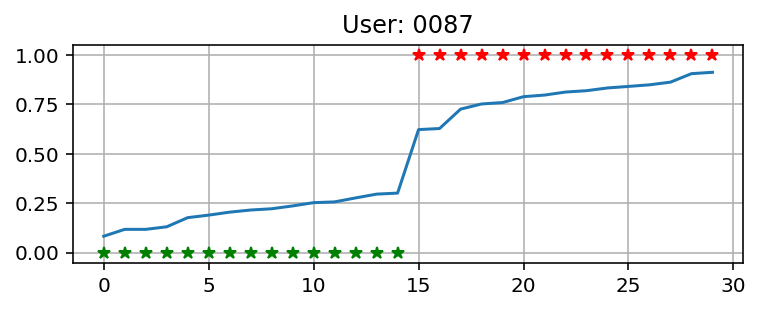

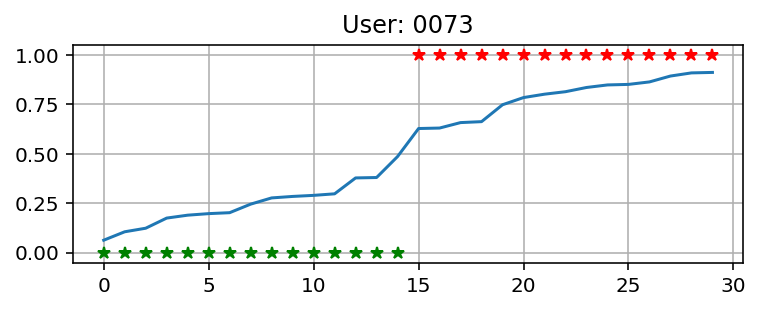

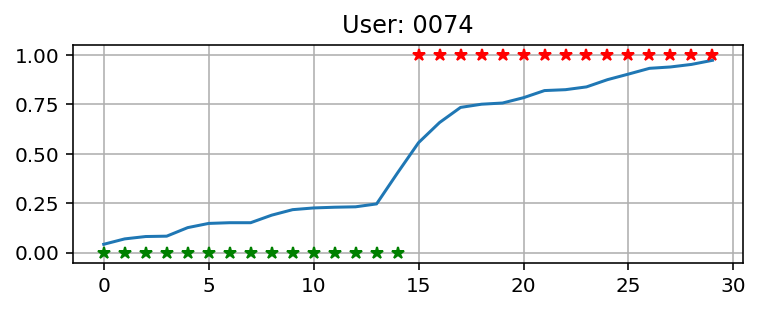

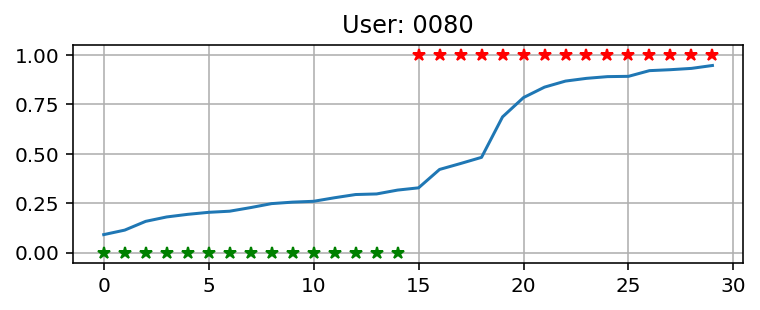

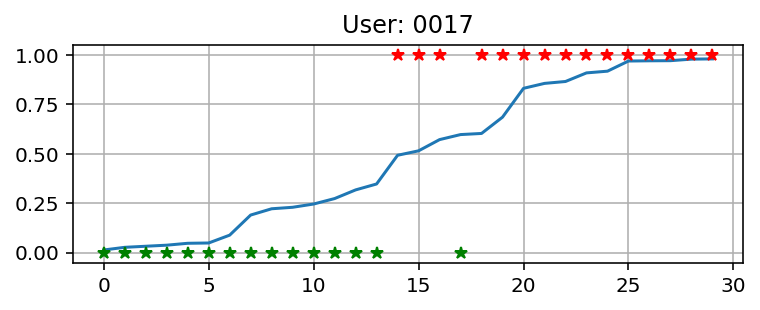

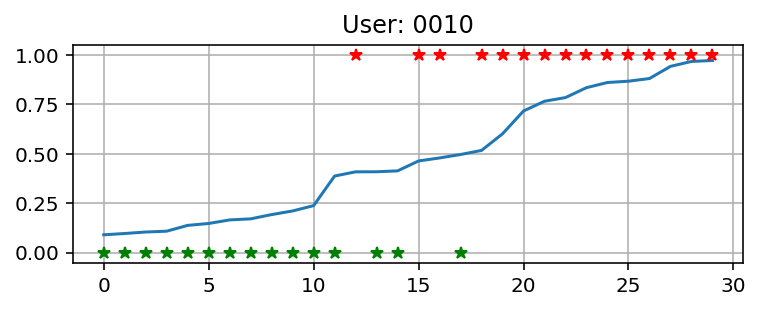

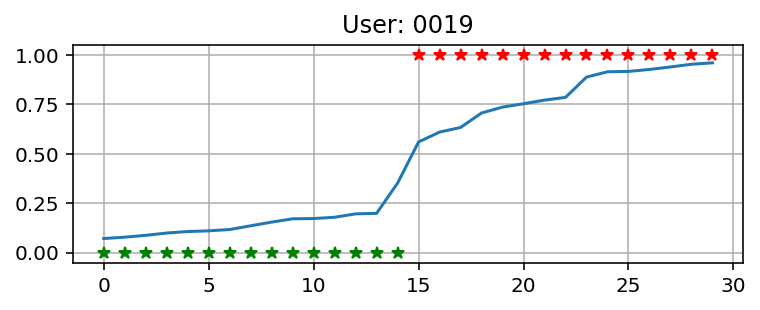

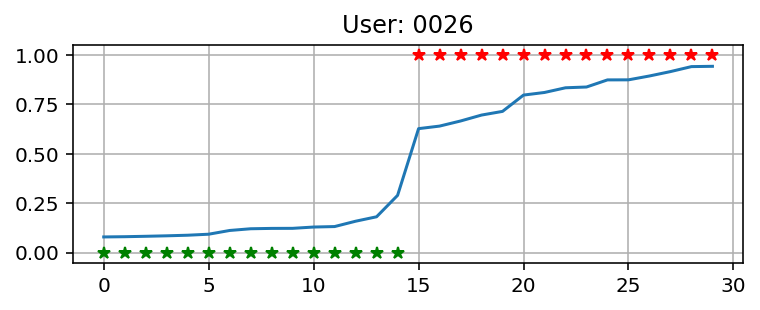

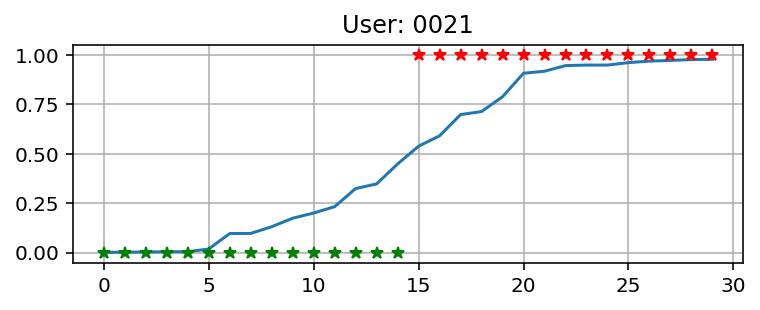

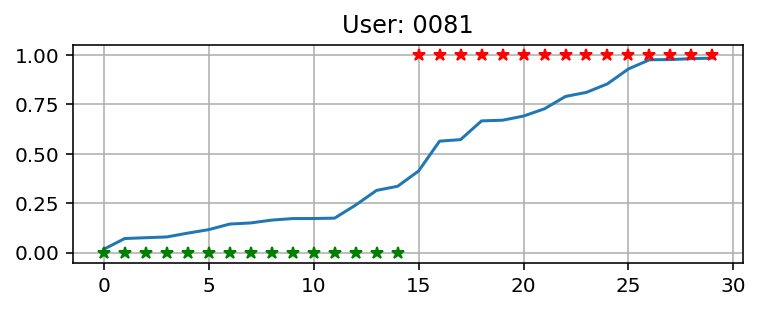

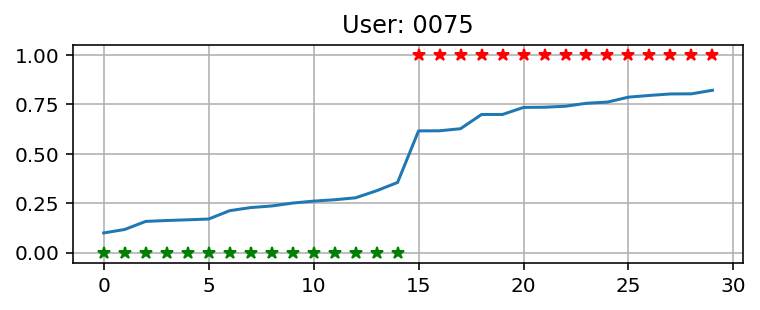

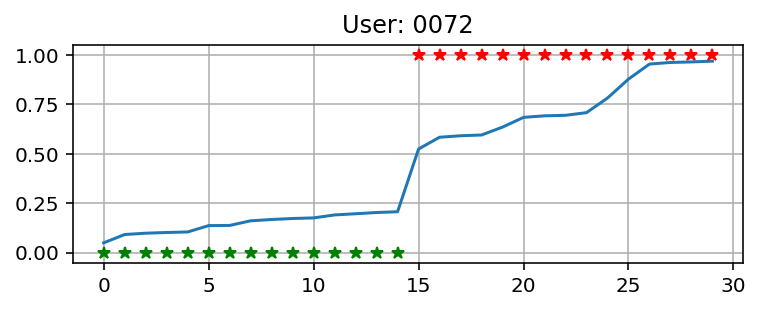

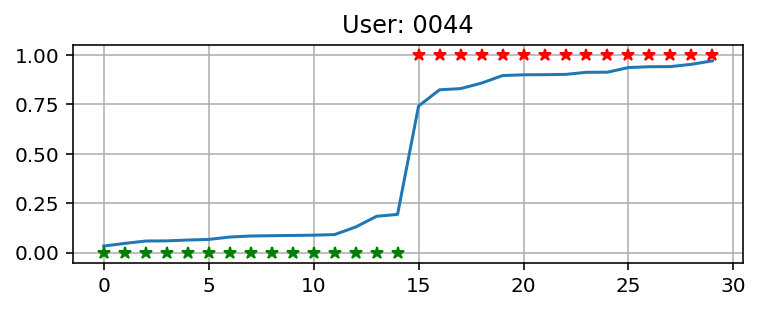

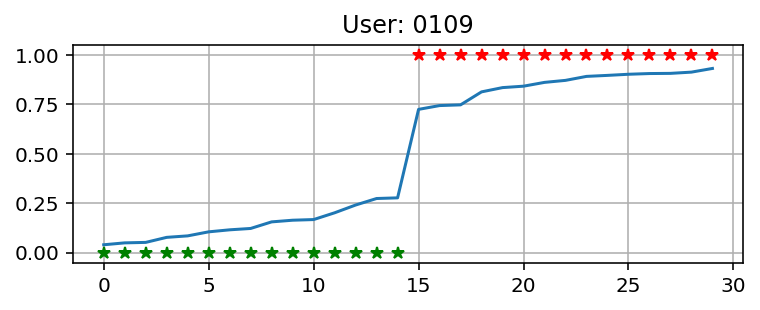

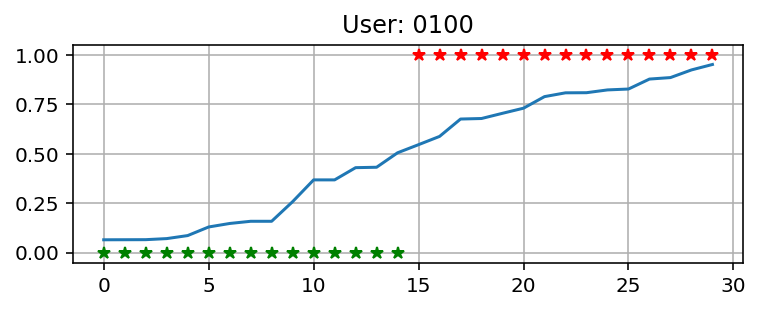

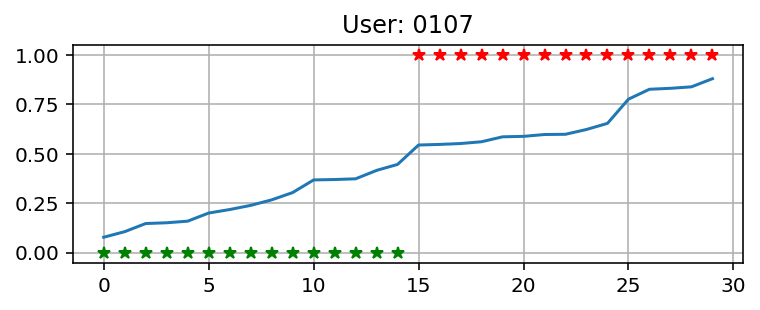

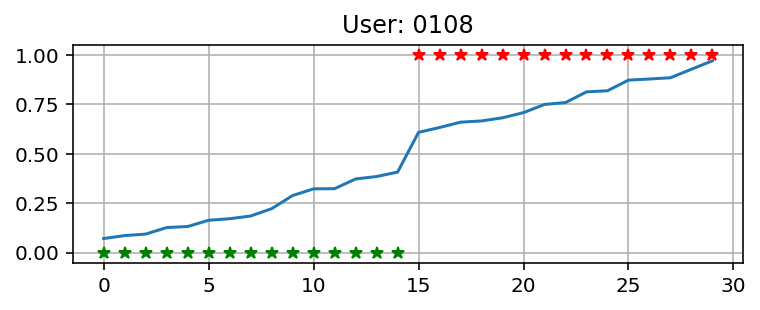

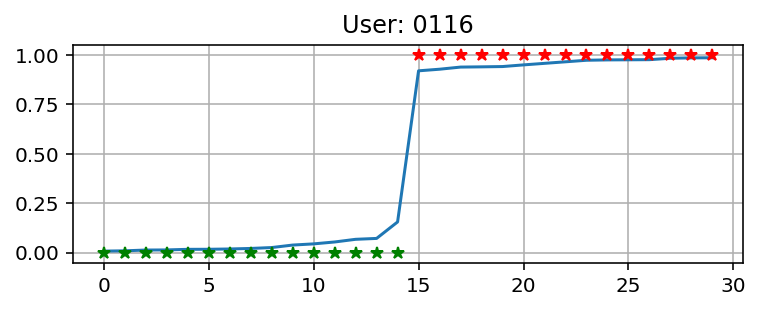

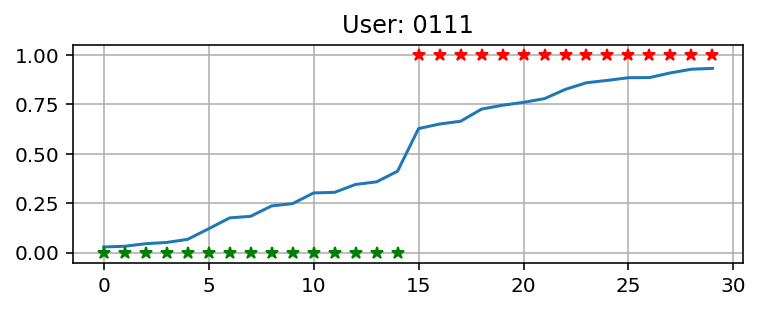

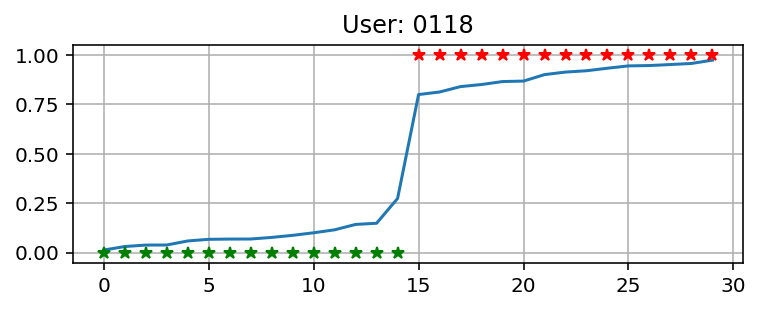

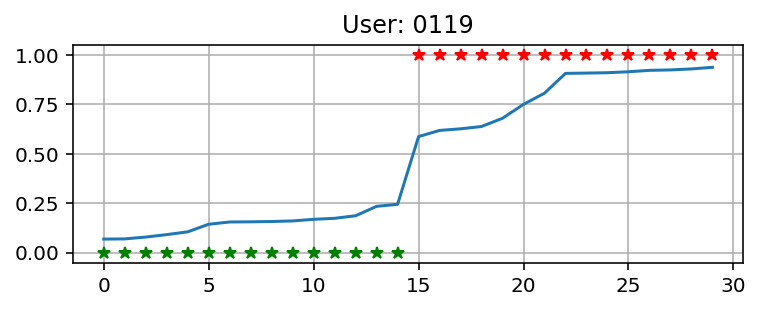

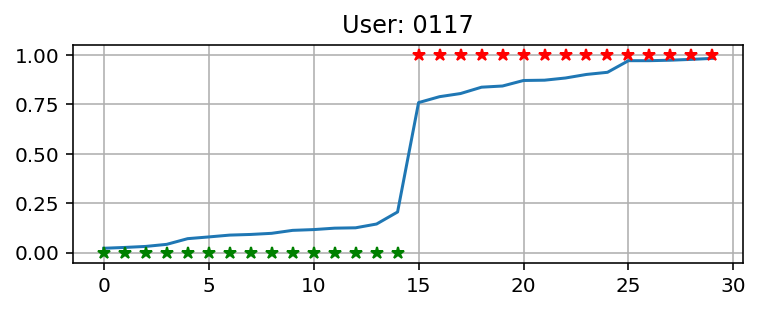

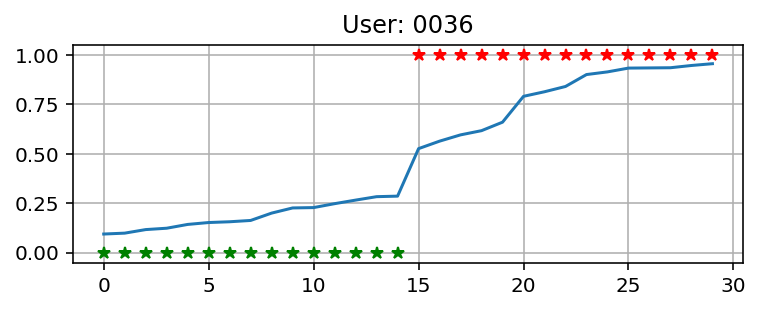

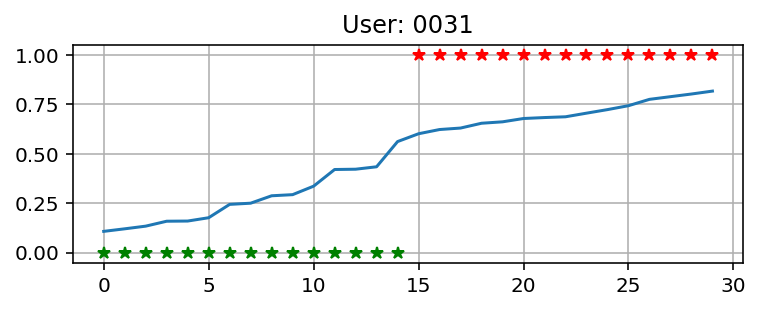

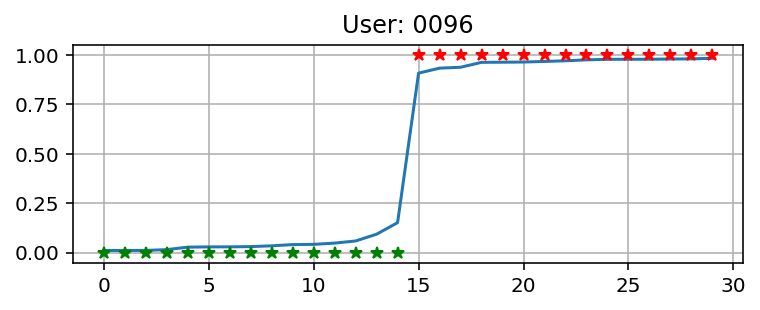

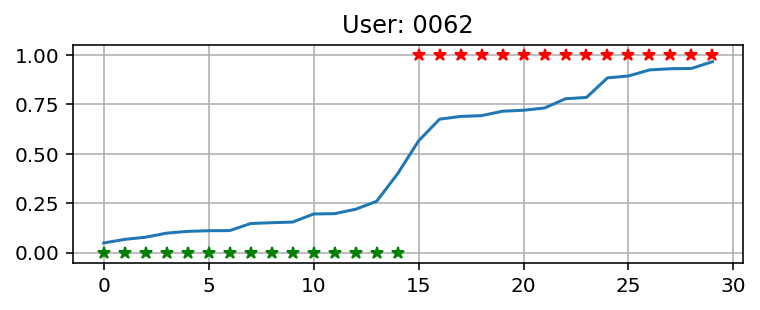

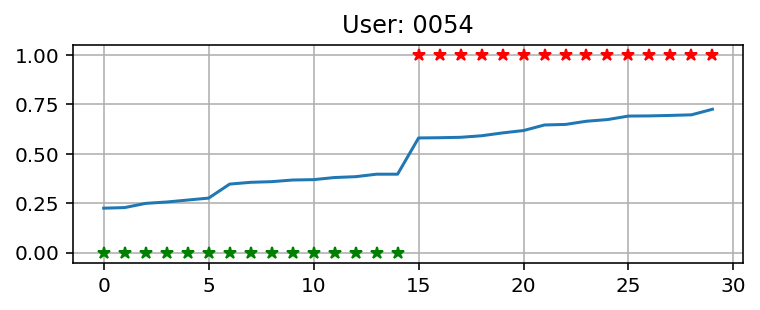

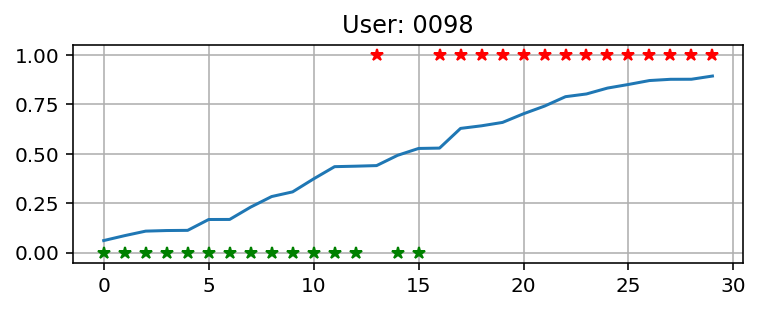

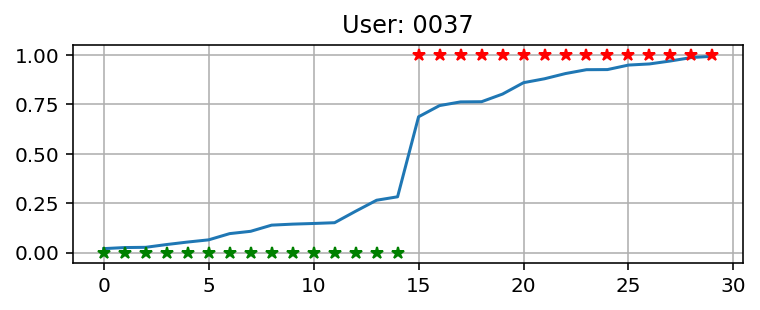

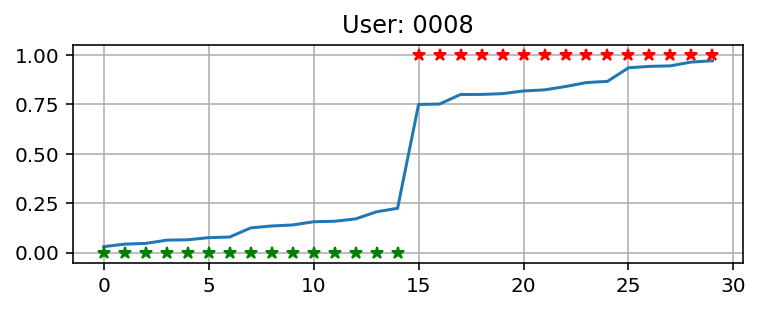

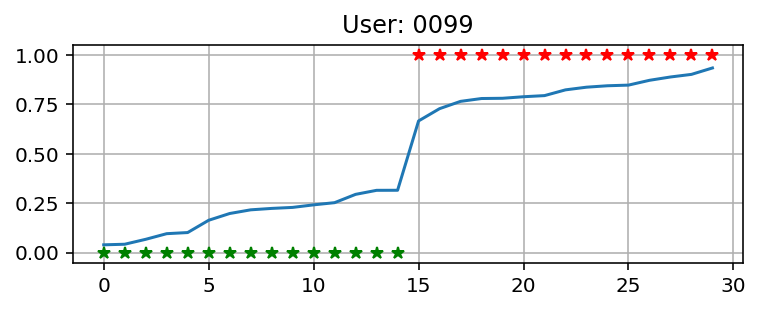

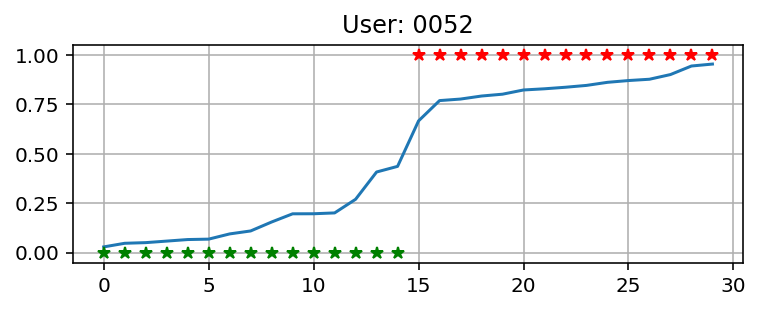

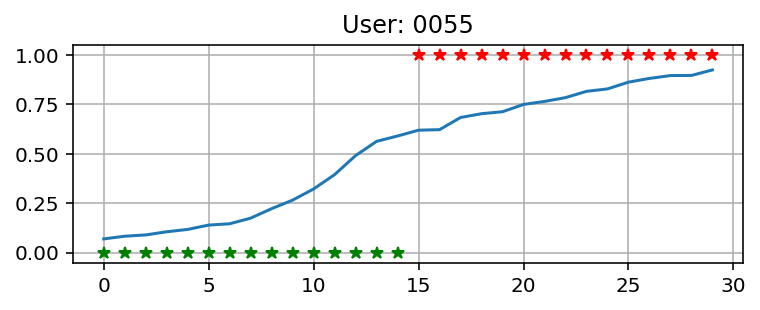

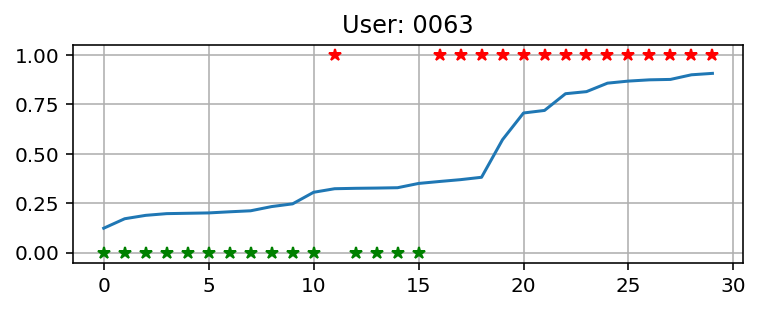

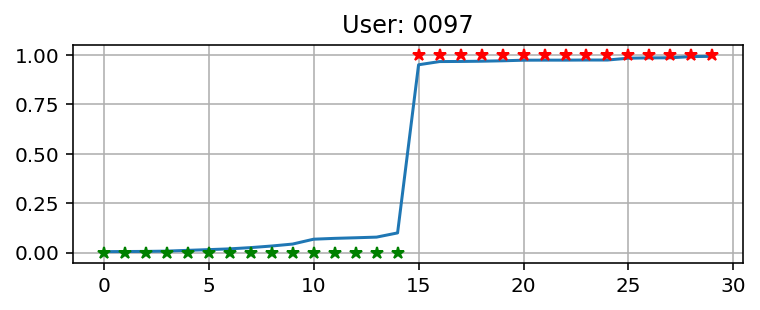

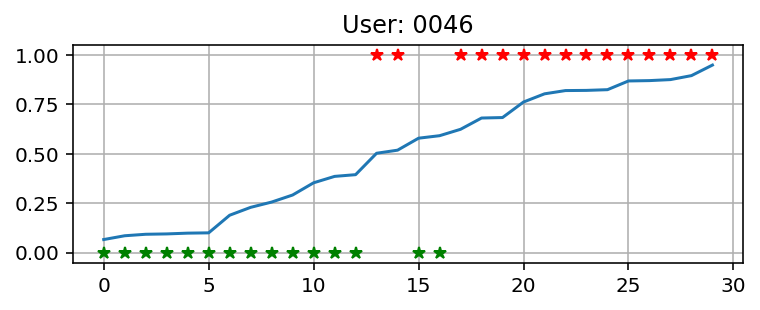

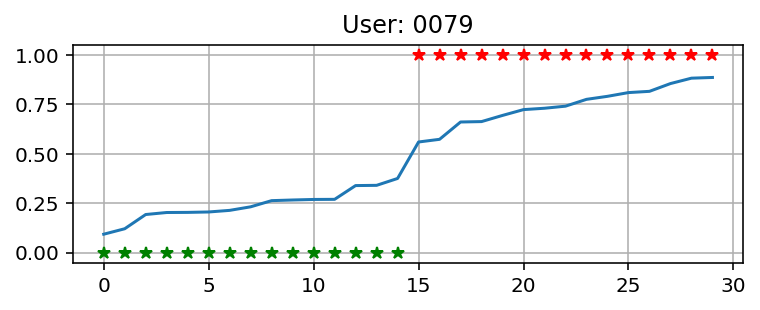

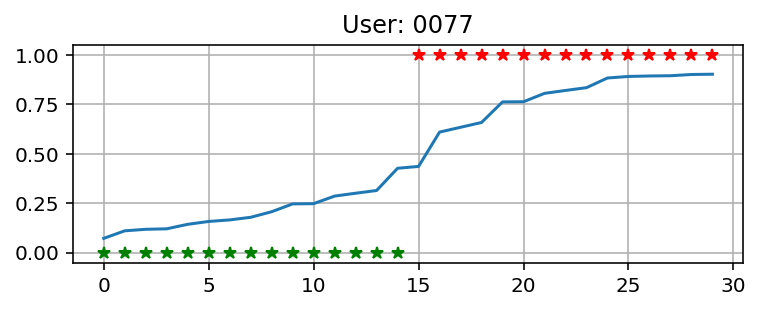

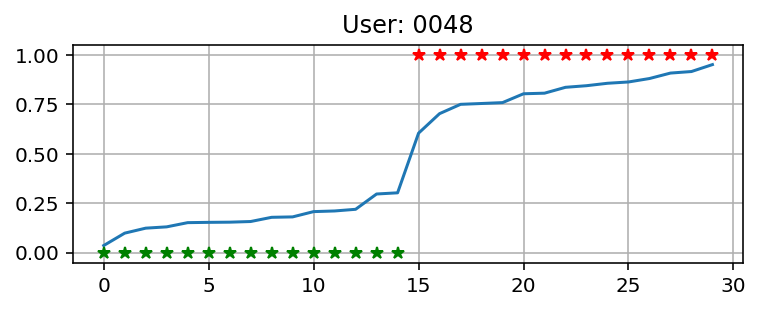

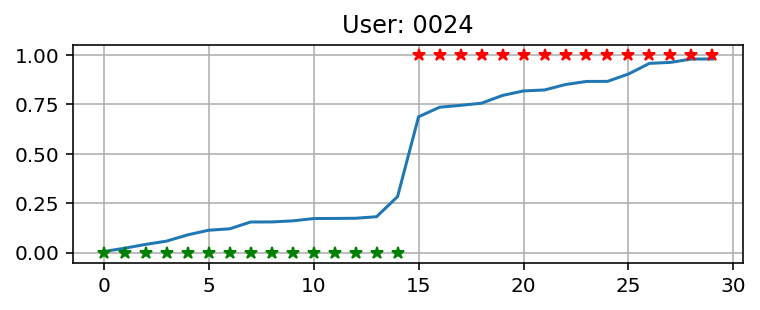

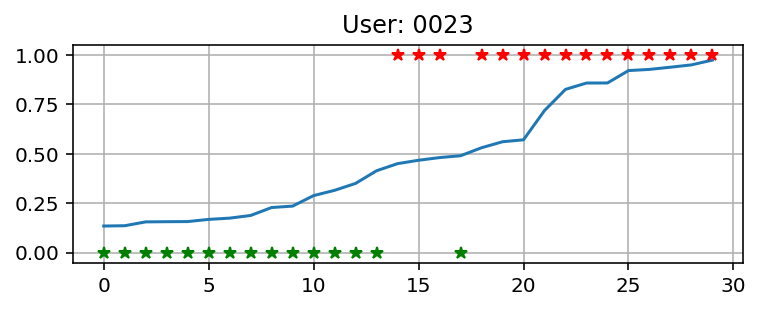

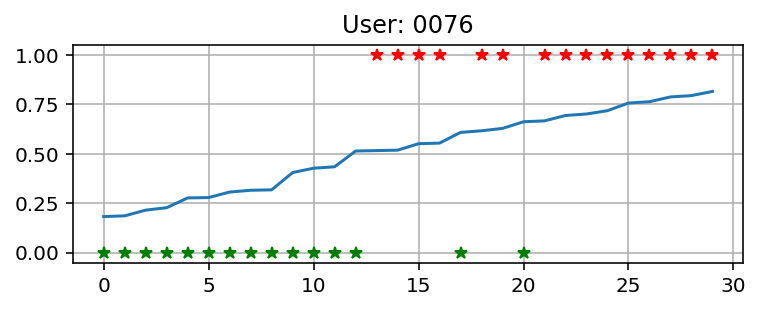

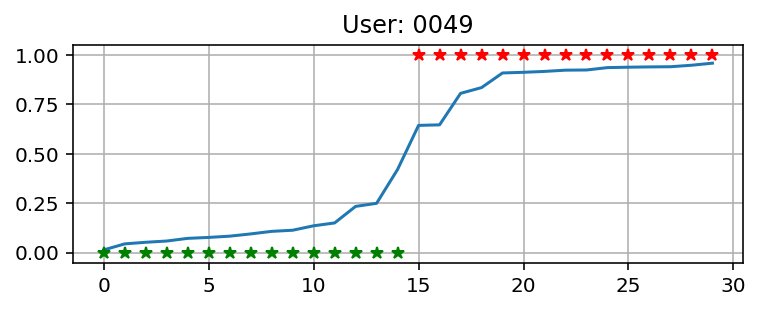

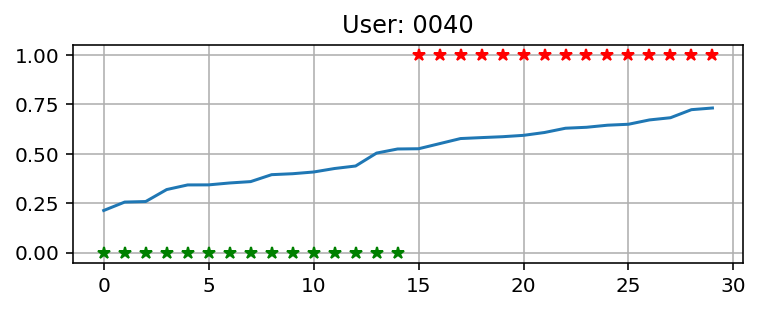

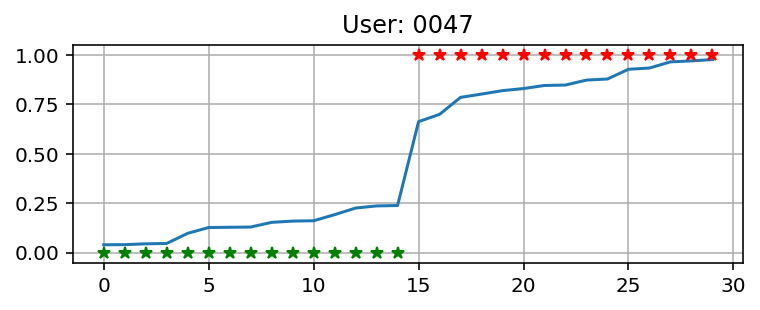

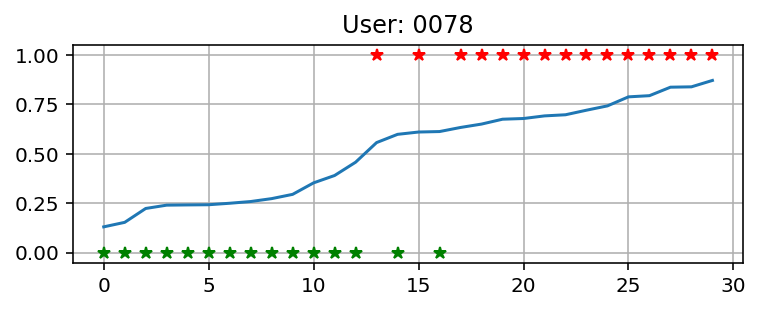

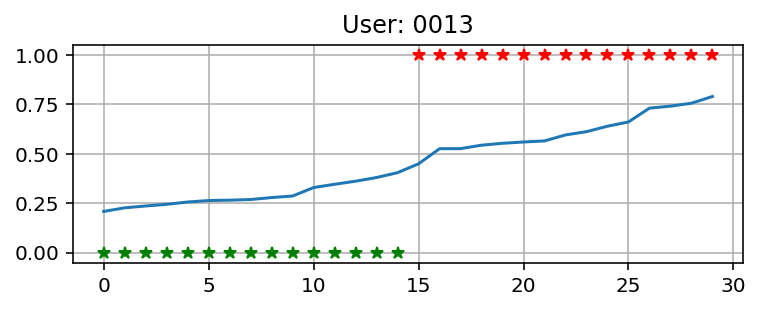

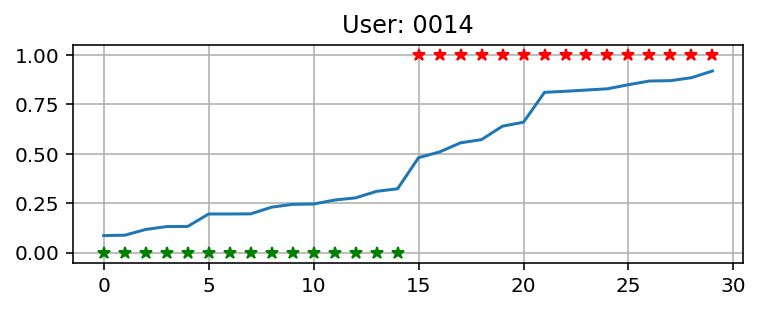

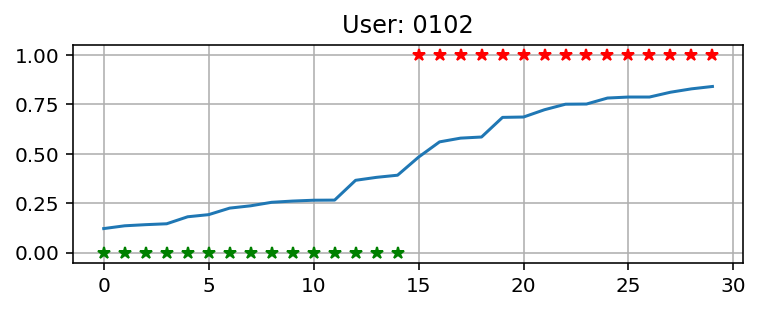

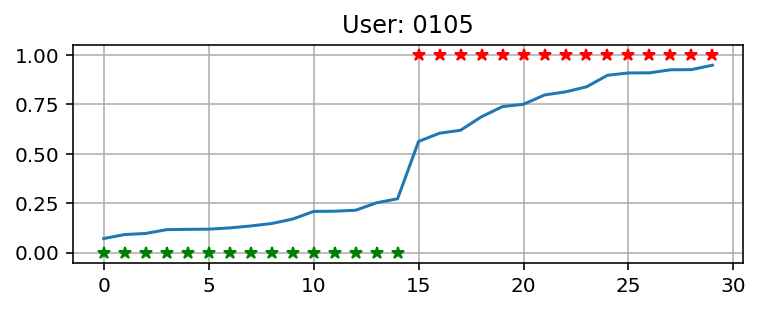

In [8]:
V90 = {}
model = skelm.ELMClassifier(alpha=0.5, n_neurons=10000)

for usr in users:
    res = process_user(usr, model)
    V90[usr] = res
    
    plt.figure(figsize=(6, 2))
    plt.plot(res[:, 2])
    i0 = np.where(res[:, 1] == 0)[0]
    plt.plot(i0, [0]*len(i0), "*g")

    i1 = np.where(res[:, 1] == 1)[0]
    plt.plot(i1, [1]*len(i1), "*r")
    plt.title("User: "+usr)
    plt.grid()
    plt.show()

In [22]:
import pickle

In [23]:
with open("V_singleuser_results.pkl", "wb") as fv:
    pickle.dump({"V10":V10, "V25":V25, 'V50':V50, "V90":V90}, fv)

#  

## Run ELM

In [ ]:
params = {
    'alpha': loguniform(1e-2, 1e+1),
#     'ufunc': ['tanh', 'sigm', 'relu', 'lin'],
#     'pairwise_metric': [None, 'euclidean', 'cityblock', 'cosine'],
#     'density': loguniform(0.001, 1),
    'n_neurons': loguniform(1000, 10000),
}

In [ ]:
for i in range(2, 100000):
    rcv = RandomizedSearchCV(skelm.ELMClassifier(), params, n_iter=100, scoring='accuracy', cv=3, refit=False)
    res = rcv.fit(x, y)
    pd.DataFrame(res.cv_results_).to_pickle("res_v2/res_v2_{}.pkl".format(i))

## 

## Check results

In [ ]:
Z = pd.concat((pd.read_pickle("res_v2/res_v2_{}.pkl".format(i)) for i in range(9999) if os.path.isfile("res_v2/res_v2_{}.pkl".format(i))))
Z = Z.reset_index(drop=True)
Z = Z.drop(["params", "param_pairwise_metric", "param_ufunc"] , axis=1)

Z['param_n_neurons'] = Z['param_n_neurons'].apply(lambda a : a // 50 * 50)
Z['param_density'] = Z['param_density'].apply(lambda a : (a + 0.05)//0.1 * 0.1)
Z['param_alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)

In [ ]:
plt.figure(figsize=(8, 10))
P_10k = pd.pivot_table(Z, index='param_n_neurons', columns='param_alpha', values="mean_test_score")
# sn.heatmap(P, vmin=0.61)

In [ ]:
fname0 = "res_v2/res_v2_{}_n100000.pkl"
Z = pd.concat((pd.read_pickle(fname0.format(i)) for i in range(9999) if os.path.isfile(fname0.format(i))))
Z = Z.reset_index(drop=True)
Z = Z.drop(["params", "param_pairwise_metric", "param_ufunc"] , axis=1)

Z['param_n_neurons'] = Z['param_n_neurons'].apply(lambda a : a // 50 * 50)
Z['param_density'] = Z['param_density'].apply(lambda a : (a + 0.05)//0.1 * 0.1)
Z['param_alpha'] = Z['param_alpha'].apply(lambda a : np.log10(a)//0.5 * 0.5)

In [ ]:
plt.figure(figsize=(8, 10))
P = pd.pivot_table(Z, index='param_n_neurons', columns='param_alpha', values="mean_test_score")
sn.heatmap(P, vmin=0.655)

## performance vs number of training samples, best model

In [ ]:
train_idx, test_idx = next(GroupShuffleSplit().split(x, y, groups))
xt, xs, yt, ys = x[train_idx], x[test_idx], y[train_idx], y[test_idx]

In [ ]:
data = []
model = skelm.ELMClassifier(n_neurons=2000, alpha=0.3, batch_size=5000)

for j in np.logspace(3, np.log10(xt.shape[0]), num=30):
    jj = int(j)
    print(jj, end=' ... ')
    t = time()
    score = model.fit(x[:jj], y[:jj]).score(xs, ys)
    data.append({'N': j, 'score': score})
    t = time() - t
    print("{:.3f} : {:.1f}s".format(score, t))

In [ ]:
Z = pd.DataFrame(data)
Z.plot(x='N', y='score', logx=True, figsize=(15, 7), grid=True)

In [ ]:
data = []
model = skelm.ELMClassifier(n_neurons=2000, alpha=0.3, batch_size=5000)

for j in np.logspace(3, np.log10(xt.shape[0]), num=30):
    jj = int(j)
    print(jj, end=' ... ')
    t = time()
    score = model.fit(x[:jj], y[:jj]).score(xs, ys)
    data.append({'N': j, 'score': score})
    t = time() - t
    print("{:.3f} : {:.1f}s".format(score, t))

In [ ]:
Z = pd.DataFrame(data)
Z.plot(x='N', y='score', logx=True, figsize=(15, 7), grid=True)

#  

## Final experiments

In [11]:
X = pd.read_pickle("/home/akusok/HDD2TB/MCYTD_10p_n100.pkl")

In [12]:
Z = pd.concat((
    pd.get_dummies(X.uid, prefix='user'),
    X.drop(['wsize', 'overlap', 'xmin', 'ymin', 'xmax', 'ymax', 'uid'], axis=1)
), axis=1)

In [13]:
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] - Z.loc[:, '0':'1023'].mean()

In [14]:
# clip low standard deviation to avoid excessively large numbers
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] / Z.loc[:, '0':'1023'].std().clip(lower=0.5)

In [15]:
# limit the value range
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'].clip(lower=-5.0, upper=5.0)

In [16]:
Z = Z.reset_index(drop=True)

In [17]:
y = np.array(Z.sig_true)
x = np.array(Z.drop(['sig_true', 'fid'], axis=1))
groups = Z.fid

In [23]:
import pickle
with open("/home/akusok/HDD2TB/temp1.pkl", "wb") as f:
    pickle.dump((x, y, groups), f)

In [19]:
del Z

#  

#### trying GPU accelerated ELM

In [5]:
import pickle
with open("/home/akusok/HDD2TB/temp1.pkl", "rb") as f:
    x, y, groups = pickle.load(f)

In [6]:
from sklearn.model_selection import cross_val_predict

In [26]:
#model = skelm.ELMClassifier(alpha=10, n_neurons=9000, ufunc='sigm', density=0.02, cuda=True)
model = skelm.ELMClassifier(alpha=10, n_neurons=9000, ufunc='sigm', batch_size=10000, cuda=True)

In [15]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [17]:
%lprun -f skelm._BaseELM.partial_fit -f skelm.solver_skcuda.ScikitCUDASolver.partial_fit cvp = cross_val_predict(model, x, y, groups=groups, cv=GroupKFold(n_splits=3), n_jobs=None)

/home/akusok/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (1099 < 9000).The dimensionality of the problem will not be reduced.
  warnings.warn(


*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-06 s

Total time: 26.0856 s
File: /home/akusok/Desktop/scikit-elm/skelm/elm.py
Function: partial_fit at line 89

Line #      Hits         Time  Per Hit   % Time  Line Contents
    89                                               def partial_fit(self, X, y=None, compute_output_weights=True):
    90                                                   """Update model with a new batch of data.
    91                                           
    92                                                   Output weight computation can be temporary turned off for faster processing. This will mark model as
    93                                                   not fit. Enable `compute_output_weights` in the final call to `partial_fit`.
    94                                           
    95                                                   Parameters
    96                                                   ----------
    97                                                   X : {arra

In [28]:
%time model.fit(x, y)

/home/akusok/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (1099 < 9000).The dimensionality of the problem will not be reduced.
  warnings.warn(


ELM covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/home/akusok/Desktop/scikit-elm/skelm/solver_skcuda.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(XtX, XtY)[0]


CPU times: user 35min 59s, sys: 27.3 s, total: 36min 26s
Wall time: 6min 53s


ELMClassifier(alpha=10, batch_size=10000, cuda=True, n_neurons=9000,
              ufunc='sigm')

In [18]:
from hpelm import HPELM

In [21]:
elm = HPELM(x.shape[1], 1, accelerator='GPU', precision=np.float32)
elm.add_neurons(9000, 'sigm')

Using CUDA GPU acceleration with Scikit-CUDA


In [24]:
%time elm.train(x, y)

processing batch 101/225, eta 0:00:06
processing batch 202/225, eta 0:00:01
CPU times: user 22.8 s, sys: 606 ms, total: 23.4 s
Wall time: 13.6 s


In [ ]:
cvp

In [ ]:
np.save("/home/akusok/HDD2TB/MCYTD_10p_n100-predict.npy", cvp)